### Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics
!pip install torcheval

import os

import random
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchsummary
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

from PIL import Image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Cargar imágenes y sus targets

In [2]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip -q
#!unzip /content/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h -q

Downloading...
From (original): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
From (redirected): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS&confirm=t&uuid=89422caf-da21-4aa4-b04e-1279df93df14
To: /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
100%|████████████████████████████████████████| 394M/394M [00:15<00:00, 25.7MB/s]
Archive:  /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
caution: filename not matched:  -q


### Instanciar dataset y dataloaders

In [4]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    0 - Normal
    1 - Diabetes
    2 - Glaucoma
    3 - Cataratas
    4 - Degeneración macular asociada a la edad
    5 - Hipertensión
    6 - Miopía
    7 - Otras enfermedades o anormalidades
    '''
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        # Eliminar columnas redundantes
        self.df = self.df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])

        # Convertir one-hot encoded 'target' a integer class labels
        self.df['target'] = self.df['target'].apply(lambda x: torch.argmax(torch.tensor(eval(x))))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx, self.df.columns.get_loc('filename')]))
        image = Image.open(img_name)
        #image = self.to_tensor(image)

        target_value = self.df.iloc[idx]['target']
        if not isinstance(target_value, torch.Tensor):
            label = torch.tensor(target_value).clone().detach()
        else:
            label = target_value.clone().detach()
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
     

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return 0
            #return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return 1
            #return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return 2
            #return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return 3
            #return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return 4
            #return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return 5
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return 6
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return 7
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if not isinstance(image, torch.Tensor):  # Comprueba si la imagen es un tensor de PyTorch
            if self.transform:
                image = self.transform(image)
        return image, label  
# Leer el dataframe que contiene los targets para cada imagen.
full_df = pd.read_csv('full_df.csv')

# Instanciar el dataset.
dataset = FundusDataset(csv_file='full_df.csv', root_dir='preprocessed_images/')


In [5]:
# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = TransformedDataset(train_dataset, transform=data_transforms)
test_dataset = TransformedDataset(test_dataset, transform=data_transforms)

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')

Train feature batch shape: torch.Size([32, 3, 224, 224])
Train labels batch shape: torch.Size([32])
Test feature batch shape: torch.Size([32, 3, 224, 224])
Test labels batch shape: torch.Size([32])


### Funciones de Entrenamiento

In [9]:
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, num_classes=8, early_stopping=False, patience=5):
    if early_stopping:
        best_loss = float('inf')
        no_improvement_count = 0

    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            

            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy.compute()
        train_accuracies.append(train_accuracy)
        train_precision = precision.compute()
        train_precisions.append(train_precision)
        train_recall = recall.compute()
        train_recalls.append(train_recall)

            #train_predictions.extend(predicted.cpu().tolist())
            #train_targets.extend(labels.cpu().tolist())



        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}')

        # Evaluación del modelo en el conjunto de datos de prueba
        model.eval()
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}', unit='batch'):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
              

                accuracy.update(predicted, labels)
                precision.update(predicted, labels)
                recall.update(predicted, labels)

                #test_predictions.extend(predicted.cpu().tolist())
                #test_targets.extend(labels.cpu().tolist())
        test_loss = running_loss/len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = accuracy.compute()
        test_accuracies.append(test_accuracy)
        test_precision = precision.compute()
        test_precisions.append(test_precision)
        test_recall = recall.compute()
        test_recalls.append(test_recall)

        print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}, Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}')

        if early_stopping:
            if test_loss < best_loss:
                best_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'No improvement for {patience} epochs. Early stopping...')
                break

    return train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls



In [10]:


def plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls):
    epochs = range(1, len(train_losses) + 1)


    # Convertir tensores a valores flotantes
    train_accuracies = [accuracy.item() for accuracy in train_accuracies]
    test_accuracies = [accuracy.item() for accuracy in test_accuracies]
    train_precisions = [precision.item() for precision in train_precisions]
    test_precisions = [precision.item() for precision in test_precisions]
    train_recalls = [recall.item() for recall in train_recalls]
    test_recalls = [recall.item() for recall in test_recalls]

  

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(epochs, train_losses, label='Training Loss')
    axes[0, 0].plot(epochs, test_losses, label='Testing Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot accuracy
    axes[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
    axes[0, 1].plot(epochs, test_accuracies, label='Testing Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot precision
    axes[1, 0].plot(epochs, train_precisions, label='Training Precision')
    axes[1, 0].plot(epochs, test_precisions, label='Testing Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()

    # Plot recall
    axes[1, 1].plot(epochs, train_recalls, label='Training Recall')
    axes[1, 1].plot(epochs, test_recalls, label='Testing Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()




### VGGNet16 con fine-tunning

In [6]:
# Definir el modelo VGGNet con fine-tuning
class VGGNetFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFineTuning, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = True
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [7]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)


/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.7165, Training Accuracy: 0.1248, Training Precision: 0.1425, Training Recall: 0.1248


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 6.8660, Testing Accuracy: 0.1248, Testing Precision: 0.1420, Testing Recall: 0.1248


Training Epoch 2/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5665, Training Accuracy: 0.1247, Training Precision: 0.1414, Training Recall: 0.1247


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.55batch/s]


Testing Loss: 6.2658, Testing Accuracy: 0.1247, Testing Precision: 0.1412, Testing Recall: 0.1247


Training Epoch 3/100: 100%|████████████████| 160/160 [01:18<00:00,  2.04batch/s]


Training Loss: 1.5675, Training Accuracy: 0.1248, Training Precision: 0.1412, Training Recall: 0.1248


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 6.2698, Testing Accuracy: 0.1248, Testing Precision: 0.1411, Testing Recall: 0.1248


Training Epoch 4/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5637, Training Accuracy: 0.1249, Training Precision: 0.1412, Training Recall: 0.1249


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 6.2547, Testing Accuracy: 0.1249, Testing Precision: 0.1411, Testing Recall: 0.1249


Training Epoch 5/100: 100%|████████████████| 160/160 [01:22<00:00,  1.94batch/s]


Training Loss: 1.5666, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 6.2664, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 6/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5608, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 6.2433, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 7/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5623, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 6.2493, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 8/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5597, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 6.2389, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 9/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 6.2426, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 10/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5596, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 6.2383, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 11/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 6.2295, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 12/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 6.2424, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 13/100: 100%|███████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.5589, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 6.2356, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 14/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5576, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.52batch/s]


Testing Loss: 6.2304, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 15/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5584, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 6.2337, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 16/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]

Testing Loss: 6.2296, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250
No improvement for 5 epochs. Early stopping...


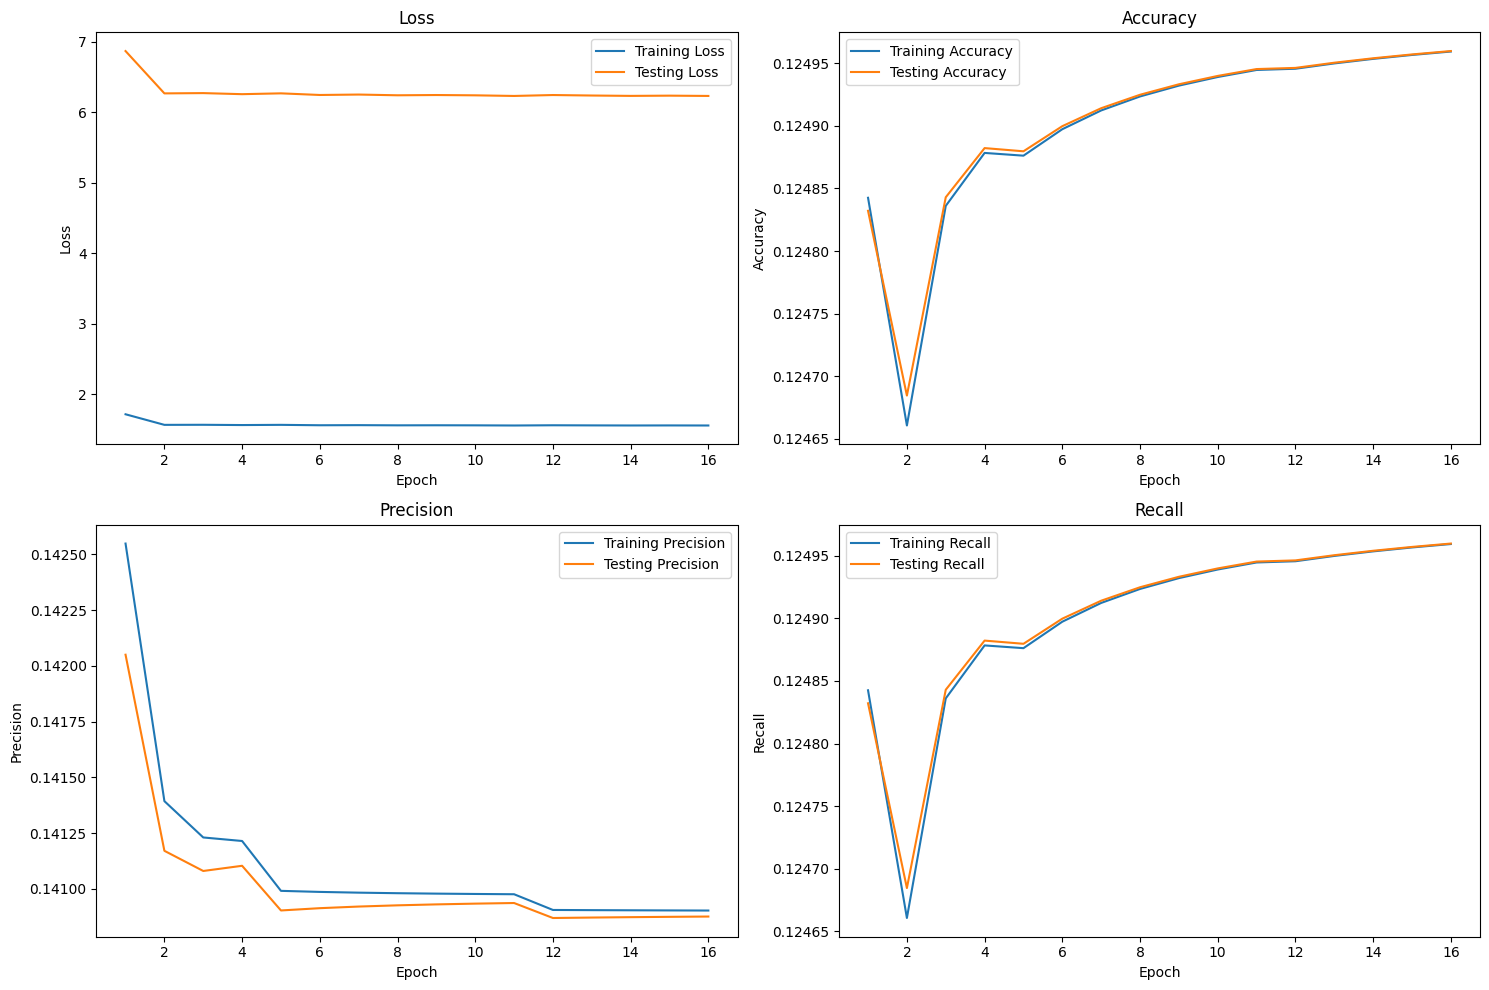

In [8]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [11]:
def compare_predictions(model, dataloader, device, class_names, num_samples=1):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(num_samples):
            expected_class = class_names[labels[i].item()]
            predicted_class = class_names[predicted[i].item()]
            print(f'Expected: {expected_class}, Predicted: {predicted_class}')

# Diccionario de mapeo de índices de clases a nombres de enfermedades
class_names = {
    0: 'Normal',
    1: 'Diabetes',
    2: 'Glaucoma',
    3: 'Cataratas',
    4: 'Degeneración macular asociada a la edad',
    5: 'Hipertensión',
    6: 'Miopía',
    7: 'Otras enfermedades o anormalidades'
}

In [11]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Glaucoma, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Normal


### VGGnet16 con feature extraction con clasificador lineal

In [12]:
torch.cuda.empty_cache() 


class VGGNetFeatureExtractionND(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFeatureExtractionND, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG16
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Linear(in_features=25088, out_features=num_classes)
    
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x

In [81]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtractionND(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 1.6361, Training Accuracy: 0.3720, Training Precision: 0.3869, Training Recall: 0.3720


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 6.5444, Testing Accuracy: 0.3729, Testing Precision: 0.3914, Testing Recall: 0.3729


Training Epoch 2/100: 100%|████████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.6915, Training Accuracy: 0.5153, Training Precision: 0.5841, Training Recall: 0.5153


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 2.7661, Testing Accuracy: 0.5000, Testing Precision: 0.5737, Testing Recall: 0.5000


Training Epoch 3/100: 100%|████████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.4152, Training Accuracy: 0.5974, Training Precision: 0.6828, Training Recall: 0.5974


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 1.6609, Testing Accuracy: 0.5857, Testing Precision: 0.6630, Testing Recall: 0.5857


Training Epoch 4/100: 100%|████████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.2677, Training Accuracy: 0.6567, Training Precision: 0.7332, Training Recall: 0.6567


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 1.0706, Testing Accuracy: 0.6448, Testing Precision: 0.7222, Testing Recall: 0.6448


Training Epoch 5/100: 100%|████████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.1828, Training Accuracy: 0.6975, Training Precision: 0.7698, Training Recall: 0.6975


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.7312, Testing Accuracy: 0.6856, Testing Precision: 0.7644, Testing Recall: 0.6856


Training Epoch 6/100: 100%|████████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.1141, Training Accuracy: 0.7269, Training Precision: 0.7997, Training Recall: 0.7269


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.4565, Testing Accuracy: 0.7159, Testing Precision: 0.7953, Testing Recall: 0.7159


Training Epoch 7/100: 100%|████████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0796, Training Accuracy: 0.7486, Training Precision: 0.8219, Training Recall: 0.7486


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.3183, Testing Accuracy: 0.7384, Testing Precision: 0.8174, Testing Recall: 0.7384


Training Epoch 8/100: 100%|████████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0607, Training Accuracy: 0.7648, Training Precision: 0.8380, Training Recall: 0.7648


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.2428, Testing Accuracy: 0.7556, Testing Precision: 0.8338, Testing Recall: 0.7556


Training Epoch 9/100: 100%|████████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0505, Training Accuracy: 0.7776, Training Precision: 0.8504, Training Recall: 0.7776


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.2019, Testing Accuracy: 0.7691, Testing Precision: 0.8460, Testing Recall: 0.7691


Training Epoch 10/100: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0401, Training Accuracy: 0.7877, Training Precision: 0.8598, Training Recall: 0.7877


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.1605, Testing Accuracy: 0.7797, Testing Precision: 0.8561, Testing Recall: 0.7797


Training Epoch 11/100: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0318, Training Accuracy: 0.7958, Training Precision: 0.8677, Training Recall: 0.7958


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.1272, Testing Accuracy: 0.7886, Testing Precision: 0.8641, Testing Recall: 0.7886


Training Epoch 12/100: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0260, Training Accuracy: 0.8028, Training Precision: 0.8741, Training Recall: 0.8028


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.1042, Testing Accuracy: 0.7960, Testing Precision: 0.8706, Testing Recall: 0.7960


Training Epoch 13/100: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0231, Training Accuracy: 0.8086, Training Precision: 0.8794, Training Recall: 0.8086


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0924, Testing Accuracy: 0.8024, Testing Precision: 0.8759, Testing Recall: 0.8024


Training Epoch 14/100: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0197, Training Accuracy: 0.8138, Training Precision: 0.8837, Training Recall: 0.8138


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0787, Testing Accuracy: 0.8077, Testing Precision: 0.8805, Testing Recall: 0.8077


Training Epoch 15/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0174, Training Accuracy: 0.8180, Training Precision: 0.8874, Training Recall: 0.8180


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0697, Testing Accuracy: 0.8123, Testing Precision: 0.8847, Testing Recall: 0.8123


Training Epoch 16/100: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0155, Training Accuracy: 0.8217, Training Precision: 0.8910, Training Recall: 0.8217


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0621, Testing Accuracy: 0.8164, Testing Precision: 0.8883, Testing Recall: 0.8164


Training Epoch 17/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0136, Training Accuracy: 0.8251, Training Precision: 0.8940, Training Recall: 0.8251


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0545, Testing Accuracy: 0.8200, Testing Precision: 0.8917, Testing Recall: 0.8200


Training Epoch 18/100: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0118, Training Accuracy: 0.8280, Training Precision: 0.8969, Training Recall: 0.8280


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0474, Testing Accuracy: 0.8233, Testing Precision: 0.8945, Testing Recall: 0.8233


Training Epoch 19/100: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0107, Training Accuracy: 0.8307, Training Precision: 0.8993, Training Recall: 0.8307


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0429, Testing Accuracy: 0.8262, Testing Precision: 0.8972, Testing Recall: 0.8262


Training Epoch 20/100: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0096, Training Accuracy: 0.8332, Training Precision: 0.9016, Training Recall: 0.8332


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0383, Testing Accuracy: 0.8289, Testing Precision: 0.8994, Testing Recall: 0.8289


Training Epoch 21/100: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0087, Training Accuracy: 0.8354, Training Precision: 0.9035, Training Recall: 0.8354


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0349, Testing Accuracy: 0.8312, Testing Precision: 0.9016, Testing Recall: 0.8312


Training Epoch 22/100: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0079, Training Accuracy: 0.8373, Training Precision: 0.9054, Training Recall: 0.8373


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0315, Testing Accuracy: 0.8333, Testing Precision: 0.9034, Testing Recall: 0.8333


Training Epoch 23/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.0070, Training Accuracy: 0.8391, Training Precision: 0.9070, Training Recall: 0.8391


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0282, Testing Accuracy: 0.8353, Testing Precision: 0.9052, Testing Recall: 0.8353


Training Epoch 24/100: 100%|███████████████| 160/160 [00:40<00:00,  3.99batch/s]


Training Loss: 0.0064, Training Accuracy: 0.8408, Training Precision: 0.9086, Training Recall: 0.8408


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0257, Testing Accuracy: 0.8370, Testing Precision: 0.9068, Testing Recall: 0.8370


Training Epoch 25/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0060, Training Accuracy: 0.8422, Training Precision: 0.9100, Training Recall: 0.8422


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0240, Testing Accuracy: 0.8387, Testing Precision: 0.9084, Testing Recall: 0.8387


Training Epoch 26/100: 100%|███████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0055, Training Accuracy: 0.8436, Training Precision: 0.9114, Training Recall: 0.8436


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0221, Testing Accuracy: 0.8402, Testing Precision: 0.9097, Testing Recall: 0.8402


Training Epoch 27/100: 100%|███████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0049, Training Accuracy: 0.8449, Training Precision: 0.9126, Training Recall: 0.8449


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0196, Testing Accuracy: 0.8416, Testing Precision: 0.9110, Testing Recall: 0.8416


Training Epoch 28/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0046, Training Accuracy: 0.8461, Training Precision: 0.9137, Training Recall: 0.8461


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0182, Testing Accuracy: 0.8429, Testing Precision: 0.9120, Testing Recall: 0.8429


Training Epoch 29/100: 100%|███████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0041, Training Accuracy: 0.8472, Training Precision: 0.9146, Training Recall: 0.8472


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0163, Testing Accuracy: 0.8440, Testing Precision: 0.9131, Testing Recall: 0.8440


Training Epoch 30/100: 100%|███████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0038, Training Accuracy: 0.8482, Training Precision: 0.9156, Training Recall: 0.8482


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0153, Testing Accuracy: 0.8452, Testing Precision: 0.9140, Testing Recall: 0.8452


Training Epoch 31/100: 100%|███████████████| 160/160 [00:39<00:00,  4.06batch/s]


Training Loss: 0.0035, Training Accuracy: 0.8492, Training Precision: 0.9163, Training Recall: 0.8492


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0141, Testing Accuracy: 0.8462, Testing Precision: 0.9149, Testing Recall: 0.8462


Training Epoch 32/100: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8501, Training Precision: 0.9172, Training Recall: 0.8501


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.8473, Testing Precision: 0.9157, Testing Recall: 0.8473


Training Epoch 33/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8510, Training Precision: 0.9179, Training Recall: 0.8510


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8482, Testing Precision: 0.9165, Testing Recall: 0.8482


Training Epoch 34/100: 100%|███████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8517, Training Precision: 0.9186, Training Recall: 0.8517


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8490, Testing Precision: 0.9174, Testing Recall: 0.8490


Training Epoch 35/100: 100%|███████████████| 160/160 [00:38<00:00,  4.12batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8524, Training Precision: 0.9194, Training Recall: 0.8524


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0099, Testing Accuracy: 0.8498, Testing Precision: 0.9180, Testing Recall: 0.8498


Training Epoch 36/100: 100%|███████████████| 160/160 [00:38<00:00,  4.13batch/s]


Training Loss: 0.0023, Training Accuracy: 0.8531, Training Precision: 0.9200, Training Recall: 0.8531


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0090, Testing Accuracy: 0.8506, Testing Precision: 0.9187, Testing Recall: 0.8506


Training Epoch 37/100: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0021, Training Accuracy: 0.8538, Training Precision: 0.9206, Training Recall: 0.8538


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0083, Testing Accuracy: 0.8514, Testing Precision: 0.9193, Testing Recall: 0.8514


Training Epoch 38/100: 100%|███████████████| 160/160 [00:38<00:00,  4.13batch/s]


Training Loss: 0.0019, Training Accuracy: 0.8545, Training Precision: 0.9211, Training Recall: 0.8545


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0077, Testing Accuracy: 0.8521, Testing Precision: 0.9198, Testing Recall: 0.8521


Training Epoch 39/100: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0018, Training Accuracy: 0.8551, Training Precision: 0.9216, Training Recall: 0.8551


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0070, Testing Accuracy: 0.8527, Testing Precision: 0.9204, Testing Recall: 0.8527


Training Epoch 40/100: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0016, Training Accuracy: 0.8557, Training Precision: 0.9220, Training Recall: 0.8557


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0064, Testing Accuracy: 0.8534, Testing Precision: 0.9208, Testing Recall: 0.8534


Training Epoch 41/100: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0015, Training Accuracy: 0.8563, Training Precision: 0.9224, Training Recall: 0.8563


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0061, Testing Accuracy: 0.8540, Testing Precision: 0.9213, Testing Recall: 0.8540


Training Epoch 42/100: 100%|███████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8568, Training Precision: 0.9229, Training Recall: 0.8568


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0056, Testing Accuracy: 0.8546, Testing Precision: 0.9218, Testing Recall: 0.8546


Training Epoch 43/100: 100%|███████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0013, Training Accuracy: 0.8573, Training Precision: 0.9234, Training Recall: 0.8573


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0050, Testing Accuracy: 0.8551, Testing Precision: 0.9222, Testing Recall: 0.8551


Training Epoch 44/100: 100%|███████████████| 160/160 [00:39<00:00,  4.03batch/s]


Training Loss: 0.0012, Training Accuracy: 0.8577, Training Precision: 0.9237, Training Recall: 0.8577


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0047, Testing Accuracy: 0.8556, Testing Precision: 0.9227, Testing Recall: 0.8556


Training Epoch 45/100: 100%|███████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8582, Training Precision: 0.9242, Training Recall: 0.8582


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0043, Testing Accuracy: 0.8561, Testing Precision: 0.9232, Testing Recall: 0.8561


Training Epoch 46/100: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8586, Training Precision: 0.9246, Training Recall: 0.8586


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0040, Testing Accuracy: 0.8566, Testing Precision: 0.9236, Testing Recall: 0.8566


Training Epoch 47/100: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8590, Training Precision: 0.9250, Training Recall: 0.8590


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0036, Testing Accuracy: 0.8570, Testing Precision: 0.9239, Testing Recall: 0.8570


Training Epoch 48/100: 100%|███████████████| 160/160 [00:37<00:00,  4.31batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8594, Training Precision: 0.9253, Training Recall: 0.8594


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0034, Testing Accuracy: 0.8575, Testing Precision: 0.9243, Testing Recall: 0.8575


Training Epoch 49/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8598, Training Precision: 0.9256, Training Recall: 0.8598


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0031, Testing Accuracy: 0.8579, Testing Precision: 0.9246, Testing Recall: 0.8579


Training Epoch 50/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8602, Training Precision: 0.9259, Training Recall: 0.8602


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0028, Testing Accuracy: 0.8583, Testing Precision: 0.9249, Testing Recall: 0.8583


Training Epoch 51/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8606, Training Precision: 0.9261, Training Recall: 0.8606


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0027, Testing Accuracy: 0.8588, Testing Precision: 0.9252, Testing Recall: 0.8588


Training Epoch 52/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8609, Training Precision: 0.9264, Training Recall: 0.8609


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0025, Testing Accuracy: 0.8591, Testing Precision: 0.9255, Testing Recall: 0.8591


Training Epoch 53/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8612, Training Precision: 0.9267, Training Recall: 0.8612


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0023, Testing Accuracy: 0.8595, Testing Precision: 0.9258, Testing Recall: 0.8595


Training Epoch 54/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8616, Training Precision: 0.9269, Training Recall: 0.8616


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0022, Testing Accuracy: 0.8599, Testing Precision: 0.9260, Testing Recall: 0.8599


Training Epoch 55/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8619, Training Precision: 0.9271, Training Recall: 0.8619


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0019, Testing Accuracy: 0.8602, Testing Precision: 0.9262, Testing Recall: 0.8602


Training Epoch 56/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8622, Training Precision: 0.9274, Training Recall: 0.8622


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0018, Testing Accuracy: 0.8606, Testing Precision: 0.9264, Testing Recall: 0.8606


Training Epoch 57/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8625, Training Precision: 0.9275, Training Recall: 0.8625


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0016, Testing Accuracy: 0.8609, Testing Precision: 0.9267, Testing Recall: 0.8609


Training Epoch 58/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8628, Training Precision: 0.9278, Training Recall: 0.8628


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0015, Testing Accuracy: 0.8611, Testing Precision: 0.9269, Testing Recall: 0.8611


Training Epoch 59/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8630, Training Precision: 0.9280, Training Recall: 0.8630


Testing Epoch 59/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0014, Testing Accuracy: 0.8614, Testing Precision: 0.9272, Testing Recall: 0.8614


Training Epoch 60/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8632, Training Precision: 0.9282, Training Recall: 0.8632


Testing Epoch 60/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0013, Testing Accuracy: 0.8617, Testing Precision: 0.9274, Testing Recall: 0.8617


Training Epoch 61/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8635, Training Precision: 0.9284, Training Recall: 0.8635


Testing Epoch 61/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8620, Testing Precision: 0.9276, Testing Recall: 0.8620


Training Epoch 62/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8637, Training Precision: 0.9286, Training Recall: 0.8637


Testing Epoch 62/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0011, Testing Accuracy: 0.8622, Testing Precision: 0.9278, Testing Recall: 0.8622


Training Epoch 63/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8639, Training Precision: 0.9288, Training Recall: 0.8639


Testing Epoch 63/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8624, Testing Precision: 0.9280, Testing Recall: 0.8624


Training Epoch 64/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8641, Training Precision: 0.9290, Training Recall: 0.8641


Testing Epoch 64/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8627, Testing Precision: 0.9282, Testing Recall: 0.8627


Training Epoch 65/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8643, Training Precision: 0.9291, Training Recall: 0.8643


Testing Epoch 65/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8629, Testing Precision: 0.9284, Testing Recall: 0.8629


Training Epoch 66/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8645, Training Precision: 0.9293, Training Recall: 0.8645


Testing Epoch 66/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8631, Testing Precision: 0.9285, Testing Recall: 0.8631


Training Epoch 67/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8648, Training Precision: 0.9294, Training Recall: 0.8648


Testing Epoch 67/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8634, Testing Precision: 0.9287, Testing Recall: 0.8634


Training Epoch 68/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8650, Training Precision: 0.9296, Training Recall: 0.8650


Testing Epoch 68/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8636, Testing Precision: 0.9288, Testing Recall: 0.8636


Training Epoch 69/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8652, Training Precision: 0.9297, Training Recall: 0.8652


Testing Epoch 69/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8638, Testing Precision: 0.9290, Testing Recall: 0.8638


Training Epoch 70/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8654, Training Precision: 0.9298, Training Recall: 0.8654


Testing Epoch 70/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8640, Testing Precision: 0.9291, Testing Recall: 0.8640


Training Epoch 71/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8656, Training Precision: 0.9299, Training Recall: 0.8656


Testing Epoch 71/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8642, Testing Precision: 0.9293, Testing Recall: 0.8642


Training Epoch 72/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8657, Training Precision: 0.9301, Training Recall: 0.8657


Testing Epoch 72/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8645, Testing Precision: 0.9294, Testing Recall: 0.8645


Training Epoch 73/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8659, Training Precision: 0.9302, Training Recall: 0.8659


Testing Epoch 73/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.44batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8647, Testing Precision: 0.9295, Testing Recall: 0.8647


Training Epoch 74/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8661, Training Precision: 0.9303, Training Recall: 0.8661


Testing Epoch 74/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8649, Testing Precision: 0.9296, Testing Recall: 0.8649


Training Epoch 75/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8663, Training Precision: 0.9304, Training Recall: 0.8663


Testing Epoch 75/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8650, Testing Precision: 0.9297, Testing Recall: 0.8650


Training Epoch 76/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8664, Training Precision: 0.9305, Training Recall: 0.8664


Testing Epoch 76/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8652, Testing Precision: 0.9298, Testing Recall: 0.8652


Training Epoch 77/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8666, Training Precision: 0.9306, Training Recall: 0.8666


Testing Epoch 77/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8654, Testing Precision: 0.9299, Testing Recall: 0.8654


Training Epoch 78/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8668, Training Precision: 0.9306, Training Recall: 0.8668


Testing Epoch 78/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8656, Testing Precision: 0.9300, Testing Recall: 0.8656


Training Epoch 79/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8670, Training Precision: 0.9307, Training Recall: 0.8670


Testing Epoch 79/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8658, Testing Precision: 0.9301, Testing Recall: 0.8658


Training Epoch 80/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8671, Training Precision: 0.9308, Training Recall: 0.8671


Testing Epoch 80/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8660, Testing Precision: 0.9301, Testing Recall: 0.8660


Training Epoch 81/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8673, Training Precision: 0.9309, Training Recall: 0.8673


Testing Epoch 81/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8661, Testing Precision: 0.9302, Testing Recall: 0.8661


Training Epoch 82/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8674, Training Precision: 0.9309, Training Recall: 0.8674


Testing Epoch 82/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8663, Testing Precision: 0.9303, Testing Recall: 0.8663


Training Epoch 83/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8676, Training Precision: 0.9310, Training Recall: 0.8676


Testing Epoch 83/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8664, Testing Precision: 0.9304, Testing Recall: 0.8664


Training Epoch 84/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8677, Training Precision: 0.9311, Training Recall: 0.8677


Testing Epoch 84/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8666, Testing Precision: 0.9305, Testing Recall: 0.8666


Training Epoch 85/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8678, Training Precision: 0.9312, Training Recall: 0.8678


Testing Epoch 85/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8667, Testing Precision: 0.9306, Testing Recall: 0.8667


Training Epoch 86/100: 100%|███████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8679, Training Precision: 0.9313, Training Recall: 0.8679


Testing Epoch 86/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8668, Testing Precision: 0.9307, Testing Recall: 0.8668


Training Epoch 87/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8681, Training Precision: 0.9314, Training Recall: 0.8681


Testing Epoch 87/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8670, Testing Precision: 0.9308, Testing Recall: 0.8670


Training Epoch 88/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8682, Training Precision: 0.9314, Training Recall: 0.8682


Testing Epoch 88/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8671, Testing Precision: 0.9309, Testing Recall: 0.8671


Training Epoch 89/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8683, Training Precision: 0.9315, Training Recall: 0.8683


Testing Epoch 89/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8672, Testing Precision: 0.9310, Testing Recall: 0.8672


Training Epoch 90/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8684, Training Precision: 0.9316, Training Recall: 0.8684


Testing Epoch 90/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.44batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8674, Testing Precision: 0.9310, Testing Recall: 0.8674


Training Epoch 91/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8685, Training Precision: 0.9316, Training Recall: 0.8685


Testing Epoch 91/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8675, Testing Precision: 0.9311, Testing Recall: 0.8675


Training Epoch 92/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8686, Training Precision: 0.9317, Training Recall: 0.8686


Testing Epoch 92/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8676, Testing Precision: 0.9311, Testing Recall: 0.8676


Training Epoch 93/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8687, Training Precision: 0.9318, Training Recall: 0.8687


Testing Epoch 93/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8677, Testing Precision: 0.9312, Testing Recall: 0.8677


Training Epoch 94/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8688, Training Precision: 0.9319, Training Recall: 0.8688


Testing Epoch 94/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8678, Testing Precision: 0.9313, Testing Recall: 0.8678


Training Epoch 95/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8689, Training Precision: 0.9319, Training Recall: 0.8689


Testing Epoch 95/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8680, Testing Precision: 0.9314, Testing Recall: 0.8680


Training Epoch 96/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8690, Training Precision: 0.9320, Training Recall: 0.8690


Testing Epoch 96/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8680, Testing Precision: 0.9315, Testing Recall: 0.8680


Training Epoch 97/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8691, Training Precision: 0.9321, Training Recall: 0.8691


Testing Epoch 97/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8682, Testing Precision: 0.9315, Testing Recall: 0.8682


Training Epoch 98/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8692, Training Precision: 0.9321, Training Recall: 0.8692


Testing Epoch 98/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8683, Testing Precision: 0.9316, Testing Recall: 0.8683


Training Epoch 99/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8693, Training Precision: 0.9321, Training Recall: 0.8693


Testing Epoch 99/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8684, Testing Precision: 0.9316, Testing Recall: 0.8684


Training Epoch 100/100: 100%|██████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8694, Training Precision: 0.9322, Training Recall: 0.8694


Testing Epoch 100/100: 100%|█████████████████| 40/40 [00:09<00:00,  4.37batch/s]

Testing Loss: 0.0001, Testing Accuracy: 0.8685, Testing Precision: 0.9317, Testing Recall: 0.8685


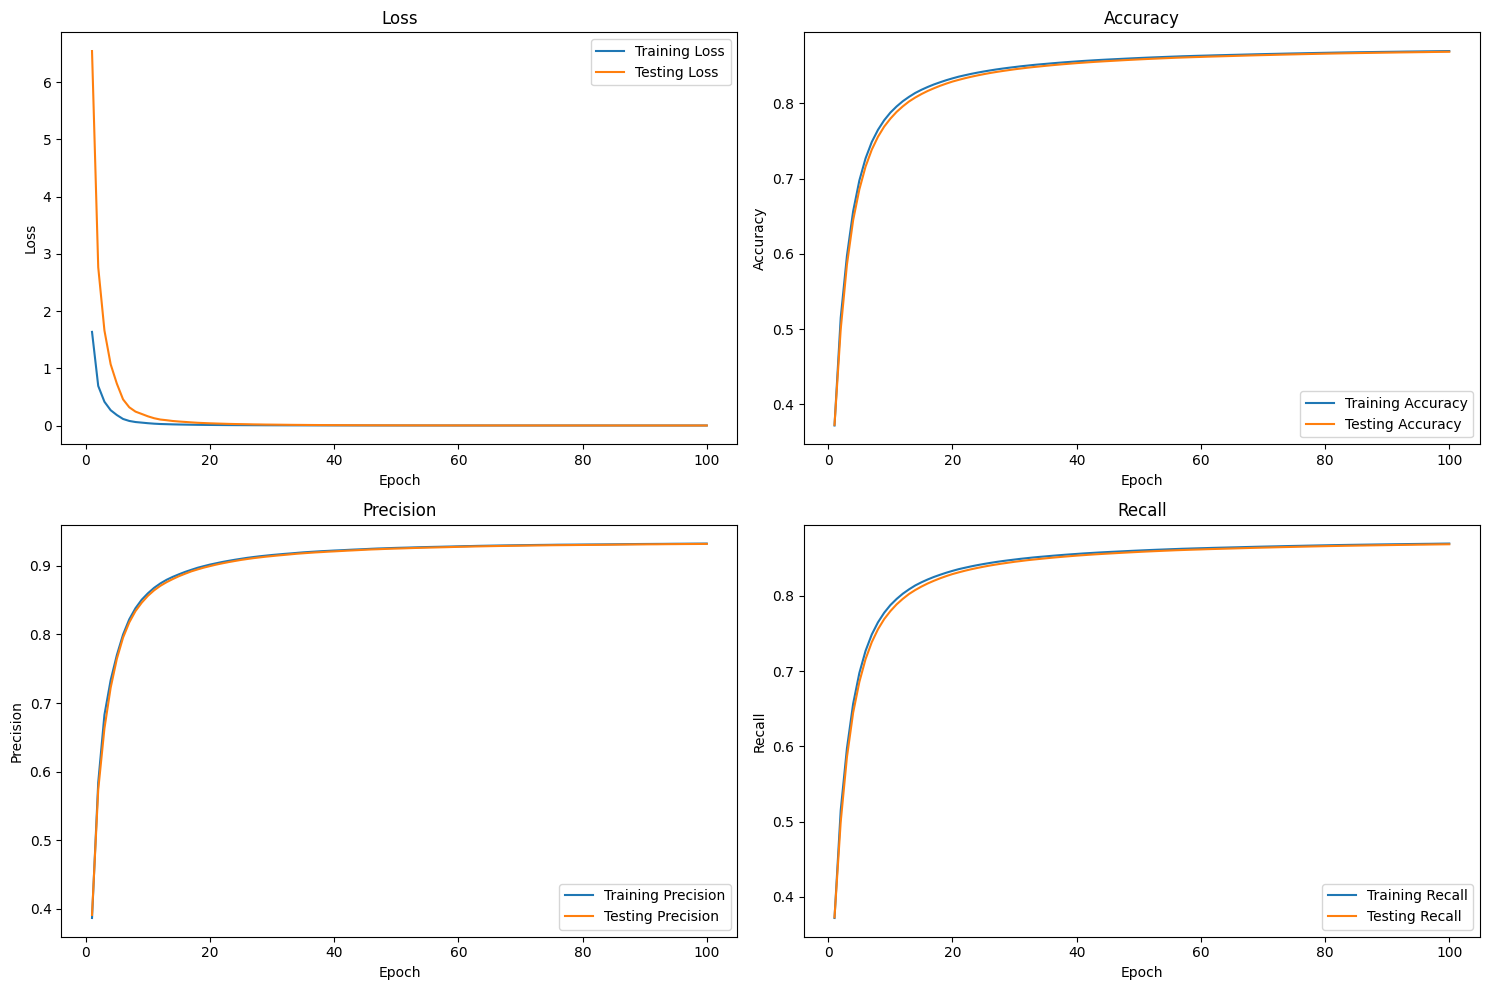

In [82]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [83]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Otras enfermedades o anormalidades
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### VGGnet16 con feature extraction y clasificador conjunto de capas

In [7]:
torch.cuda.empty_cache() 


class VGGNetFeatureExtraction(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFeatureExtraction, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG16
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x

/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.7733, Training Accuracy: 0.2783, Training Precision: 0.2823, Training Recall: 0.2783


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 7.0930, Testing Accuracy: 0.2853, Testing Precision: 0.2971, Testing Recall: 0.2853


Training Epoch 2/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.3958, Training Accuracy: 0.3093, Training Precision: 0.3526, Training Recall: 0.3093


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5831, Testing Accuracy: 0.3144, Testing Precision: 0.3586, Testing Recall: 0.3144


Training Epoch 3/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3829, Training Accuracy: 0.3257, Training Precision: 0.3765, Training Recall: 0.3257


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5318, Testing Accuracy: 0.3274, Testing Precision: 0.3785, Testing Recall: 0.3274


Training Epoch 4/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3025, Training Accuracy: 0.3403, Training Precision: 0.4084, Training Recall: 0.3403


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 5.2101, Testing Accuracy: 0.3420, Testing Precision: 0.4083, Testing Recall: 0.3420


Training Epoch 5/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.2628, Training Accuracy: 0.3487, Training Precision: 0.4272, Training Recall: 0.3487


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 5.0510, Testing Accuracy: 0.3488, Testing Precision: 0.4285, Testing Recall: 0.3488


Training Epoch 6/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.2163, Training Accuracy: 0.3540, Training Precision: 0.4516, Training Recall: 0.3540


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 4.8651, Testing Accuracy: 0.3536, Testing Precision: 0.4523, Testing Recall: 0.3536


Training Epoch 7/100: 100%|████████████████| 160/160 [00:40<00:00,  3.97batch/s]


Training Loss: 1.1747, Training Accuracy: 0.3587, Training Precision: 0.4684, Training Recall: 0.3587


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 4.6987, Testing Accuracy: 0.3593, Testing Precision: 0.4675, Testing Recall: 0.3593


Training Epoch 8/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1529, Training Accuracy: 0.3654, Training Precision: 0.4842, Training Recall: 0.3654


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.6118, Testing Accuracy: 0.3654, Testing Precision: 0.4845, Testing Recall: 0.3654


Training Epoch 9/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1484, Training Accuracy: 0.3697, Training Precision: 0.4981, Training Recall: 0.3697


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.5937, Testing Accuracy: 0.3693, Testing Precision: 0.4987, Testing Recall: 0.3693


Training Epoch 10/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0781, Training Accuracy: 0.3735, Training Precision: 0.5116, Training Recall: 0.3735


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.3124, Testing Accuracy: 0.3733, Testing Precision: 0.5115, Testing Recall: 0.3733


Training Epoch 11/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 1.0695, Training Accuracy: 0.3774, Training Precision: 0.5236, Training Recall: 0.3774


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.2781, Testing Accuracy: 0.3765, Testing Precision: 0.5229, Testing Recall: 0.3765


Training Epoch 12/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0403, Training Accuracy: 0.3806, Training Precision: 0.5325, Training Recall: 0.3806


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.1614, Testing Accuracy: 0.3806, Testing Precision: 0.5317, Testing Recall: 0.3806


Training Epoch 13/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9482, Training Accuracy: 0.3868, Training Precision: 0.5429, Training Recall: 0.3868


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.7929, Testing Accuracy: 0.3864, Testing Precision: 0.5427, Testing Recall: 0.3864


Training Epoch 14/100: 100%|███████████████| 160/160 [00:40<00:00,  3.98batch/s]


Training Loss: 0.9495, Training Accuracy: 0.3914, Training Precision: 0.5531, Training Recall: 0.3914


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 3.7979, Testing Accuracy: 0.3913, Testing Precision: 0.5524, Testing Recall: 0.3913


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.9552, Training Accuracy: 0.3945, Training Precision: 0.5591, Training Recall: 0.3945


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.8208, Testing Accuracy: 0.3941, Testing Precision: 0.5591, Testing Recall: 0.3941


Training Epoch 16/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 1.0189, Training Accuracy: 0.3962, Training Precision: 0.5626, Training Recall: 0.3962


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 4.0757, Testing Accuracy: 0.3955, Testing Precision: 0.5623, Testing Recall: 0.3955


Training Epoch 17/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0099, Training Accuracy: 0.3980, Training Precision: 0.5670, Training Recall: 0.3980


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 4.0396, Testing Accuracy: 0.3976, Testing Precision: 0.5663, Testing Recall: 0.3976


Training Epoch 18/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.9479, Training Accuracy: 0.4006, Training Precision: 0.5704, Training Recall: 0.4006


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.7914, Testing Accuracy: 0.4001, Testing Precision: 0.5672, Testing Recall: 0.4001


Training Epoch 19/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9205, Training Accuracy: 0.4028, Training Precision: 0.5724, Training Recall: 0.4028


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.6820, Testing Accuracy: 0.4022, Testing Precision: 0.5721, Testing Recall: 0.4022


Training Epoch 20/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.9165, Training Accuracy: 0.4044, Training Precision: 0.5776, Training Recall: 0.4044


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.6662, Testing Accuracy: 0.4042, Testing Precision: 0.5764, Testing Recall: 0.4042


Training Epoch 21/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8855, Training Accuracy: 0.4084, Training Precision: 0.5832, Training Recall: 0.4084


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.5421, Testing Accuracy: 0.4078, Testing Precision: 0.5828, Testing Recall: 0.4078


Training Epoch 22/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8644, Training Accuracy: 0.4119, Training Precision: 0.5879, Training Recall: 0.4119


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.4577, Testing Accuracy: 0.4115, Testing Precision: 0.5872, Testing Recall: 0.4115


Training Epoch 23/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8807, Training Accuracy: 0.4147, Training Precision: 0.5924, Training Recall: 0.4147


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.5229, Testing Accuracy: 0.4145, Testing Precision: 0.5913, Testing Recall: 0.4145


Training Epoch 24/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8614, Training Accuracy: 0.4184, Training Precision: 0.5969, Training Recall: 0.4184


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.4456, Testing Accuracy: 0.4178, Testing Precision: 0.5961, Testing Recall: 0.4178


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.8574, Training Accuracy: 0.4208, Training Precision: 0.6010, Training Recall: 0.4208


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.4296, Testing Accuracy: 0.4204, Testing Precision: 0.6004, Testing Recall: 0.4204


Training Epoch 26/100: 100%|███████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 0.8009, Training Accuracy: 0.4244, Training Precision: 0.6065, Training Recall: 0.4244


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.2035, Testing Accuracy: 0.4243, Testing Precision: 0.6054, Testing Recall: 0.4243


Training Epoch 27/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8329, Training Accuracy: 0.4280, Training Precision: 0.6109, Training Recall: 0.4280


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 3.3317, Testing Accuracy: 0.4277, Testing Precision: 0.6096, Testing Recall: 0.4277


Training Epoch 28/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8508, Training Accuracy: 0.4308, Training Precision: 0.6147, Training Recall: 0.4308


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.4033, Testing Accuracy: 0.4305, Testing Precision: 0.6139, Testing Recall: 0.4305


Training Epoch 29/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7778, Training Accuracy: 0.4346, Training Precision: 0.6200, Training Recall: 0.4346


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.1112, Testing Accuracy: 0.4341, Testing Precision: 0.6193, Testing Recall: 0.4341


Training Epoch 30/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8092, Training Accuracy: 0.4375, Training Precision: 0.6244, Training Recall: 0.4375


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.2368, Testing Accuracy: 0.4370, Testing Precision: 0.6239, Testing Recall: 0.4370


Training Epoch 31/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7771, Training Accuracy: 0.4407, Training Precision: 0.6297, Training Recall: 0.4407


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.1083, Testing Accuracy: 0.4403, Testing Precision: 0.6290, Testing Recall: 0.4403


Training Epoch 32/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8475, Training Accuracy: 0.4426, Training Precision: 0.6329, Training Recall: 0.4426


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.3901, Testing Accuracy: 0.4421, Testing Precision: 0.6323, Testing Recall: 0.4421


Training Epoch 33/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7921, Training Accuracy: 0.4451, Training Precision: 0.6370, Training Recall: 0.4451


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.1686, Testing Accuracy: 0.4448, Testing Precision: 0.6363, Testing Recall: 0.4448


Training Epoch 34/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8031, Training Accuracy: 0.4477, Training Precision: 0.6398, Training Recall: 0.4477


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.2125, Testing Accuracy: 0.4472, Testing Precision: 0.6395, Testing Recall: 0.4472


Training Epoch 35/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8277, Training Accuracy: 0.4493, Training Precision: 0.6437, Training Recall: 0.4493


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.3109, Testing Accuracy: 0.4488, Testing Precision: 0.6434, Testing Recall: 0.4488


Training Epoch 36/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7585, Training Accuracy: 0.4519, Training Precision: 0.6456, Training Recall: 0.4519


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.0341, Testing Accuracy: 0.4515, Testing Precision: 0.6452, Testing Recall: 0.4515


Training Epoch 37/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7632, Training Accuracy: 0.4541, Training Precision: 0.6491, Training Recall: 0.4541


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.0530, Testing Accuracy: 0.4539, Testing Precision: 0.6486, Testing Recall: 0.4539


Training Epoch 38/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8036, Training Accuracy: 0.4561, Training Precision: 0.6520, Training Recall: 0.4561


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.2144, Testing Accuracy: 0.4558, Testing Precision: 0.6516, Testing Recall: 0.4558


Training Epoch 39/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.7735, Training Accuracy: 0.4581, Training Precision: 0.6547, Training Recall: 0.4581


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.0942, Testing Accuracy: 0.4577, Testing Precision: 0.6543, Testing Recall: 0.4577


Training Epoch 40/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8003, Training Accuracy: 0.4598, Training Precision: 0.6578, Training Recall: 0.4598


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 3.2011, Testing Accuracy: 0.4593, Testing Precision: 0.6574, Testing Recall: 0.4593


Training Epoch 41/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8137, Training Accuracy: 0.4602, Training Precision: 0.6595, Training Recall: 0.4602


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]

Testing Loss: 3.2547, Testing Accuracy: 0.4597, Testing Precision: 0.6589, Testing Recall: 0.4597
No improvement for 5 epochs. Early stopping...


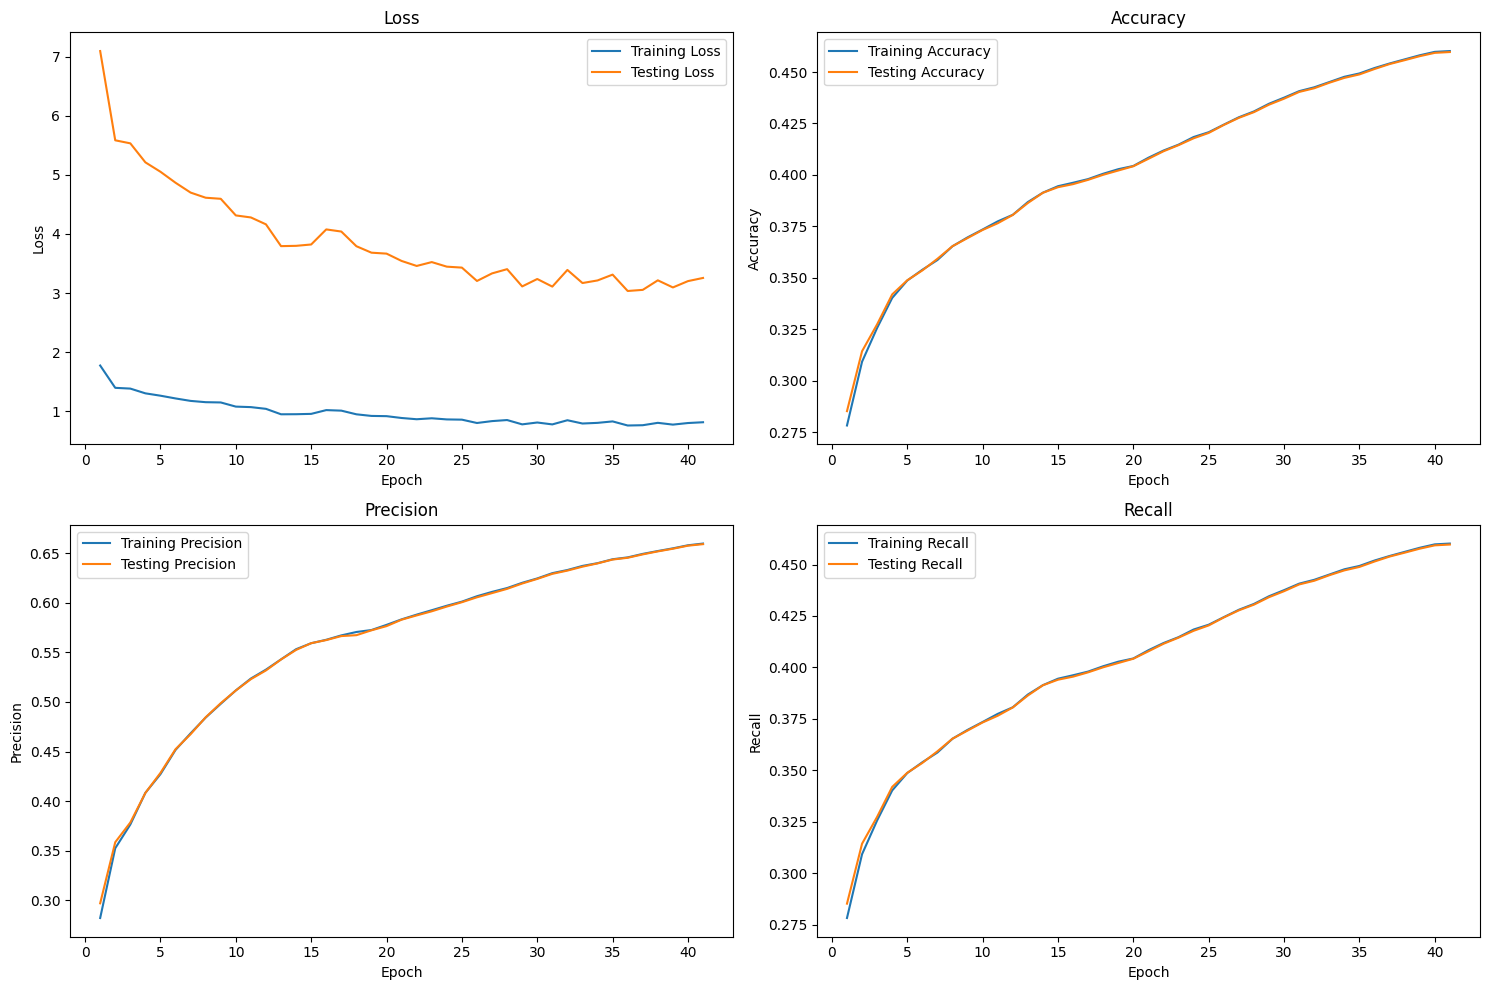

In [9]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [10]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Hipertensión, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Hipertensión


### VGGnet19 con fine tunning

In [20]:
torch.cuda.empty_cache()

class VGGNet19FineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet19FineTuning, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = True
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [21]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100:  99%|███████████████▉| 159/160 [01:32<00:00,  1.69batch/s]/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 620.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 614.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU  (Trigger

Training Loss: 1.6370, Training Accuracy: 0.1249, Training Precision: 0.1150, Training Recall: 0.1249


Testing Epoch 1/100:   0%|                            | 0/40 [00:00<?, ?batch/s]/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 394.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 786.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudn

Testing Loss: 6.5481, Testing Accuracy: 0.1250, Testing Precision: 0.1156, Testing Recall: 0.1250


Training Epoch 2/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5878, Training Accuracy: 0.1248, Training Precision: 0.1143, Training Recall: 0.1248


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 6.3514, Testing Accuracy: 0.1248, Testing Precision: 0.1145, Testing Recall: 0.1248


Training Epoch 3/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5850, Training Accuracy: 0.1248, Training Precision: 0.1140, Training Recall: 0.1248


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 6.3399, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 4/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5829, Training Accuracy: 0.1249, Training Precision: 0.1140, Training Recall: 0.1249


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.64batch/s]


Testing Loss: 6.3317, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 5/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5809, Training Accuracy: 0.1249, Training Precision: 0.1140, Training Recall: 0.1249


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 6.3237, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 6/100: 100%|████████████████| 160/160 [01:35<00:00,  1.67batch/s]


Training Loss: 1.5809, Training Accuracy: 0.1249, Training Precision: 0.1141, Training Recall: 0.1249


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 6.3235, Testing Accuracy: 0.1249, Testing Precision: 0.1142, Testing Recall: 0.1249


Training Epoch 7/100: 100%|████████████████| 160/160 [01:35<00:00,  1.67batch/s]


Training Loss: 1.5799, Training Accuracy: 0.1249, Training Precision: 0.1145, Training Recall: 0.1249


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 6.3196, Testing Accuracy: 0.1249, Testing Precision: 0.1146, Testing Recall: 0.1249


Training Epoch 8/100: 100%|████████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5811, Training Accuracy: 0.1249, Training Precision: 0.1144, Training Recall: 0.1249


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 6.3243, Testing Accuracy: 0.1249, Testing Precision: 0.1145, Testing Recall: 0.1249


Training Epoch 9/100: 100%|████████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5771, Training Accuracy: 0.1250, Training Precision: 0.1144, Training Recall: 0.1250


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 6.3083, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 10/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5795, Training Accuracy: 0.1250, Training Precision: 0.1144, Training Recall: 0.1250


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 6.3179, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 11/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5810, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 6.3239, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 12/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5790, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 6.3161, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 13/100: 100%|███████████████| 160/160 [01:36<00:00,  1.67batch/s]


Training Loss: 1.5793, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 6.3173, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 14/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5787, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.56batch/s]

Testing Loss: 6.3146, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250
No improvement for 5 epochs. Early stopping...


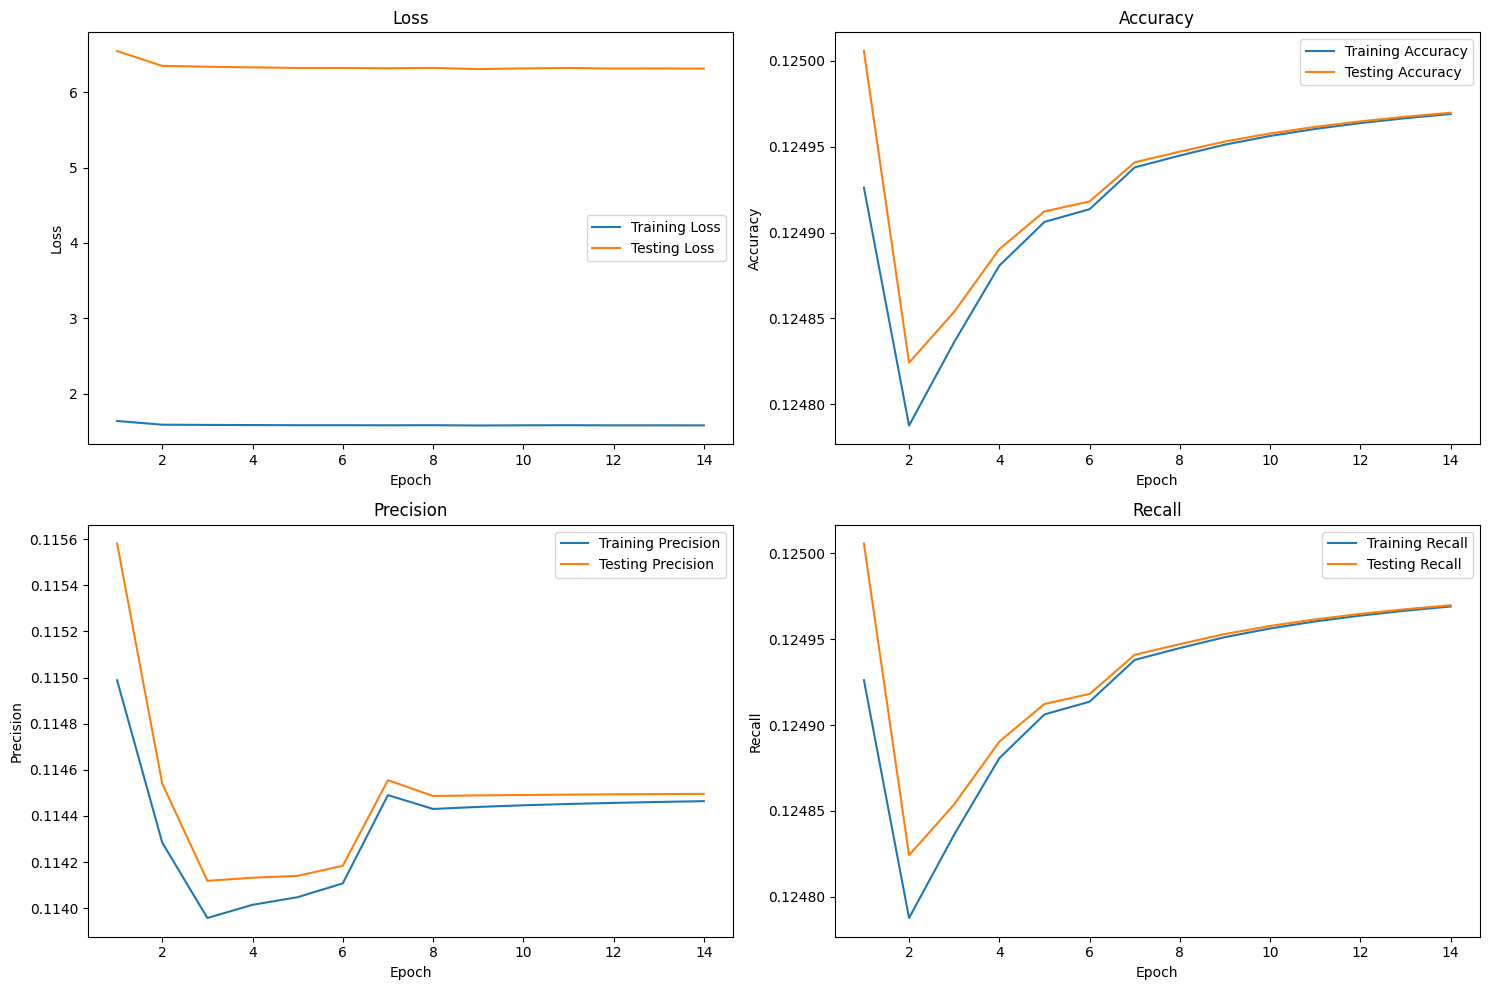

In [22]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [23]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal


### VGG19 con FeatureExtraction clasificador lineal

In [32]:
torch.cuda.empty_cache() 


class VGGNet19FeatureExtractionND(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet19FeatureExtractionND, self).__init__()
        vgg = models.vgg19(models.VGG19_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG16
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Linear(in_features=25088, out_features=num_classes)
      
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x

In [85]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FeatureExtractionND(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:43<00:00,  3.72batch/s]


Training Loss: 1.6758, Training Accuracy: 0.3606, Training Precision: 0.3795, Training Recall: 0.3606


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.76batch/s]


Testing Loss: 6.7032, Testing Accuracy: 0.3640, Testing Precision: 0.3838, Testing Recall: 0.3640


Training Epoch 2/100: 100%|████████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.8148, Training Accuracy: 0.4848, Training Precision: 0.5445, Training Recall: 0.4848


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.57batch/s]


Testing Loss: 3.2592, Testing Accuracy: 0.4770, Testing Precision: 0.5393, Testing Recall: 0.4770


Training Epoch 3/100: 100%|████████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.5191, Training Accuracy: 0.5651, Training Precision: 0.6386, Training Recall: 0.5651


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 2.0765, Testing Accuracy: 0.5518, Testing Precision: 0.6350, Testing Recall: 0.5518


Training Epoch 4/100: 100%|████████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.3561, Training Accuracy: 0.6210, Training Precision: 0.7064, Training Recall: 0.6210


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 1.4243, Testing Accuracy: 0.6112, Testing Precision: 0.6939, Testing Recall: 0.6112


Training Epoch 5/100: 100%|████████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.2695, Training Accuracy: 0.6635, Training Precision: 0.7432, Training Recall: 0.6635


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 1.0778, Testing Accuracy: 0.6529, Testing Precision: 0.7357, Testing Recall: 0.6529


Training Epoch 6/100: 100%|████████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.1807, Training Accuracy: 0.6965, Training Precision: 0.7738, Training Recall: 0.6965


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.71batch/s]


Testing Loss: 0.7230, Testing Accuracy: 0.6853, Testing Precision: 0.7704, Testing Recall: 0.6853


Training Epoch 7/100: 100%|████████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.1391, Training Accuracy: 0.7198, Training Precision: 0.7991, Training Recall: 0.7198


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 0.5565, Testing Accuracy: 0.7102, Testing Precision: 0.7937, Testing Recall: 0.7102


Training Epoch 8/100: 100%|████████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.1214, Training Accuracy: 0.7382, Training Precision: 0.8163, Training Recall: 0.7382


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 0.4855, Testing Accuracy: 0.7294, Testing Precision: 0.8118, Testing Recall: 0.7294


Training Epoch 9/100: 100%|████████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0900, Training Accuracy: 0.7533, Training Precision: 0.8304, Training Recall: 0.7533


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 0.3601, Testing Accuracy: 0.7451, Testing Precision: 0.8254, Testing Recall: 0.7451


Training Epoch 10/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0760, Training Accuracy: 0.7654, Training Precision: 0.8408, Training Recall: 0.7654


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.47batch/s]


Testing Loss: 0.3039, Testing Accuracy: 0.7577, Testing Precision: 0.8359, Testing Recall: 0.7577


Training Epoch 11/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0560, Training Accuracy: 0.7754, Training Precision: 0.8492, Training Recall: 0.7754


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.65batch/s]


Testing Loss: 0.2239, Testing Accuracy: 0.7682, Testing Precision: 0.8459, Testing Recall: 0.7682


Training Epoch 12/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0478, Training Accuracy: 0.7837, Training Precision: 0.8573, Training Recall: 0.7837


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.53batch/s]


Testing Loss: 0.1911, Testing Accuracy: 0.7771, Testing Precision: 0.8540, Testing Recall: 0.7771


Training Epoch 13/100: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0386, Training Accuracy: 0.7909, Training Precision: 0.8640, Training Recall: 0.7909


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 0.1543, Testing Accuracy: 0.7847, Testing Precision: 0.8602, Testing Recall: 0.7847


Training Epoch 14/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0340, Training Accuracy: 0.7970, Training Precision: 0.8690, Training Recall: 0.7970


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.1360, Testing Accuracy: 0.7913, Testing Precision: 0.8656, Testing Recall: 0.7913


Training Epoch 15/100: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0328, Training Accuracy: 0.8025, Training Precision: 0.8735, Training Recall: 0.8025


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.56batch/s]


Testing Loss: 0.1311, Testing Accuracy: 0.7969, Testing Precision: 0.8704, Testing Recall: 0.7969


Training Epoch 16/100: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0264, Training Accuracy: 0.8071, Training Precision: 0.8775, Training Recall: 0.8071


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.73batch/s]


Testing Loss: 0.1057, Testing Accuracy: 0.8018, Testing Precision: 0.8748, Testing Recall: 0.8018


Training Epoch 17/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0225, Training Accuracy: 0.8111, Training Precision: 0.8812, Training Recall: 0.8111


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.58batch/s]


Testing Loss: 0.0899, Testing Accuracy: 0.8061, Testing Precision: 0.8785, Testing Recall: 0.8061


Training Epoch 18/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0202, Training Accuracy: 0.8147, Training Precision: 0.8844, Training Recall: 0.8147


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 0.0807, Testing Accuracy: 0.8100, Testing Precision: 0.8819, Testing Recall: 0.8100


Training Epoch 19/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0186, Training Accuracy: 0.8180, Training Precision: 0.8873, Training Recall: 0.8180


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.56batch/s]


Testing Loss: 0.0743, Testing Accuracy: 0.8135, Testing Precision: 0.8846, Testing Recall: 0.8135


Training Epoch 20/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0160, Training Accuracy: 0.8209, Training Precision: 0.8896, Training Recall: 0.8209


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 0.0641, Testing Accuracy: 0.8165, Testing Precision: 0.8875, Testing Recall: 0.8165


Training Epoch 21/100: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0146, Training Accuracy: 0.8235, Training Precision: 0.8922, Training Recall: 0.8235


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 0.0583, Testing Accuracy: 0.8193, Testing Precision: 0.8900, Testing Recall: 0.8193


Training Epoch 22/100: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0131, Training Accuracy: 0.8259, Training Precision: 0.8943, Training Recall: 0.8259


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 0.0525, Testing Accuracy: 0.8219, Testing Precision: 0.8921, Testing Recall: 0.8219


Training Epoch 23/100: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0124, Training Accuracy: 0.8281, Training Precision: 0.8961, Training Recall: 0.8281


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 0.0494, Testing Accuracy: 0.8243, Testing Precision: 0.8940, Testing Recall: 0.8243


Training Epoch 24/100: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0109, Training Accuracy: 0.8301, Training Precision: 0.8978, Training Recall: 0.8301


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.73batch/s]


Testing Loss: 0.0436, Testing Accuracy: 0.8264, Testing Precision: 0.8959, Testing Recall: 0.8264


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0099, Training Accuracy: 0.8319, Training Precision: 0.8995, Training Recall: 0.8319


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0397, Testing Accuracy: 0.8285, Testing Precision: 0.8973, Testing Recall: 0.8285


Training Epoch 26/100: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0090, Training Accuracy: 0.8338, Training Precision: 0.9007, Training Recall: 0.8338


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0362, Testing Accuracy: 0.8304, Testing Precision: 0.8987, Testing Recall: 0.8304


Training Epoch 27/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0084, Training Accuracy: 0.8354, Training Precision: 0.9019, Training Recall: 0.8354


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.77batch/s]


Testing Loss: 0.0335, Testing Accuracy: 0.8321, Testing Precision: 0.9000, Testing Recall: 0.8321


Training Epoch 28/100: 100%|███████████████| 160/160 [00:42<00:00,  3.81batch/s]


Training Loss: 0.0077, Training Accuracy: 0.8369, Training Precision: 0.9031, Training Recall: 0.8369


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0307, Testing Accuracy: 0.8338, Testing Precision: 0.9010, Testing Recall: 0.8338


Training Epoch 29/100: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0069, Training Accuracy: 0.8384, Training Precision: 0.9040, Training Recall: 0.8384


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.77batch/s]


Testing Loss: 0.0275, Testing Accuracy: 0.8353, Testing Precision: 0.9022, Testing Recall: 0.8353


Training Epoch 30/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0065, Training Accuracy: 0.8396, Training Precision: 0.9050, Training Recall: 0.8396


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0259, Testing Accuracy: 0.8367, Testing Precision: 0.9032, Testing Recall: 0.8367


Training Epoch 31/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0057, Training Accuracy: 0.8409, Training Precision: 0.9059, Training Recall: 0.8409


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0229, Testing Accuracy: 0.8380, Testing Precision: 0.9043, Testing Recall: 0.8380


Training Epoch 32/100: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0055, Training Accuracy: 0.8420, Training Precision: 0.9068, Training Recall: 0.8420


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0219, Testing Accuracy: 0.8392, Testing Precision: 0.9051, Testing Recall: 0.8392


Training Epoch 33/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0049, Training Accuracy: 0.8430, Training Precision: 0.9076, Training Recall: 0.8430


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0194, Testing Accuracy: 0.8403, Testing Precision: 0.9062, Testing Recall: 0.8403


Training Epoch 34/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0046, Training Accuracy: 0.8440, Training Precision: 0.9085, Training Recall: 0.8440


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 0.0182, Testing Accuracy: 0.8414, Testing Precision: 0.9071, Testing Recall: 0.8414


Training Epoch 35/100: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0042, Training Accuracy: 0.8450, Training Precision: 0.9093, Training Recall: 0.8450


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 0.0168, Testing Accuracy: 0.8424, Testing Precision: 0.9078, Testing Recall: 0.8424


Training Epoch 36/100: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0038, Training Accuracy: 0.8459, Training Precision: 0.9100, Training Recall: 0.8459


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.0154, Testing Accuracy: 0.8433, Testing Precision: 0.9086, Testing Recall: 0.8433


Training Epoch 37/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0035, Training Accuracy: 0.8467, Training Precision: 0.9107, Training Recall: 0.8467


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0139, Testing Accuracy: 0.8442, Testing Precision: 0.9093, Testing Recall: 0.8442


Training Epoch 38/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8475, Training Precision: 0.9113, Training Recall: 0.8475


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.0129, Testing Accuracy: 0.8451, Testing Precision: 0.9099, Testing Recall: 0.8451


Training Epoch 39/100: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8483, Training Precision: 0.9118, Training Recall: 0.8483


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8459, Testing Precision: 0.9105, Testing Recall: 0.8459


Training Epoch 40/100: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8490, Training Precision: 0.9124, Training Recall: 0.8490


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 0.0122, Testing Accuracy: 0.8467, Testing Precision: 0.9111, Testing Recall: 0.8467


Training Epoch 41/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8496, Training Precision: 0.9130, Training Recall: 0.8496


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8474, Testing Precision: 0.9116, Testing Recall: 0.8474


Training Epoch 42/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0024, Training Accuracy: 0.8503, Training Precision: 0.9134, Training Recall: 0.8503


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.75batch/s]


Testing Loss: 0.0094, Testing Accuracy: 0.8481, Testing Precision: 0.9122, Testing Recall: 0.8481


Training Epoch 43/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0021, Training Accuracy: 0.8509, Training Precision: 0.9139, Training Recall: 0.8509


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.76batch/s]


Testing Loss: 0.0086, Testing Accuracy: 0.8488, Testing Precision: 0.9127, Testing Recall: 0.8488


Training Epoch 44/100: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0021, Training Accuracy: 0.8515, Training Precision: 0.9144, Training Recall: 0.8515


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.74batch/s]


Testing Loss: 0.0082, Testing Accuracy: 0.8494, Testing Precision: 0.9131, Testing Recall: 0.8494


Training Epoch 45/100: 100%|███████████████| 160/160 [00:43<00:00,  3.72batch/s]


Training Loss: 0.0018, Training Accuracy: 0.8521, Training Precision: 0.9148, Training Recall: 0.8521


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 0.0074, Testing Accuracy: 0.8500, Testing Precision: 0.9136, Testing Recall: 0.8500


Training Epoch 46/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0017, Training Accuracy: 0.8526, Training Precision: 0.9152, Training Recall: 0.8526


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 0.0067, Testing Accuracy: 0.8506, Testing Precision: 0.9140, Testing Recall: 0.8506


Training Epoch 47/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0016, Training Accuracy: 0.8531, Training Precision: 0.9155, Training Recall: 0.8531


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0063, Testing Accuracy: 0.8511, Testing Precision: 0.9144, Testing Recall: 0.8511


Training Epoch 48/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0015, Training Accuracy: 0.8536, Training Precision: 0.9159, Training Recall: 0.8536


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.70batch/s]


Testing Loss: 0.0059, Testing Accuracy: 0.8517, Testing Precision: 0.9148, Testing Recall: 0.8517


Training Epoch 49/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8541, Training Precision: 0.9163, Training Recall: 0.8541


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0055, Testing Accuracy: 0.8522, Testing Precision: 0.9151, Testing Recall: 0.8522


Training Epoch 50/100: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0013, Training Accuracy: 0.8546, Training Precision: 0.9166, Training Recall: 0.8546


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0050, Testing Accuracy: 0.8527, Testing Precision: 0.9155, Testing Recall: 0.8527


Training Epoch 51/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8550, Training Precision: 0.9169, Training Recall: 0.8550


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0046, Testing Accuracy: 0.8532, Testing Precision: 0.9158, Testing Recall: 0.8532


Training Epoch 52/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8554, Training Precision: 0.9172, Training Recall: 0.8554


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.75batch/s]


Testing Loss: 0.0041, Testing Accuracy: 0.8536, Testing Precision: 0.9162, Testing Recall: 0.8536


Training Epoch 53/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8558, Training Precision: 0.9175, Training Recall: 0.8558


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0039, Testing Accuracy: 0.8541, Testing Precision: 0.9165, Testing Recall: 0.8541


Training Epoch 54/100: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8562, Training Precision: 0.9178, Training Recall: 0.8562


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 0.0036, Testing Accuracy: 0.8545, Testing Precision: 0.9168, Testing Recall: 0.8545


Training Epoch 55/100: 100%|███████████████| 160/160 [00:42<00:00,  3.81batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8566, Training Precision: 0.9181, Training Recall: 0.8566


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0034, Testing Accuracy: 0.8549, Testing Precision: 0.9171, Testing Recall: 0.8549


Training Epoch 56/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8569, Training Precision: 0.9183, Training Recall: 0.8569


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0030, Testing Accuracy: 0.8553, Testing Precision: 0.9175, Testing Recall: 0.8553


Training Epoch 57/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8573, Training Precision: 0.9187, Training Recall: 0.8573


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 0.0029, Testing Accuracy: 0.8557, Testing Precision: 0.9177, Testing Recall: 0.8557


Training Epoch 58/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8577, Training Precision: 0.9189, Training Recall: 0.8577


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0025, Testing Accuracy: 0.8561, Testing Precision: 0.9180, Testing Recall: 0.8561


Training Epoch 59/100: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8580, Training Precision: 0.9192, Training Recall: 0.8580


Testing Epoch 59/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0024, Testing Accuracy: 0.8564, Testing Precision: 0.9183, Testing Recall: 0.8564


Training Epoch 60/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8583, Training Precision: 0.9194, Training Recall: 0.8583


Testing Epoch 60/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0022, Testing Accuracy: 0.8568, Testing Precision: 0.9185, Testing Recall: 0.8568


Training Epoch 61/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8587, Training Precision: 0.9197, Training Recall: 0.8587


Testing Epoch 61/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0021, Testing Accuracy: 0.8571, Testing Precision: 0.9187, Testing Recall: 0.8571


Training Epoch 62/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8590, Training Precision: 0.9199, Training Recall: 0.8590


Testing Epoch 62/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0020, Testing Accuracy: 0.8575, Testing Precision: 0.9190, Testing Recall: 0.8575


Training Epoch 63/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8593, Training Precision: 0.9201, Training Recall: 0.8593


Testing Epoch 63/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0018, Testing Accuracy: 0.8578, Testing Precision: 0.9192, Testing Recall: 0.8578


Training Epoch 64/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8596, Training Precision: 0.9203, Training Recall: 0.8596


Testing Epoch 64/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0016, Testing Accuracy: 0.8581, Testing Precision: 0.9194, Testing Recall: 0.8581


Training Epoch 65/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8599, Training Precision: 0.9205, Training Recall: 0.8599


Testing Epoch 65/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0015, Testing Accuracy: 0.8585, Testing Precision: 0.9196, Testing Recall: 0.8585


Training Epoch 66/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8602, Training Precision: 0.9206, Training Recall: 0.8602


Testing Epoch 66/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0014, Testing Accuracy: 0.8588, Testing Precision: 0.9199, Testing Recall: 0.8588


Training Epoch 67/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8604, Training Precision: 0.9209, Training Recall: 0.8604


Testing Epoch 67/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0013, Testing Accuracy: 0.8590, Testing Precision: 0.9201, Testing Recall: 0.8590


Training Epoch 68/100: 100%|███████████████| 160/160 [00:40<00:00,  3.90batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8607, Training Precision: 0.9211, Training Recall: 0.8607


Testing Epoch 68/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8593, Testing Precision: 0.9203, Testing Recall: 0.8593


Training Epoch 69/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8609, Training Precision: 0.9213, Training Recall: 0.8609


Testing Epoch 69/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 0.0011, Testing Accuracy: 0.8596, Testing Precision: 0.9205, Testing Recall: 0.8596


Training Epoch 70/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8612, Training Precision: 0.9215, Training Recall: 0.8612


Testing Epoch 70/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8598, Testing Precision: 0.9207, Testing Recall: 0.8598


Training Epoch 71/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8614, Training Precision: 0.9217, Training Recall: 0.8614


Testing Epoch 71/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8601, Testing Precision: 0.9208, Testing Recall: 0.8601


Training Epoch 72/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8617, Training Precision: 0.9218, Training Recall: 0.8617


Testing Epoch 72/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8604, Testing Precision: 0.9209, Testing Recall: 0.8604


Training Epoch 73/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8619, Training Precision: 0.9218, Training Recall: 0.8619


Testing Epoch 73/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8606, Testing Precision: 0.9211, Testing Recall: 0.8606


Training Epoch 74/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8621, Training Precision: 0.9220, Training Recall: 0.8621


Testing Epoch 74/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8608, Testing Precision: 0.9213, Testing Recall: 0.8608


Training Epoch 75/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8623, Training Precision: 0.9222, Training Recall: 0.8623


Testing Epoch 75/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8611, Testing Precision: 0.9214, Testing Recall: 0.8611


Training Epoch 76/100: 100%|███████████████| 160/160 [00:42<00:00,  3.72batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8625, Training Precision: 0.9223, Training Recall: 0.8625


Testing Epoch 76/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8613, Testing Precision: 0.9216, Testing Recall: 0.8613


Training Epoch 77/100: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8627, Training Precision: 0.9224, Training Recall: 0.8627


Testing Epoch 77/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.71batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8615, Testing Precision: 0.9217, Testing Recall: 0.8615


Training Epoch 78/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8629, Training Precision: 0.9226, Training Recall: 0.8629


Testing Epoch 78/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.65batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8617, Testing Precision: 0.9219, Testing Recall: 0.8617


Training Epoch 79/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8631, Training Precision: 0.9227, Training Recall: 0.8631


Testing Epoch 79/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.68batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8619, Testing Precision: 0.9220, Testing Recall: 0.8619


Training Epoch 80/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8633, Training Precision: 0.9228, Training Recall: 0.8633


Testing Epoch 80/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8621, Testing Precision: 0.9221, Testing Recall: 0.8621


Training Epoch 81/100: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8635, Training Precision: 0.9229, Training Recall: 0.8635


Testing Epoch 81/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8624, Testing Precision: 0.9222, Testing Recall: 0.8624


Training Epoch 82/100: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8637, Training Precision: 0.9230, Training Recall: 0.8637


Testing Epoch 82/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8626, Testing Precision: 0.9223, Testing Recall: 0.8626


Training Epoch 83/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8639, Training Precision: 0.9231, Training Recall: 0.8639


Testing Epoch 83/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.65batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8627, Testing Precision: 0.9224, Testing Recall: 0.8627


Training Epoch 84/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8640, Training Precision: 0.9232, Training Recall: 0.8640


Testing Epoch 84/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8629, Testing Precision: 0.9226, Testing Recall: 0.8629


Training Epoch 85/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8642, Training Precision: 0.9234, Training Recall: 0.8642


Testing Epoch 85/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.49batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8631, Testing Precision: 0.9227, Testing Recall: 0.8631


Training Epoch 86/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8644, Training Precision: 0.9235, Training Recall: 0.8644


Testing Epoch 86/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.70batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8633, Testing Precision: 0.9228, Testing Recall: 0.8633


Training Epoch 87/100: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8646, Training Precision: 0.9236, Training Recall: 0.8646


Testing Epoch 87/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8635, Testing Precision: 0.9229, Testing Recall: 0.8635


Training Epoch 88/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8647, Training Precision: 0.9237, Training Recall: 0.8647


Testing Epoch 88/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.55batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8637, Testing Precision: 0.9230, Testing Recall: 0.8637


Training Epoch 89/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8649, Training Precision: 0.9238, Training Recall: 0.8649


Testing Epoch 89/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8639, Testing Precision: 0.9231, Testing Recall: 0.8639


Training Epoch 90/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8651, Training Precision: 0.9238, Training Recall: 0.8651


Testing Epoch 90/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.51batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8640, Testing Precision: 0.9232, Testing Recall: 0.8640


Training Epoch 91/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8652, Training Precision: 0.9239, Training Recall: 0.8652


Testing Epoch 91/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8642, Testing Precision: 0.9233, Testing Recall: 0.8642


Training Epoch 92/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8654, Training Precision: 0.9240, Training Recall: 0.8654


Testing Epoch 92/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.54batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8644, Testing Precision: 0.9234, Testing Recall: 0.8644


Training Epoch 93/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8655, Training Precision: 0.9241, Training Recall: 0.8655


Testing Epoch 93/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8645, Testing Precision: 0.9235, Testing Recall: 0.8645


Training Epoch 94/100: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8656, Training Precision: 0.9242, Training Recall: 0.8656


Testing Epoch 94/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.70batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8647, Testing Precision: 0.9236, Testing Recall: 0.8647


Training Epoch 95/100: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8658, Training Precision: 0.9243, Training Recall: 0.8658


Testing Epoch 95/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8648, Testing Precision: 0.9237, Testing Recall: 0.8648


Training Epoch 96/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8659, Training Precision: 0.9243, Training Recall: 0.8659


Testing Epoch 96/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8649, Testing Precision: 0.9238, Testing Recall: 0.8649


Training Epoch 97/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8661, Training Precision: 0.9244, Training Recall: 0.8661


Testing Epoch 97/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8651, Testing Precision: 0.9239, Testing Recall: 0.8651


Training Epoch 98/100: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8662, Training Precision: 0.9245, Training Recall: 0.8662


Testing Epoch 98/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.68batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8652, Testing Precision: 0.9239, Testing Recall: 0.8652


Training Epoch 99/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8663, Training Precision: 0.9246, Training Recall: 0.8663


Testing Epoch 99/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8654, Testing Precision: 0.9240, Testing Recall: 0.8654


Training Epoch 100/100: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8664, Training Precision: 0.9246, Training Recall: 0.8664


Testing Epoch 100/100: 100%|█████████████████| 40/40 [00:11<00:00,  3.59batch/s]

Testing Loss: 0.0001, Testing Accuracy: 0.8655, Testing Precision: 0.9241, Testing Recall: 0.8655


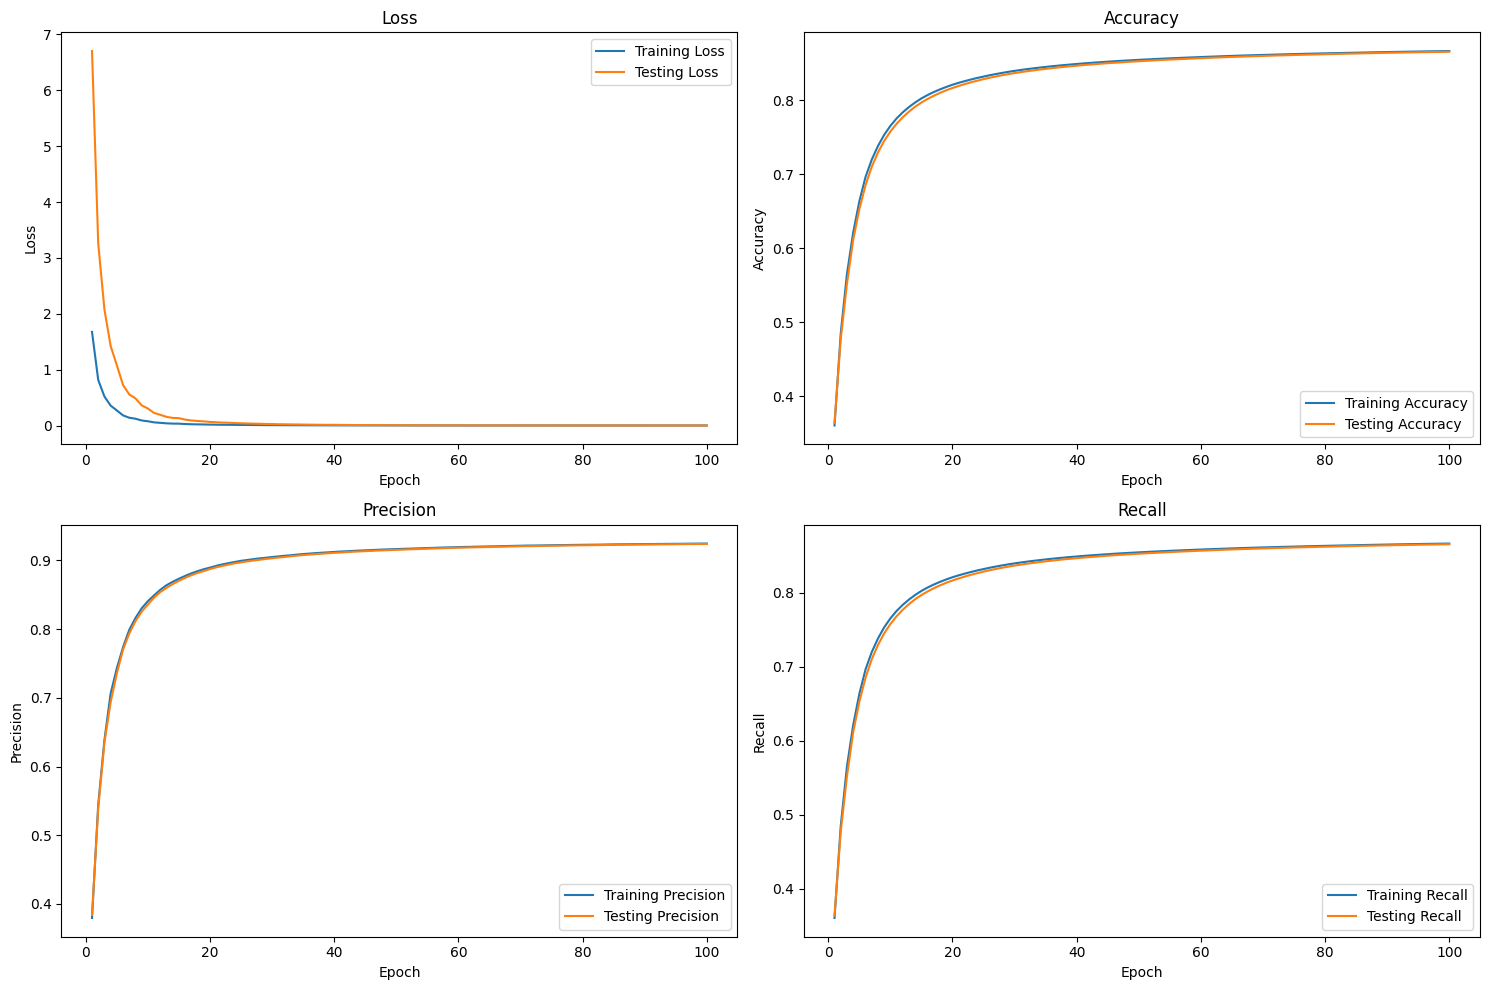

In [86]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [87]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Cataratas, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes


### VGGNet19FeatureExtraction con clasificador de conjunto de capas

In [24]:
torch.cuda.empty_cache()

class VGGNet19FeatureExtraction(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet19FeatureExtraction, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG19
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x


In [25]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.7857, Training Accuracy: 0.2822, Training Precision: 0.2851, Training Recall: 0.2822


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 7.1430, Testing Accuracy: 0.2895, Testing Precision: 0.2878, Testing Recall: 0.2895


Training Epoch 2/100: 100%|████████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.3809, Training Accuracy: 0.3117, Training Precision: 0.3471, Training Recall: 0.3117


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 5.5236, Testing Accuracy: 0.3159, Testing Precision: 0.3539, Testing Recall: 0.3159


Training Epoch 3/100: 100%|████████████████| 160/160 [00:49<00:00,  3.26batch/s]


Training Loss: 1.3799, Training Accuracy: 0.3228, Training Precision: 0.3703, Training Recall: 0.3228


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.62batch/s]


Testing Loss: 5.5198, Testing Accuracy: 0.3196, Testing Precision: 0.3728, Testing Recall: 0.3196


Training Epoch 4/100: 100%|████████████████| 160/160 [00:49<00:00,  3.23batch/s]


Training Loss: 1.3007, Training Accuracy: 0.3300, Training Precision: 0.4032, Training Recall: 0.3300


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.53batch/s]


Testing Loss: 5.2028, Testing Accuracy: 0.3311, Testing Precision: 0.4024, Testing Recall: 0.3311


Training Epoch 5/100: 100%|████████████████| 160/160 [00:49<00:00,  3.22batch/s]


Training Loss: 1.2449, Training Accuracy: 0.3375, Training Precision: 0.4157, Training Recall: 0.3375


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 4.9797, Testing Accuracy: 0.3386, Testing Precision: 0.4160, Testing Recall: 0.3386


Training Epoch 6/100: 100%|████████████████| 160/160 [00:48<00:00,  3.31batch/s]


Training Loss: 1.1792, Training Accuracy: 0.3437, Training Precision: 0.4250, Training Recall: 0.3437


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.68batch/s]


Testing Loss: 4.7167, Testing Accuracy: 0.3447, Testing Precision: 0.4264, Testing Recall: 0.3447


Training Epoch 7/100: 100%|████████████████| 160/160 [00:48<00:00,  3.33batch/s]


Training Loss: 1.1714, Training Accuracy: 0.3495, Training Precision: 0.4367, Training Recall: 0.3495


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.71batch/s]


Testing Loss: 4.6858, Testing Accuracy: 0.3500, Testing Precision: 0.4369, Testing Recall: 0.3500


Training Epoch 8/100: 100%|████████████████| 160/160 [00:48<00:00,  3.32batch/s]


Training Loss: 1.1808, Training Accuracy: 0.3537, Training Precision: 0.4509, Training Recall: 0.3537


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 4.7231, Testing Accuracy: 0.3536, Testing Precision: 0.4508, Testing Recall: 0.3536


Training Epoch 9/100: 100%|████████████████| 160/160 [00:48<00:00,  3.33batch/s]


Training Loss: 1.1786, Training Accuracy: 0.3572, Training Precision: 0.4574, Training Recall: 0.3572


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 4.7144, Testing Accuracy: 0.3568, Testing Precision: 0.4575, Testing Recall: 0.3568


Training Epoch 10/100: 100%|███████████████| 160/160 [00:48<00:00,  3.32batch/s]


Training Loss: 1.1368, Training Accuracy: 0.3602, Training Precision: 0.4700, Training Recall: 0.3602


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.72batch/s]


Testing Loss: 4.5473, Testing Accuracy: 0.3598, Testing Precision: 0.4699, Testing Recall: 0.3598


Training Epoch 11/100: 100%|███████████████| 160/160 [00:48<00:00,  3.31batch/s]


Training Loss: 1.0921, Training Accuracy: 0.3631, Training Precision: 0.4819, Training Recall: 0.3631


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 4.3684, Testing Accuracy: 0.3624, Testing Precision: 0.4820, Testing Recall: 0.3624


Training Epoch 12/100: 100%|███████████████| 160/160 [00:48<00:00,  3.30batch/s]


Training Loss: 1.0906, Training Accuracy: 0.3658, Training Precision: 0.4923, Training Recall: 0.3658


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 4.3624, Testing Accuracy: 0.3656, Testing Precision: 0.4926, Testing Recall: 0.3656


Training Epoch 13/100: 100%|███████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.0620, Training Accuracy: 0.3689, Training Precision: 0.5062, Training Recall: 0.3689


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 4.2481, Testing Accuracy: 0.3685, Testing Precision: 0.5060, Testing Recall: 0.3685


Training Epoch 14/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 1.0460, Training Accuracy: 0.3719, Training Precision: 0.5174, Training Recall: 0.3719


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 4.1838, Testing Accuracy: 0.3718, Testing Precision: 0.5167, Testing Recall: 0.3718


Training Epoch 15/100: 100%|███████████████| 160/160 [00:45<00:00,  3.52batch/s]


Training Loss: 1.1073, Training Accuracy: 0.3740, Training Precision: 0.5222, Training Recall: 0.3740


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 4.4290, Testing Accuracy: 0.3735, Testing Precision: 0.5221, Testing Recall: 0.3735


Training Epoch 16/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 1.0333, Training Accuracy: 0.3755, Training Precision: 0.5280, Training Recall: 0.3755


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 4.1334, Testing Accuracy: 0.3752, Testing Precision: 0.5279, Testing Recall: 0.3752


Training Epoch 17/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 1.0033, Training Accuracy: 0.3780, Training Precision: 0.5335, Training Recall: 0.3780


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 4.0131, Testing Accuracy: 0.3775, Testing Precision: 0.5338, Testing Recall: 0.3775


Training Epoch 18/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9853, Training Accuracy: 0.3803, Training Precision: 0.5430, Training Recall: 0.3803


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 3.9411, Testing Accuracy: 0.3801, Testing Precision: 0.5418, Testing Recall: 0.3801


Training Epoch 19/100: 100%|███████████████| 160/160 [00:46<00:00,  3.48batch/s]


Training Loss: 1.0073, Training Accuracy: 0.3824, Training Precision: 0.5482, Training Recall: 0.3824


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 4.0290, Testing Accuracy: 0.3822, Testing Precision: 0.5477, Testing Recall: 0.3822


Training Epoch 20/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 1.0222, Training Accuracy: 0.3840, Training Precision: 0.5557, Training Recall: 0.3840


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 4.0888, Testing Accuracy: 0.3837, Testing Precision: 0.5551, Testing Recall: 0.3837


Training Epoch 21/100: 100%|███████████████| 160/160 [00:46<00:00,  3.48batch/s]


Training Loss: 0.9856, Training Accuracy: 0.3859, Training Precision: 0.5623, Training Recall: 0.3859


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.9423, Testing Accuracy: 0.3855, Testing Precision: 0.5611, Testing Recall: 0.3855


Training Epoch 22/100: 100%|███████████████| 160/160 [00:46<00:00,  3.46batch/s]


Training Loss: 1.0303, Training Accuracy: 0.3869, Training Precision: 0.5651, Training Recall: 0.3869


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 4.1212, Testing Accuracy: 0.3864, Testing Precision: 0.5643, Testing Recall: 0.3864


Training Epoch 23/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9590, Training Accuracy: 0.3885, Training Precision: 0.5695, Training Recall: 0.3885


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.8360, Testing Accuracy: 0.3881, Testing Precision: 0.5684, Testing Recall: 0.3881


Training Epoch 24/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9593, Training Accuracy: 0.3898, Training Precision: 0.5748, Training Recall: 0.3898


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.8374, Testing Accuracy: 0.3894, Testing Precision: 0.5745, Testing Recall: 0.3894


Training Epoch 25/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9566, Training Accuracy: 0.3915, Training Precision: 0.5780, Training Recall: 0.3915


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 3.8266, Testing Accuracy: 0.3910, Testing Precision: 0.5774, Testing Recall: 0.3910


Training Epoch 26/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9672, Training Accuracy: 0.3927, Training Precision: 0.5824, Training Recall: 0.3927


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.8690, Testing Accuracy: 0.3921, Testing Precision: 0.5821, Testing Recall: 0.3921


Training Epoch 27/100: 100%|███████████████| 160/160 [00:46<00:00,  3.44batch/s]


Training Loss: 0.9313, Training Accuracy: 0.3941, Training Precision: 0.5860, Training Recall: 0.3941


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 3.7251, Testing Accuracy: 0.3938, Testing Precision: 0.5857, Testing Recall: 0.3938


Training Epoch 28/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9438, Training Accuracy: 0.3956, Training Precision: 0.5910, Training Recall: 0.3956


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 3.7751, Testing Accuracy: 0.3952, Testing Precision: 0.5905, Testing Recall: 0.3952


Training Epoch 29/100: 100%|███████████████| 160/160 [00:46<00:00,  3.46batch/s]


Training Loss: 0.9183, Training Accuracy: 0.3973, Training Precision: 0.5946, Training Recall: 0.3973


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.6733, Testing Accuracy: 0.3968, Testing Precision: 0.5940, Testing Recall: 0.3968


Training Epoch 30/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9187, Training Accuracy: 0.3987, Training Precision: 0.5992, Training Recall: 0.3987


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 3.6750, Testing Accuracy: 0.3983, Testing Precision: 0.5985, Testing Recall: 0.3983


Training Epoch 31/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9264, Training Accuracy: 0.3998, Training Precision: 0.6031, Training Recall: 0.3998


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 3.7055, Testing Accuracy: 0.3996, Testing Precision: 0.6022, Testing Recall: 0.3996


Training Epoch 32/100: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.8896, Training Accuracy: 0.4015, Training Precision: 0.6064, Training Recall: 0.4015


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.74batch/s]


Testing Loss: 3.5583, Testing Accuracy: 0.4012, Testing Precision: 0.6051, Testing Recall: 0.4012


Training Epoch 33/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9403, Training Accuracy: 0.4027, Training Precision: 0.6096, Training Recall: 0.4027


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 3.7612, Testing Accuracy: 0.4024, Testing Precision: 0.6091, Testing Recall: 0.4024


Training Epoch 34/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9722, Training Accuracy: 0.4037, Training Precision: 0.6124, Training Recall: 0.4037


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.8888, Testing Accuracy: 0.4031, Testing Precision: 0.6119, Testing Recall: 0.4031


Training Epoch 35/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9380, Training Accuracy: 0.4043, Training Precision: 0.6151, Training Recall: 0.4043


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.7519, Testing Accuracy: 0.4040, Testing Precision: 0.6145, Testing Recall: 0.4040


Training Epoch 36/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8812, Training Accuracy: 0.4058, Training Precision: 0.6197, Training Recall: 0.4058


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 3.5247, Testing Accuracy: 0.4054, Testing Precision: 0.6189, Testing Recall: 0.4054


Training Epoch 37/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8532, Training Accuracy: 0.4072, Training Precision: 0.6232, Training Recall: 0.4072


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.4128, Testing Accuracy: 0.4068, Testing Precision: 0.6226, Testing Recall: 0.4068


Training Epoch 38/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8206, Training Accuracy: 0.4087, Training Precision: 0.6264, Training Recall: 0.4087


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 3.2823, Testing Accuracy: 0.4085, Testing Precision: 0.6258, Testing Recall: 0.4085


Training Epoch 39/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8779, Training Accuracy: 0.4100, Training Precision: 0.6282, Training Recall: 0.4100


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 3.5116, Testing Accuracy: 0.4097, Testing Precision: 0.6276, Testing Recall: 0.4097


Training Epoch 40/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8539, Training Accuracy: 0.4113, Training Precision: 0.6315, Training Recall: 0.4113


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.4158, Testing Accuracy: 0.4109, Testing Precision: 0.6311, Testing Recall: 0.4109


Training Epoch 41/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8597, Training Accuracy: 0.4123, Training Precision: 0.6352, Training Recall: 0.4123


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.4390, Testing Accuracy: 0.4120, Testing Precision: 0.6345, Testing Recall: 0.4120


Training Epoch 42/100: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.8299, Training Accuracy: 0.4135, Training Precision: 0.6385, Training Recall: 0.4135


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.3198, Testing Accuracy: 0.4132, Testing Precision: 0.6382, Testing Recall: 0.4132


Training Epoch 43/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.8281, Training Accuracy: 0.4146, Training Precision: 0.6413, Training Recall: 0.4146


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]

Testing Loss: 3.3125, Testing Accuracy: 0.4143, Testing Precision: 0.6410, Testing Recall: 0.4143
No improvement for 5 epochs. Early stopping...


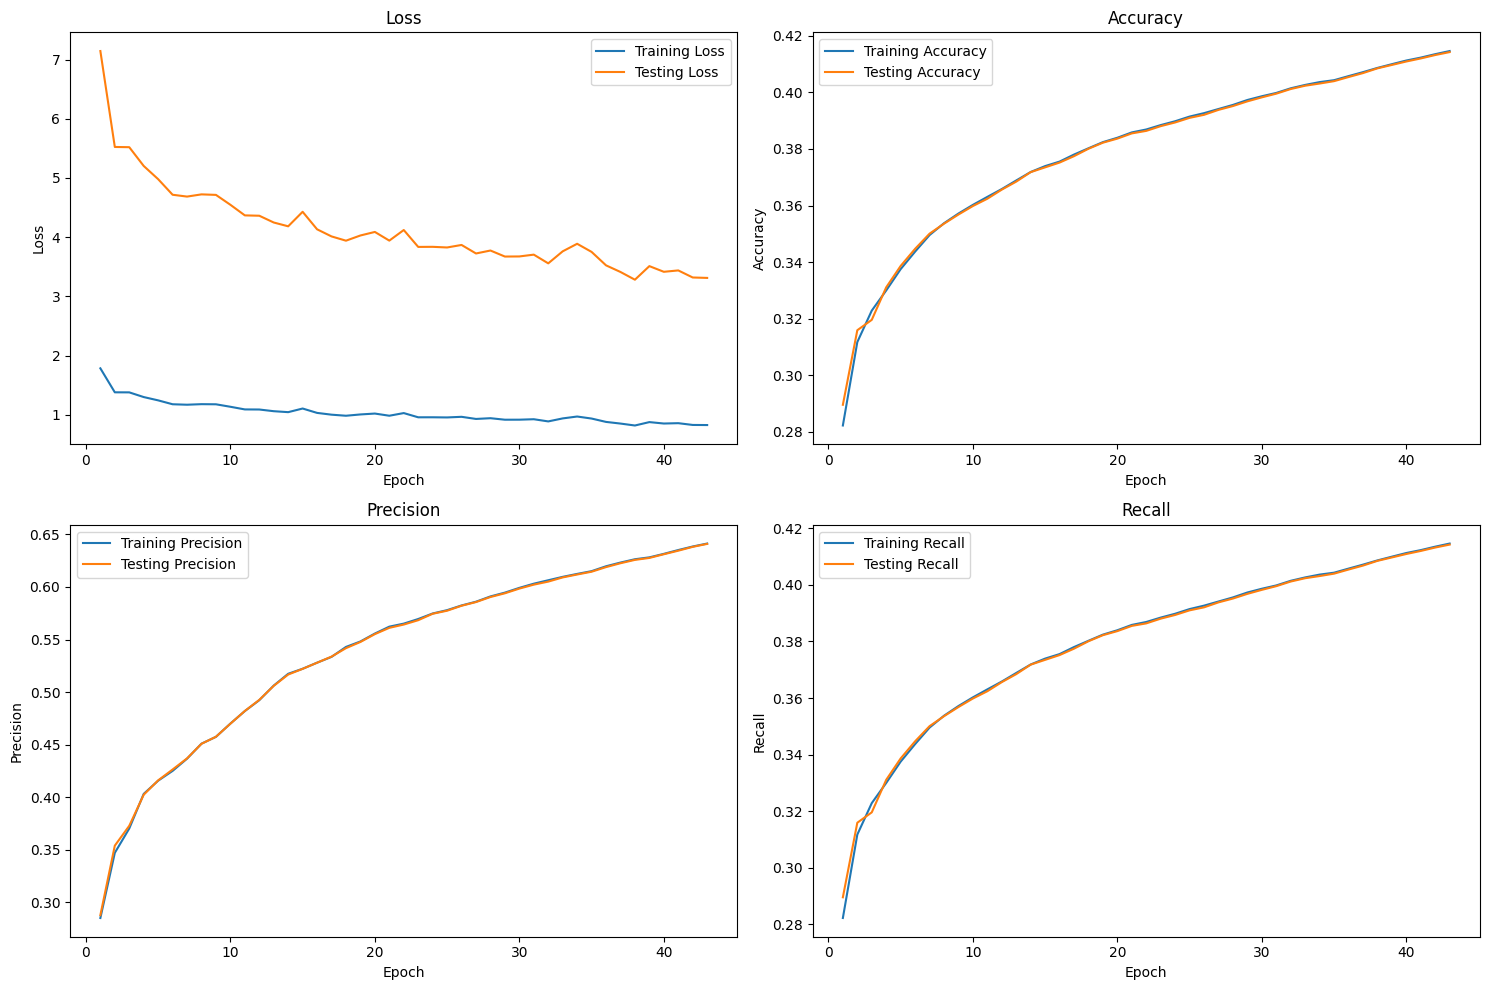

In [26]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [27]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal


### VGG16 con feature extraction y clasificador de conjunto de capas con data augmentation.

De los entrenamientos anteriores, el mejor encontrado corresponde a VGG16 con feature extraction, en este caso se agrega un entrenamiento con data augmentation para evaluar su performance.

In [14]:
torch.cuda.empty_cache()

# Definir transformaciones de data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Aplicar transformaciones de data augmentation solo al conjunto de datos de entrenamiento
train_dataset_augmented = TransformedDataset(train_dataset, transform=train_transform)

# Instanciar dataloader para el conjunto de datos de entrenamiento aumentado
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

# Verificar shapes de los batches de entrenamiento aumentados
train_features_augmented, train_labels_augmented = next(iter(train_dataloader_augmented))
print(f'Train feature batch shape after augmentation: {train_features_augmented.size()}')
print(f'Train labels batch shape after augmentation: {train_labels_augmented.size()}')


Train feature batch shape after augmentation: torch.Size([32, 3, 224, 224])
Train labels batch shape after augmentation: torch.Size([32])


In [31]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.6938, Training Accuracy: 0.2775, Training Precision: 0.2809, Training Recall: 0.2775


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 6.7751, Testing Accuracy: 0.2644, Testing Precision: 0.2918, Testing Recall: 0.2644


Training Epoch 2/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.3783, Training Accuracy: 0.2971, Training Precision: 0.3560, Training Recall: 0.2971


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 5.5131, Testing Accuracy: 0.3028, Testing Precision: 0.3585, Testing Recall: 0.3028


Training Epoch 3/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.3267, Training Accuracy: 0.3187, Training Precision: 0.3737, Training Recall: 0.3187


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 5.3069, Testing Accuracy: 0.3213, Testing Precision: 0.3680, Testing Recall: 0.3213


Training Epoch 4/100: 100%|████████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.2837, Training Accuracy: 0.3342, Training Precision: 0.3943, Training Recall: 0.3342


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 5.1349, Testing Accuracy: 0.3351, Testing Precision: 0.3954, Testing Recall: 0.3351


Training Epoch 5/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 1.2660, Training Accuracy: 0.3419, Training Precision: 0.4039, Training Recall: 0.3419


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 5.0639, Testing Accuracy: 0.3427, Testing Precision: 0.4046, Testing Recall: 0.3427


Training Epoch 6/100: 100%|████████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.1803, Training Accuracy: 0.3497, Training Precision: 0.4296, Training Recall: 0.3497


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 4.7213, Testing Accuracy: 0.3497, Testing Precision: 0.4310, Testing Recall: 0.3497


Training Epoch 7/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.1594, Training Accuracy: 0.3547, Training Precision: 0.4508, Training Recall: 0.3547


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 4.6376, Testing Accuracy: 0.3545, Testing Precision: 0.4505, Testing Recall: 0.3545


Training Epoch 8/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.1169, Training Accuracy: 0.3599, Training Precision: 0.4721, Training Recall: 0.3599


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 4.4674, Testing Accuracy: 0.3603, Testing Precision: 0.4718, Testing Recall: 0.3603


Training Epoch 9/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.0796, Training Accuracy: 0.3673, Training Precision: 0.4948, Training Recall: 0.3673


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 4.3184, Testing Accuracy: 0.3663, Testing Precision: 0.4951, Testing Recall: 0.3663


Training Epoch 10/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.0954, Training Accuracy: 0.3697, Training Precision: 0.5092, Training Recall: 0.3697


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 4.3816, Testing Accuracy: 0.3690, Testing Precision: 0.5096, Testing Recall: 0.3690


Training Epoch 11/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 1.0144, Training Accuracy: 0.3737, Training Precision: 0.5269, Training Recall: 0.3737


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 4.0575, Testing Accuracy: 0.3741, Testing Precision: 0.5284, Testing Recall: 0.3741


Training Epoch 12/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.9844, Training Accuracy: 0.3797, Training Precision: 0.5440, Training Recall: 0.3797


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.9376, Testing Accuracy: 0.3794, Testing Precision: 0.5438, Testing Recall: 0.3794


Training Epoch 13/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 1.0222, Training Accuracy: 0.3840, Training Precision: 0.5521, Training Recall: 0.3840


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 4.0887, Testing Accuracy: 0.3838, Testing Precision: 0.5516, Testing Recall: 0.3838


Training Epoch 14/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.9643, Training Accuracy: 0.3877, Training Precision: 0.5572, Training Recall: 0.3877


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.8572, Testing Accuracy: 0.3870, Testing Precision: 0.5566, Testing Recall: 0.3870


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.9278, Training Accuracy: 0.3926, Training Precision: 0.5658, Training Recall: 0.3926


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.7111, Testing Accuracy: 0.3922, Testing Precision: 0.5653, Testing Recall: 0.3922


Training Epoch 16/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.9253, Training Accuracy: 0.3961, Training Precision: 0.5748, Training Recall: 0.3961


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.7014, Testing Accuracy: 0.3955, Testing Precision: 0.5742, Testing Recall: 0.3955


Training Epoch 17/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8875, Training Accuracy: 0.4002, Training Precision: 0.5822, Training Recall: 0.4002


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 3.5499, Testing Accuracy: 0.3998, Testing Precision: 0.5818, Testing Recall: 0.3998


Training Epoch 18/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.8774, Training Accuracy: 0.4034, Training Precision: 0.5895, Training Recall: 0.4034


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 3.5095, Testing Accuracy: 0.4031, Testing Precision: 0.5883, Testing Recall: 0.4031


Training Epoch 19/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8559, Training Accuracy: 0.4069, Training Precision: 0.5963, Training Recall: 0.4069


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.4237, Testing Accuracy: 0.4065, Testing Precision: 0.5957, Testing Recall: 0.4065


Training Epoch 20/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.8418, Training Accuracy: 0.4119, Training Precision: 0.6023, Training Recall: 0.4119


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.3671, Testing Accuracy: 0.4114, Testing Precision: 0.6023, Testing Recall: 0.4114


Training Epoch 21/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8631, Training Accuracy: 0.4152, Training Precision: 0.6084, Training Recall: 0.4152


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.4523, Testing Accuracy: 0.4149, Testing Precision: 0.6079, Testing Recall: 0.4149


Training Epoch 22/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8444, Training Accuracy: 0.4185, Training Precision: 0.6143, Training Recall: 0.4185


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.3777, Testing Accuracy: 0.4181, Testing Precision: 0.6135, Testing Recall: 0.4181


Training Epoch 23/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8195, Training Accuracy: 0.4209, Training Precision: 0.6196, Training Recall: 0.4209


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.2782, Testing Accuracy: 0.4203, Testing Precision: 0.6190, Testing Recall: 0.4203


Training Epoch 24/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.8164, Training Accuracy: 0.4230, Training Precision: 0.6246, Training Recall: 0.4230


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.2655, Testing Accuracy: 0.4227, Testing Precision: 0.6242, Testing Recall: 0.4227


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8529, Training Accuracy: 0.4246, Training Precision: 0.6290, Training Recall: 0.4246


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.4116, Testing Accuracy: 0.4241, Testing Precision: 0.6286, Testing Recall: 0.4241


Training Epoch 26/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8090, Training Accuracy: 0.4268, Training Precision: 0.6331, Training Recall: 0.4268


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.2358, Testing Accuracy: 0.4263, Testing Precision: 0.6327, Testing Recall: 0.4263


Training Epoch 27/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.8173, Training Accuracy: 0.4287, Training Precision: 0.6372, Training Recall: 0.4287


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 3.2693, Testing Accuracy: 0.4281, Testing Precision: 0.6368, Testing Recall: 0.4281


Training Epoch 28/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.8166, Training Accuracy: 0.4304, Training Precision: 0.6418, Training Recall: 0.4304


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.2666, Testing Accuracy: 0.4297, Testing Precision: 0.6410, Testing Recall: 0.4297


Training Epoch 29/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.7836, Training Accuracy: 0.4321, Training Precision: 0.6457, Training Recall: 0.4321


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.1342, Testing Accuracy: 0.4316, Testing Precision: 0.6450, Testing Recall: 0.4316


Training Epoch 30/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.8004, Training Accuracy: 0.4338, Training Precision: 0.6489, Training Recall: 0.4338


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 3.2015, Testing Accuracy: 0.4333, Testing Precision: 0.6486, Testing Recall: 0.4333


Training Epoch 31/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.7919, Training Accuracy: 0.4357, Training Precision: 0.6528, Training Recall: 0.4357


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 3.1675, Testing Accuracy: 0.4352, Testing Precision: 0.6523, Testing Recall: 0.4352


Training Epoch 32/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.8440, Training Accuracy: 0.4376, Training Precision: 0.6562, Training Recall: 0.4376


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.3759, Testing Accuracy: 0.4370, Testing Precision: 0.6561, Testing Recall: 0.4370


Training Epoch 33/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7735, Training Accuracy: 0.4393, Training Precision: 0.6594, Training Recall: 0.4393


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.0941, Testing Accuracy: 0.4388, Testing Precision: 0.6589, Testing Recall: 0.4388


Training Epoch 34/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.7810, Training Accuracy: 0.4413, Training Precision: 0.6607, Training Recall: 0.4413


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.1238, Testing Accuracy: 0.4409, Testing Precision: 0.6602, Testing Recall: 0.4409


Training Epoch 35/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7995, Training Accuracy: 0.4433, Training Precision: 0.6633, Training Recall: 0.4433


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 3.1980, Testing Accuracy: 0.4429, Testing Precision: 0.6630, Testing Recall: 0.4429


Training Epoch 36/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.7670, Training Accuracy: 0.4454, Training Precision: 0.6661, Training Recall: 0.4454


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 3.0679, Testing Accuracy: 0.4450, Testing Precision: 0.6656, Testing Recall: 0.4450


Training Epoch 37/100: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.7596, Training Accuracy: 0.4476, Training Precision: 0.6689, Training Recall: 0.4476


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.0385, Testing Accuracy: 0.4473, Testing Precision: 0.6687, Testing Recall: 0.4473


Training Epoch 38/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7300, Training Accuracy: 0.4499, Training Precision: 0.6723, Training Recall: 0.4499


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 2.9199, Testing Accuracy: 0.4494, Testing Precision: 0.6718, Testing Recall: 0.4494


Training Epoch 39/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.7435, Training Accuracy: 0.4518, Training Precision: 0.6751, Training Recall: 0.4518


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 2.9741, Testing Accuracy: 0.4514, Testing Precision: 0.6748, Testing Recall: 0.4514


Training Epoch 40/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.7426, Training Accuracy: 0.4539, Training Precision: 0.6782, Training Recall: 0.4539


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 2.9703, Testing Accuracy: 0.4533, Testing Precision: 0.6778, Testing Recall: 0.4533


Training Epoch 41/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7320, Training Accuracy: 0.4555, Training Precision: 0.6809, Training Recall: 0.4555


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 2.9282, Testing Accuracy: 0.4551, Testing Precision: 0.6803, Testing Recall: 0.4551


Training Epoch 42/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7633, Training Accuracy: 0.4565, Training Precision: 0.6832, Training Recall: 0.4565


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 3.0534, Testing Accuracy: 0.4561, Testing Precision: 0.6829, Testing Recall: 0.4561


Training Epoch 43/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7428, Training Accuracy: 0.4579, Training Precision: 0.6854, Training Recall: 0.4579


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]

Testing Loss: 2.9713, Testing Accuracy: 0.4575, Testing Precision: 0.6852, Testing Recall: 0.4575
No improvement for 5 epochs. Early stopping...


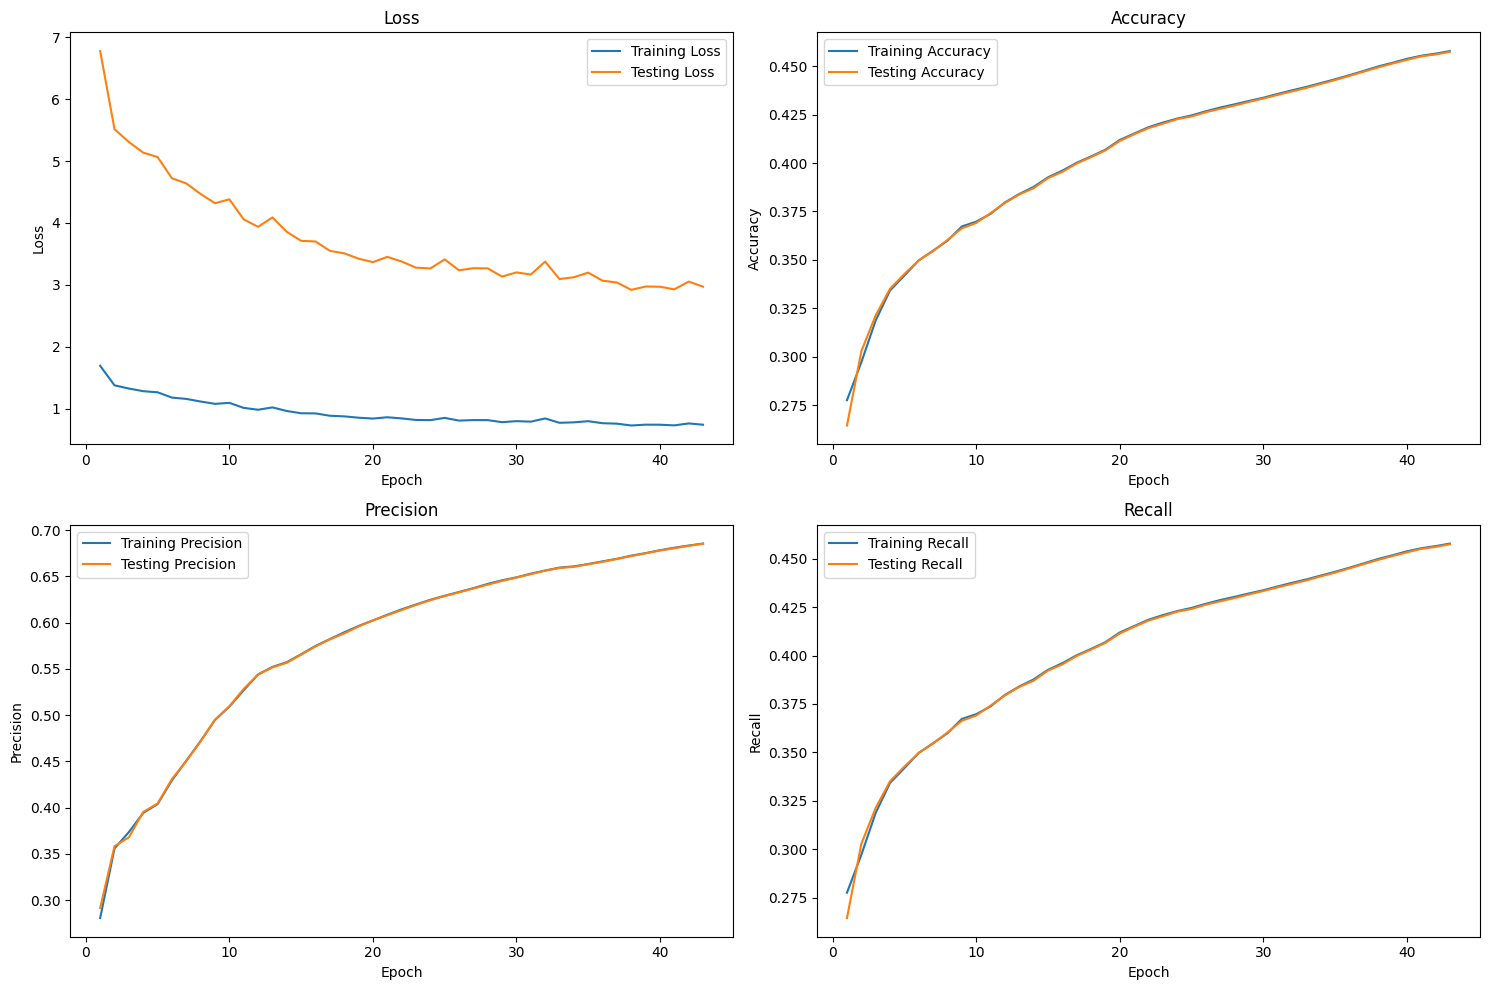

In [32]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [33]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction clasificador lineal con data augmentation.

In [15]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtractionND(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 1.6549, Training Accuracy: 0.3668, Training Precision: 0.3901, Training Recall: 0.3668


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 6.6197, Testing Accuracy: 0.3867, Testing Precision: 0.4097, Testing Recall: 0.3867


Training Epoch 2/100: 100%|████████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.6748, Training Accuracy: 0.5240, Training Precision: 0.5811, Training Recall: 0.5240


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 2.6994, Testing Accuracy: 0.5134, Testing Precision: 0.5784, Testing Recall: 0.5134


Training Epoch 3/100: 100%|████████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 0.4186, Training Accuracy: 0.6096, Training Precision: 0.6845, Training Recall: 0.6096


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 1.6745, Testing Accuracy: 0.5951, Testing Precision: 0.6781, Testing Recall: 0.5951


Training Epoch 4/100: 100%|████████████████| 160/160 [00:35<00:00,  4.48batch/s]


Training Loss: 0.2708, Training Accuracy: 0.6636, Training Precision: 0.7452, Training Recall: 0.6636


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.50batch/s]


Testing Loss: 1.0831, Testing Accuracy: 0.6491, Testing Precision: 0.7384, Testing Recall: 0.6491


Training Epoch 5/100: 100%|████████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.1685, Training Accuracy: 0.7015, Training Precision: 0.7849, Training Recall: 0.7015


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.57batch/s]


Testing Loss: 0.6742, Testing Accuracy: 0.6891, Testing Precision: 0.7803, Testing Recall: 0.6891


Training Epoch 6/100: 100%|████████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.1214, Training Accuracy: 0.7289, Training Precision: 0.8132, Training Recall: 0.7289


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.4855, Testing Accuracy: 0.7182, Testing Precision: 0.8083, Testing Recall: 0.7182


Training Epoch 7/100: 100%|████████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0831, Training Accuracy: 0.7500, Training Precision: 0.8333, Training Recall: 0.7500


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.3323, Testing Accuracy: 0.7399, Testing Precision: 0.8286, Testing Recall: 0.7399


Training Epoch 8/100: 100%|████████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0583, Training Accuracy: 0.7659, Training Precision: 0.8482, Training Recall: 0.7659


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.2334, Testing Accuracy: 0.7573, Testing Precision: 0.8439, Testing Recall: 0.7573


Training Epoch 9/100: 100%|████████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0459, Training Accuracy: 0.7788, Training Precision: 0.8596, Training Recall: 0.7788


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.1836, Testing Accuracy: 0.7704, Testing Precision: 0.8552, Testing Recall: 0.7704


Training Epoch 10/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0377, Training Accuracy: 0.7887, Training Precision: 0.8682, Training Recall: 0.7887


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.1508, Testing Accuracy: 0.7810, Testing Precision: 0.8647, Testing Recall: 0.7810


Training Epoch 11/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0324, Training Accuracy: 0.7968, Training Precision: 0.8756, Training Recall: 0.7968


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.1295, Testing Accuracy: 0.7897, Testing Precision: 0.8724, Testing Recall: 0.7897


Training Epoch 12/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0269, Training Accuracy: 0.8035, Training Precision: 0.8818, Training Recall: 0.8035


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.1077, Testing Accuracy: 0.7969, Testing Precision: 0.8777, Testing Recall: 0.7969


Training Epoch 13/100: 100%|███████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0219, Training Accuracy: 0.8093, Training Precision: 0.8860, Training Recall: 0.8093


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 0.0877, Testing Accuracy: 0.8030, Testing Precision: 0.8831, Testing Recall: 0.8030


Training Epoch 14/100: 100%|███████████████| 160/160 [00:35<00:00,  4.56batch/s]


Training Loss: 0.0190, Training Accuracy: 0.8142, Training Precision: 0.8905, Training Recall: 0.8142


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 0.0759, Testing Accuracy: 0.8083, Testing Precision: 0.8876, Testing Recall: 0.8083


Training Epoch 15/100: 100%|███████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 0.0165, Training Accuracy: 0.8184, Training Precision: 0.8942, Training Recall: 0.8184


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.51batch/s]


Testing Loss: 0.0660, Testing Accuracy: 0.8127, Testing Precision: 0.8918, Testing Recall: 0.8127


Training Epoch 16/100: 100%|███████████████| 160/160 [00:35<00:00,  4.54batch/s]


Training Loss: 0.0146, Training Accuracy: 0.8220, Training Precision: 0.8977, Training Recall: 0.8220


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.60batch/s]


Testing Loss: 0.0584, Testing Accuracy: 0.8167, Testing Precision: 0.8954, Testing Recall: 0.8167


Training Epoch 17/100: 100%|███████████████| 160/160 [00:35<00:00,  4.52batch/s]


Training Loss: 0.0136, Training Accuracy: 0.8252, Training Precision: 0.9007, Training Recall: 0.8252


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.57batch/s]


Testing Loss: 0.0545, Testing Accuracy: 0.8203, Testing Precision: 0.8984, Testing Recall: 0.8203


Training Epoch 18/100: 100%|███████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0120, Training Accuracy: 0.8281, Training Precision: 0.9033, Training Recall: 0.8281


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 0.0481, Testing Accuracy: 0.8234, Testing Precision: 0.9011, Testing Recall: 0.8234


Training Epoch 19/100: 100%|███████████████| 160/160 [00:35<00:00,  4.57batch/s]


Training Loss: 0.0106, Training Accuracy: 0.8307, Training Precision: 0.9056, Training Recall: 0.8307


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 0.0425, Testing Accuracy: 0.8261, Testing Precision: 0.9035, Testing Recall: 0.8261


Training Epoch 20/100: 100%|███████████████| 160/160 [00:35<00:00,  4.52batch/s]


Training Loss: 0.0096, Training Accuracy: 0.8329, Training Precision: 0.9077, Training Recall: 0.8329


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 0.0382, Testing Accuracy: 0.8285, Testing Precision: 0.9057, Testing Recall: 0.8285


Training Epoch 21/100: 100%|███████████████| 160/160 [00:35<00:00,  4.55batch/s]


Training Loss: 0.0089, Training Accuracy: 0.8349, Training Precision: 0.9096, Training Recall: 0.8349


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.51batch/s]


Testing Loss: 0.0354, Testing Accuracy: 0.8307, Testing Precision: 0.9076, Testing Recall: 0.8307


Training Epoch 22/100: 100%|███████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 0.0080, Training Accuracy: 0.8368, Training Precision: 0.9112, Training Recall: 0.8368


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.57batch/s]


Testing Loss: 0.0319, Testing Accuracy: 0.8328, Testing Precision: 0.9094, Testing Recall: 0.8328


Training Epoch 23/100: 100%|███████████████| 160/160 [00:35<00:00,  4.56batch/s]


Training Loss: 0.0072, Training Accuracy: 0.8385, Training Precision: 0.9128, Training Recall: 0.8385


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 0.0286, Testing Accuracy: 0.8347, Testing Precision: 0.9110, Testing Recall: 0.8347


Training Epoch 24/100: 100%|███████████████| 160/160 [00:35<00:00,  4.52batch/s]


Training Loss: 0.0067, Training Accuracy: 0.8401, Training Precision: 0.9142, Training Recall: 0.8401


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.58batch/s]


Testing Loss: 0.0266, Testing Accuracy: 0.8364, Testing Precision: 0.9125, Testing Recall: 0.8364


Training Epoch 25/100: 100%|███████████████| 160/160 [00:35<00:00,  4.54batch/s]


Training Loss: 0.0060, Training Accuracy: 0.8416, Training Precision: 0.9155, Training Recall: 0.8416


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 0.0239, Testing Accuracy: 0.8380, Testing Precision: 0.9139, Testing Recall: 0.8380


Training Epoch 26/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0054, Training Accuracy: 0.8429, Training Precision: 0.9167, Training Recall: 0.8429


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0215, Testing Accuracy: 0.8395, Testing Precision: 0.9151, Testing Recall: 0.8395


Training Epoch 27/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0048, Training Accuracy: 0.8441, Training Precision: 0.9178, Training Recall: 0.8441


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0192, Testing Accuracy: 0.8409, Testing Precision: 0.9162, Testing Recall: 0.8409


Training Epoch 28/100: 100%|███████████████| 160/160 [00:37<00:00,  4.31batch/s]


Training Loss: 0.0044, Training Accuracy: 0.8453, Training Precision: 0.9188, Training Recall: 0.8453


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0177, Testing Accuracy: 0.8422, Testing Precision: 0.9173, Testing Recall: 0.8422


Training Epoch 29/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0040, Training Accuracy: 0.8464, Training Precision: 0.9197, Training Recall: 0.8464


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0162, Testing Accuracy: 0.8433, Testing Precision: 0.9182, Testing Recall: 0.8433


Training Epoch 30/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0038, Training Accuracy: 0.8474, Training Precision: 0.9205, Training Recall: 0.8474


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0151, Testing Accuracy: 0.8445, Testing Precision: 0.9191, Testing Recall: 0.8445


Training Epoch 31/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0034, Training Accuracy: 0.8484, Training Precision: 0.9213, Training Recall: 0.8484


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0137, Testing Accuracy: 0.8456, Testing Precision: 0.9199, Testing Recall: 0.8456


Training Epoch 32/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8493, Training Precision: 0.9221, Training Recall: 0.8493


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0129, Testing Accuracy: 0.8466, Testing Precision: 0.9208, Testing Recall: 0.8466


Training Epoch 33/100: 100%|███████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8502, Training Precision: 0.9228, Training Recall: 0.8502


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0115, Testing Accuracy: 0.8475, Testing Precision: 0.9215, Testing Recall: 0.8475


Training Epoch 34/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8510, Training Precision: 0.9234, Training Recall: 0.8510


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8483, Testing Precision: 0.9222, Testing Recall: 0.8483


Training Epoch 35/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8517, Training Precision: 0.9241, Training Recall: 0.8517


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0100, Testing Accuracy: 0.8491, Testing Precision: 0.9229, Testing Recall: 0.8491


Training Epoch 36/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0023, Training Accuracy: 0.8523, Training Precision: 0.9247, Training Recall: 0.8523


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0090, Testing Accuracy: 0.8498, Testing Precision: 0.9235, Testing Recall: 0.8498


Training Epoch 37/100: 100%|███████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.0021, Training Accuracy: 0.8530, Training Precision: 0.9252, Training Recall: 0.8530


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0083, Testing Accuracy: 0.8506, Testing Precision: 0.9241, Testing Recall: 0.8506


Training Epoch 38/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0019, Training Accuracy: 0.8537, Training Precision: 0.9257, Training Recall: 0.8537


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0075, Testing Accuracy: 0.8513, Testing Precision: 0.9246, Testing Recall: 0.8513


Training Epoch 39/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0017, Training Accuracy: 0.8543, Training Precision: 0.9263, Training Recall: 0.8543


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0070, Testing Accuracy: 0.8520, Testing Precision: 0.9252, Testing Recall: 0.8520


Training Epoch 40/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0016, Training Accuracy: 0.8548, Training Precision: 0.9268, Training Recall: 0.8548


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0065, Testing Accuracy: 0.8526, Testing Precision: 0.9257, Testing Recall: 0.8526


Training Epoch 41/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0015, Training Accuracy: 0.8554, Training Precision: 0.9272, Training Recall: 0.8554


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0059, Testing Accuracy: 0.8532, Testing Precision: 0.9261, Testing Recall: 0.8532


Training Epoch 42/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8559, Training Precision: 0.9276, Training Recall: 0.8559


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0054, Testing Accuracy: 0.8537, Testing Precision: 0.9265, Testing Recall: 0.8537


Training Epoch 43/100: 100%|███████████████| 160/160 [00:35<00:00,  4.48batch/s]


Training Loss: 0.0013, Training Accuracy: 0.8564, Training Precision: 0.9279, Training Recall: 0.8564


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0050, Testing Accuracy: 0.8543, Testing Precision: 0.9269, Testing Recall: 0.8543


Training Epoch 44/100: 100%|███████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8568, Training Precision: 0.9283, Training Recall: 0.8568


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0046, Testing Accuracy: 0.8548, Testing Precision: 0.9274, Testing Recall: 0.8548


Training Epoch 45/100: 100%|███████████████| 160/160 [00:35<00:00,  4.48batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8573, Training Precision: 0.9287, Training Recall: 0.8573


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0043, Testing Accuracy: 0.8553, Testing Precision: 0.9277, Testing Recall: 0.8553


Training Epoch 46/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8578, Training Precision: 0.9290, Training Recall: 0.8578


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0039, Testing Accuracy: 0.8558, Testing Precision: 0.9280, Testing Recall: 0.8558


Training Epoch 47/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8582, Training Precision: 0.9293, Training Recall: 0.8582


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0036, Testing Accuracy: 0.8562, Testing Precision: 0.9284, Testing Recall: 0.8562


Training Epoch 48/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8586, Training Precision: 0.9296, Training Recall: 0.8586


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.0034, Testing Accuracy: 0.8567, Testing Precision: 0.9287, Testing Recall: 0.8567


Training Epoch 49/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8589, Training Precision: 0.9299, Training Recall: 0.8589


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0031, Testing Accuracy: 0.8571, Testing Precision: 0.9291, Testing Recall: 0.8571


Training Epoch 50/100: 100%|███████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8593, Training Precision: 0.9303, Training Recall: 0.8593


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.51batch/s]


Testing Loss: 0.0029, Testing Accuracy: 0.8575, Testing Precision: 0.9294, Testing Recall: 0.8575


Training Epoch 51/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8596, Training Precision: 0.9305, Training Recall: 0.8596


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0027, Testing Accuracy: 0.8578, Testing Precision: 0.9296, Testing Recall: 0.8578


Training Epoch 52/100: 100%|███████████████| 160/160 [00:35<00:00,  4.54batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8600, Training Precision: 0.9308, Training Recall: 0.8600


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0025, Testing Accuracy: 0.8582, Testing Precision: 0.9300, Testing Recall: 0.8582


Training Epoch 53/100: 100%|███████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8603, Training Precision: 0.9311, Training Recall: 0.8603


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.58batch/s]


Testing Loss: 0.0023, Testing Accuracy: 0.8586, Testing Precision: 0.9302, Testing Recall: 0.8586


Training Epoch 54/100: 100%|███████████████| 160/160 [00:35<00:00,  4.53batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8606, Training Precision: 0.9313, Training Recall: 0.8606


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0021, Testing Accuracy: 0.8589, Testing Precision: 0.9305, Testing Recall: 0.8589


Training Epoch 55/100: 100%|███████████████| 160/160 [00:35<00:00,  4.55batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8609, Training Precision: 0.9315, Training Recall: 0.8609


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0019, Testing Accuracy: 0.8593, Testing Precision: 0.9307, Testing Recall: 0.8593


Training Epoch 56/100: 100%|███████████████| 160/160 [00:35<00:00,  4.54batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8612, Training Precision: 0.9318, Training Recall: 0.8612


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]


Testing Loss: 0.0018, Testing Accuracy: 0.8596, Testing Precision: 0.9310, Testing Recall: 0.8596


Training Epoch 57/100: 100%|███████████████| 160/160 [00:35<00:00,  4.55batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8615, Training Precision: 0.9320, Training Recall: 0.8615


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.55batch/s]


Testing Loss: 0.0016, Testing Accuracy: 0.8599, Testing Precision: 0.9312, Testing Recall: 0.8599


Training Epoch 58/100: 100%|███████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8618, Training Precision: 0.9322, Training Recall: 0.8618


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0015, Testing Accuracy: 0.8602, Testing Precision: 0.9315, Testing Recall: 0.8602


Training Epoch 59/100: 100%|███████████████| 160/160 [00:35<00:00,  4.55batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8620, Training Precision: 0.9324, Training Recall: 0.8620


Testing Epoch 59/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.52batch/s]


Testing Loss: 0.0014, Testing Accuracy: 0.8605, Testing Precision: 0.9317, Testing Recall: 0.8605


Training Epoch 60/100: 100%|███████████████| 160/160 [00:35<00:00,  4.52batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8623, Training Precision: 0.9326, Training Recall: 0.8623


Testing Epoch 60/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]


Testing Loss: 0.0013, Testing Accuracy: 0.8608, Testing Precision: 0.9319, Testing Recall: 0.8608


Training Epoch 61/100: 100%|███████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8625, Training Precision: 0.9328, Training Recall: 0.8625


Testing Epoch 61/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8610, Testing Precision: 0.9321, Testing Recall: 0.8610


Training Epoch 62/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8628, Training Precision: 0.9330, Training Recall: 0.8628


Testing Epoch 62/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0011, Testing Accuracy: 0.8612, Testing Precision: 0.9323, Testing Recall: 0.8612


Training Epoch 63/100: 100%|███████████████| 160/160 [00:35<00:00,  4.51batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8630, Training Precision: 0.9332, Training Recall: 0.8630


Testing Epoch 63/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8615, Testing Precision: 0.9325, Testing Recall: 0.8615


Training Epoch 64/100: 100%|███████████████| 160/160 [00:39<00:00,  4.01batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8632, Training Precision: 0.9334, Training Recall: 0.8632


Testing Epoch 64/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8617, Testing Precision: 0.9327, Testing Recall: 0.8617


Training Epoch 65/100: 100%|███████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8634, Training Precision: 0.9335, Training Recall: 0.8634


Testing Epoch 65/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8619, Testing Precision: 0.9329, Testing Recall: 0.8619


Training Epoch 66/100: 100%|███████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8636, Training Precision: 0.9337, Training Recall: 0.8636


Testing Epoch 66/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8622, Testing Precision: 0.9330, Testing Recall: 0.8622


Training Epoch 67/100: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8638, Training Precision: 0.9339, Training Recall: 0.8638


Testing Epoch 67/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8624, Testing Precision: 0.9332, Testing Recall: 0.8624


Training Epoch 68/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8640, Training Precision: 0.9340, Training Recall: 0.8640


Testing Epoch 68/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8626, Testing Precision: 0.9334, Testing Recall: 0.8626


Training Epoch 69/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8642, Training Precision: 0.9342, Training Recall: 0.8642


Testing Epoch 69/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8628, Testing Precision: 0.9335, Testing Recall: 0.8628


Training Epoch 70/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8643, Training Precision: 0.9343, Training Recall: 0.8643


Testing Epoch 70/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8630, Testing Precision: 0.9337, Testing Recall: 0.8630


Training Epoch 71/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8645, Training Precision: 0.9344, Training Recall: 0.8645


Testing Epoch 71/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8632, Testing Precision: 0.9338, Testing Recall: 0.8632


Training Epoch 72/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8647, Training Precision: 0.9346, Training Recall: 0.8647


Testing Epoch 72/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8634, Testing Precision: 0.9339, Testing Recall: 0.8634


Training Epoch 73/100: 100%|███████████████| 160/160 [00:37<00:00,  4.27batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8649, Training Precision: 0.9347, Training Recall: 0.8649


Testing Epoch 73/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8636, Testing Precision: 0.9341, Testing Recall: 0.8636


Training Epoch 74/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8650, Training Precision: 0.9348, Training Recall: 0.8650


Testing Epoch 74/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8638, Testing Precision: 0.9342, Testing Recall: 0.8638


Training Epoch 75/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8652, Training Precision: 0.9349, Training Recall: 0.8652


Testing Epoch 75/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8640, Testing Precision: 0.9343, Testing Recall: 0.8640


Training Epoch 76/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8654, Training Precision: 0.9351, Training Recall: 0.8654


Testing Epoch 76/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8642, Testing Precision: 0.9345, Testing Recall: 0.8642


Training Epoch 77/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8655, Training Precision: 0.9352, Training Recall: 0.8655


Testing Epoch 77/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8643, Testing Precision: 0.9346, Testing Recall: 0.8643


Training Epoch 78/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8657, Training Precision: 0.9353, Training Recall: 0.8657


Testing Epoch 78/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8645, Testing Precision: 0.9347, Testing Recall: 0.8645


Training Epoch 79/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8658, Training Precision: 0.9354, Training Recall: 0.8658


Testing Epoch 79/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8647, Testing Precision: 0.9349, Testing Recall: 0.8647


Training Epoch 80/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8660, Training Precision: 0.9355, Training Recall: 0.8660


Testing Epoch 80/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8648, Testing Precision: 0.9350, Testing Recall: 0.8648


Training Epoch 81/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8661, Training Precision: 0.9356, Training Recall: 0.8661


Testing Epoch 81/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8650, Testing Precision: 0.9351, Testing Recall: 0.8650


Training Epoch 82/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8663, Training Precision: 0.9357, Training Recall: 0.8663


Testing Epoch 82/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8651, Testing Precision: 0.9352, Testing Recall: 0.8651


Training Epoch 83/100: 100%|███████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8664, Training Precision: 0.9358, Training Recall: 0.8664


Testing Epoch 83/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8653, Testing Precision: 0.9353, Testing Recall: 0.8653


Training Epoch 84/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8665, Training Precision: 0.9360, Training Recall: 0.8665


Testing Epoch 84/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8654, Testing Precision: 0.9354, Testing Recall: 0.8654


Training Epoch 85/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8667, Training Precision: 0.9361, Training Recall: 0.8667


Testing Epoch 85/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8656, Testing Precision: 0.9355, Testing Recall: 0.8656


Training Epoch 86/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8668, Training Precision: 0.9361, Training Recall: 0.8668


Testing Epoch 86/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8657, Testing Precision: 0.9356, Testing Recall: 0.8657


Training Epoch 87/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8669, Training Precision: 0.9363, Training Recall: 0.8669


Testing Epoch 87/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8658, Testing Precision: 0.9357, Testing Recall: 0.8658


Training Epoch 88/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8670, Training Precision: 0.9363, Training Recall: 0.8670


Testing Epoch 88/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8660, Testing Precision: 0.9358, Testing Recall: 0.8660


Training Epoch 89/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8671, Training Precision: 0.9364, Training Recall: 0.8671


Testing Epoch 89/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8661, Testing Precision: 0.9359, Testing Recall: 0.8661


Training Epoch 90/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8672, Training Precision: 0.9365, Training Recall: 0.8672


Testing Epoch 90/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8662, Testing Precision: 0.9360, Testing Recall: 0.8662


Training Epoch 91/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8673, Training Precision: 0.9366, Training Recall: 0.8673


Testing Epoch 91/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8663, Testing Precision: 0.9361, Testing Recall: 0.8663


Training Epoch 92/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8675, Training Precision: 0.9367, Training Recall: 0.8675


Testing Epoch 92/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8665, Testing Precision: 0.9362, Testing Recall: 0.8665


Training Epoch 93/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8676, Training Precision: 0.9368, Training Recall: 0.8676


Testing Epoch 93/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8666, Testing Precision: 0.9363, Testing Recall: 0.8666


Training Epoch 94/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8677, Training Precision: 0.9369, Training Recall: 0.8677


Testing Epoch 94/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8667, Testing Precision: 0.9364, Testing Recall: 0.8667


Training Epoch 95/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8678, Training Precision: 0.9369, Training Recall: 0.8678


Testing Epoch 95/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8668, Testing Precision: 0.9364, Testing Recall: 0.8668


Training Epoch 96/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8679, Training Precision: 0.9370, Training Recall: 0.8679


Testing Epoch 96/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8669, Testing Precision: 0.9365, Testing Recall: 0.8669


Training Epoch 97/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8680, Training Precision: 0.9371, Training Recall: 0.8680


Testing Epoch 97/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8670, Testing Precision: 0.9366, Testing Recall: 0.8670


Training Epoch 98/100: 100%|███████████████| 160/160 [00:36<00:00,  4.42batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8681, Training Precision: 0.9371, Training Recall: 0.8681


Testing Epoch 98/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8671, Testing Precision: 0.9367, Testing Recall: 0.8671


Training Epoch 99/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8682, Training Precision: 0.9372, Training Recall: 0.8682


Testing Epoch 99/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8673, Testing Precision: 0.9368, Testing Recall: 0.8673


Training Epoch 100/100: 100%|██████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8683, Training Precision: 0.9373, Training Recall: 0.8683


Testing Epoch 100/100: 100%|█████████████████| 40/40 [00:09<00:00,  4.40batch/s]

Testing Loss: 0.0001, Testing Accuracy: 0.8673, Testing Precision: 0.9368, Testing Recall: 0.8673


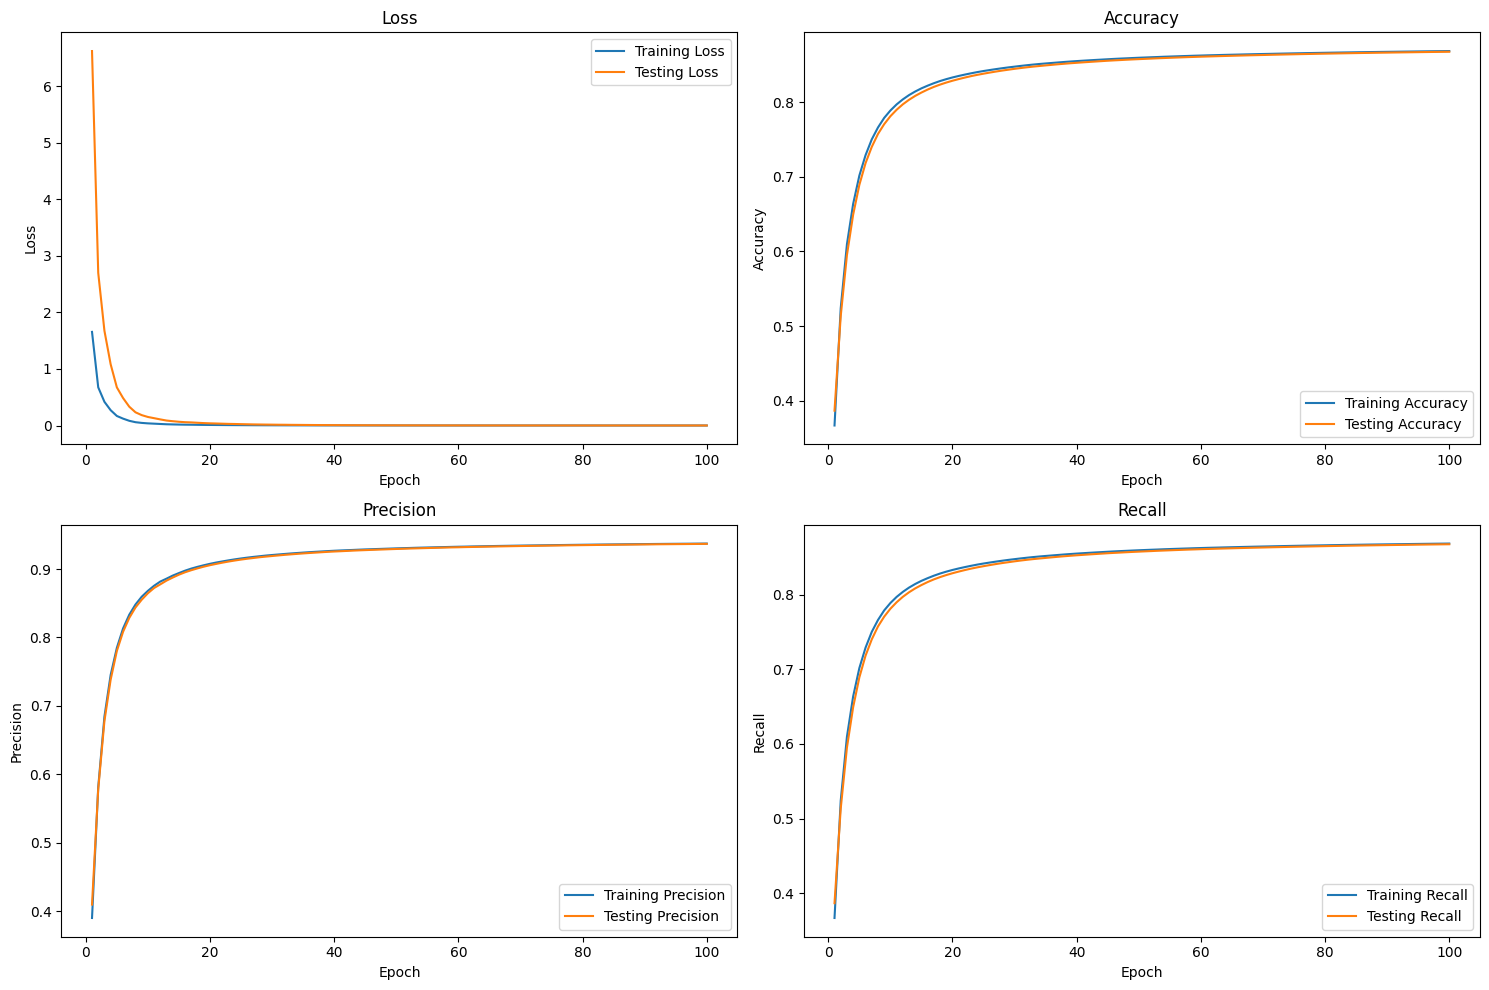

In [16]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [17]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Otras enfermedades o anormalidades, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Hipertensión, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal


### VGG16 feature extraction clasificador lineal  learning rate 0.0001(data augmentation)

In [18]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.0001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtractionND(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 1.3072, Training Accuracy: 0.3067, Training Precision: 0.3990, Training Recall: 0.3067


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 5.2286, Testing Accuracy: 0.3244, Testing Precision: 0.3973, Testing Recall: 0.3244


Training Epoch 2/100: 100%|████████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 1.0105, Training Accuracy: 0.3828, Training Precision: 0.6069, Training Recall: 0.3828


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 4.0421, Testing Accuracy: 0.3852, Testing Precision: 0.6054, Testing Recall: 0.3852


Training Epoch 3/100: 100%|████████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.8673, Training Accuracy: 0.4273, Training Precision: 0.6879, Training Recall: 0.4273


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.4692, Testing Accuracy: 0.4266, Testing Precision: 0.6864, Testing Recall: 0.4266


Training Epoch 4/100: 100%|████████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.7667, Training Accuracy: 0.4625, Training Precision: 0.7363, Training Recall: 0.4625


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.0667, Testing Accuracy: 0.4605, Testing Precision: 0.7331, Testing Recall: 0.4605


Training Epoch 5/100: 100%|████████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.6851, Training Accuracy: 0.4924, Training Precision: 0.7683, Training Recall: 0.4924


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 2.7404, Testing Accuracy: 0.4897, Testing Precision: 0.7623, Testing Recall: 0.4897


Training Epoch 6/100: 100%|████████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.6144, Training Accuracy: 0.5207, Training Precision: 0.7897, Training Recall: 0.5207


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 2.4577, Testing Accuracy: 0.5177, Testing Precision: 0.7864, Testing Recall: 0.5177


Training Epoch 7/100: 100%|████████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.5545, Training Accuracy: 0.5469, Training Precision: 0.8098, Training Recall: 0.5469


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 2.2180, Testing Accuracy: 0.5441, Testing Precision: 0.8033, Testing Recall: 0.5441


Training Epoch 8/100: 100%|████████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.5035, Training Accuracy: 0.5706, Training Precision: 0.8232, Training Recall: 0.5706


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 2.0141, Testing Accuracy: 0.5672, Testing Precision: 0.8176, Testing Recall: 0.5672


Training Epoch 9/100: 100%|████████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 0.4601, Training Accuracy: 0.5917, Training Precision: 0.8335, Training Recall: 0.5917


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 1.8402, Testing Accuracy: 0.5879, Testing Precision: 0.8286, Testing Recall: 0.5879


Training Epoch 10/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.4233, Training Accuracy: 0.6107, Training Precision: 0.8428, Training Recall: 0.6107


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 1.6931, Testing Accuracy: 0.6069, Testing Precision: 0.8392, Testing Recall: 0.6069


Training Epoch 11/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.3883, Training Accuracy: 0.6278, Training Precision: 0.8513, Training Recall: 0.6278


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 1.5534, Testing Accuracy: 0.6239, Testing Precision: 0.8482, Testing Recall: 0.6239


Training Epoch 12/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.3588, Training Accuracy: 0.6432, Training Precision: 0.8588, Training Recall: 0.6432


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 1.4351, Testing Accuracy: 0.6395, Testing Precision: 0.8561, Testing Recall: 0.6395


Training Epoch 13/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.3304, Training Accuracy: 0.6574, Training Precision: 0.8655, Training Recall: 0.6574


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 1.3215, Testing Accuracy: 0.6537, Testing Precision: 0.8624, Testing Recall: 0.6537


Training Epoch 14/100: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.3085, Training Accuracy: 0.6703, Training Precision: 0.8708, Training Recall: 0.6703


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 1.2338, Testing Accuracy: 0.6668, Testing Precision: 0.8681, Testing Recall: 0.6668


Training Epoch 15/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.2843, Training Accuracy: 0.6823, Training Precision: 0.8757, Training Recall: 0.6823


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 1.1373, Testing Accuracy: 0.6787, Testing Precision: 0.8725, Testing Recall: 0.6787


Training Epoch 16/100: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.2652, Training Accuracy: 0.6929, Training Precision: 0.8793, Training Recall: 0.6929


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 1.0609, Testing Accuracy: 0.6894, Testing Precision: 0.8772, Testing Recall: 0.6894


Training Epoch 17/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.2467, Training Accuracy: 0.7025, Training Precision: 0.8834, Training Recall: 0.7025


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.9866, Testing Accuracy: 0.6990, Testing Precision: 0.8812, Testing Recall: 0.6990


Training Epoch 18/100: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.2298, Training Accuracy: 0.7111, Training Precision: 0.8869, Training Recall: 0.7111


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.9191, Testing Accuracy: 0.7078, Testing Precision: 0.8842, Testing Recall: 0.7078


Training Epoch 19/100: 100%|███████████████| 160/160 [00:37<00:00,  4.27batch/s]


Training Loss: 0.2162, Training Accuracy: 0.7192, Training Precision: 0.8895, Training Recall: 0.7192


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.8648, Testing Accuracy: 0.7160, Testing Precision: 0.8877, Testing Recall: 0.7160


Training Epoch 20/100: 100%|███████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.1990, Training Accuracy: 0.7267, Training Precision: 0.8926, Training Recall: 0.7267


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.7959, Testing Accuracy: 0.7234, Testing Precision: 0.8900, Testing Recall: 0.7234


Training Epoch 21/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.1873, Training Accuracy: 0.7334, Training Precision: 0.8946, Training Recall: 0.7334


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.7491, Testing Accuracy: 0.7303, Testing Precision: 0.8922, Testing Recall: 0.7303


Training Epoch 22/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.1755, Training Accuracy: 0.7397, Training Precision: 0.8965, Training Recall: 0.7397


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.7021, Testing Accuracy: 0.7366, Testing Precision: 0.8951, Testing Recall: 0.7366


Training Epoch 23/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.1668, Training Accuracy: 0.7453, Training Precision: 0.8990, Training Recall: 0.7453


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.6672, Testing Accuracy: 0.7424, Testing Precision: 0.8975, Testing Recall: 0.7424


Training Epoch 24/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.1544, Training Accuracy: 0.7506, Training Precision: 0.9013, Training Recall: 0.7506


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.6177, Testing Accuracy: 0.7477, Testing Precision: 0.8998, Testing Recall: 0.7477


Training Epoch 25/100: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.1455, Training Accuracy: 0.7555, Training Precision: 0.9033, Training Recall: 0.7555


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.5822, Testing Accuracy: 0.7527, Testing Precision: 0.9017, Testing Recall: 0.7527


Training Epoch 26/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.1359, Training Accuracy: 0.7600, Training Precision: 0.9050, Training Recall: 0.7600


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.5436, Testing Accuracy: 0.7574, Testing Precision: 0.9032, Testing Recall: 0.7574


Training Epoch 27/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.1280, Training Accuracy: 0.7644, Training Precision: 0.9064, Training Recall: 0.7644


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.5120, Testing Accuracy: 0.7616, Testing Precision: 0.9049, Testing Recall: 0.7616


Training Epoch 28/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.1210, Training Accuracy: 0.7682, Training Precision: 0.9078, Training Recall: 0.7682


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.4839, Testing Accuracy: 0.7657, Testing Precision: 0.9065, Testing Recall: 0.7657


Training Epoch 29/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.1121, Training Accuracy: 0.7719, Training Precision: 0.9093, Training Recall: 0.7719


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.4484, Testing Accuracy: 0.7694, Testing Precision: 0.9079, Testing Recall: 0.7694


Training Epoch 30/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.1067, Training Accuracy: 0.7754, Training Precision: 0.9106, Training Recall: 0.7754


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.4268, Testing Accuracy: 0.7729, Testing Precision: 0.9093, Testing Recall: 0.7729


Training Epoch 31/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.1002, Training Accuracy: 0.7786, Training Precision: 0.9119, Training Recall: 0.7786


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.4007, Testing Accuracy: 0.7762, Testing Precision: 0.9106, Testing Recall: 0.7762


Training Epoch 32/100: 100%|███████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0945, Training Accuracy: 0.7817, Training Precision: 0.9130, Training Recall: 0.7817


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.3780, Testing Accuracy: 0.7793, Testing Precision: 0.9117, Testing Recall: 0.7793


Training Epoch 33/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0887, Training Accuracy: 0.7845, Training Precision: 0.9140, Training Recall: 0.7845


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.3547, Testing Accuracy: 0.7822, Testing Precision: 0.9127, Testing Recall: 0.7822


Training Epoch 34/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0847, Training Accuracy: 0.7872, Training Precision: 0.9149, Training Recall: 0.7872


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.3389, Testing Accuracy: 0.7849, Testing Precision: 0.9138, Testing Recall: 0.7849


Training Epoch 35/100: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0791, Training Accuracy: 0.7897, Training Precision: 0.9159, Training Recall: 0.7897


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.3163, Testing Accuracy: 0.7874, Testing Precision: 0.9148, Testing Recall: 0.7874


Training Epoch 36/100: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0749, Training Accuracy: 0.7921, Training Precision: 0.9169, Training Recall: 0.7921


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.2997, Testing Accuracy: 0.7899, Testing Precision: 0.9157, Testing Recall: 0.7899


Training Epoch 37/100: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0706, Training Accuracy: 0.7943, Training Precision: 0.9177, Training Recall: 0.7943


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.2824, Testing Accuracy: 0.7922, Testing Precision: 0.9166, Testing Recall: 0.7922


Training Epoch 38/100: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0668, Training Accuracy: 0.7964, Training Precision: 0.9185, Training Recall: 0.7964


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.2672, Testing Accuracy: 0.7944, Testing Precision: 0.9174, Testing Recall: 0.7944


Training Epoch 39/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.0629, Training Accuracy: 0.7985, Training Precision: 0.9192, Training Recall: 0.7985


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.2517, Testing Accuracy: 0.7964, Testing Precision: 0.9180, Testing Recall: 0.7964


Training Epoch 40/100: 100%|███████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0602, Training Accuracy: 0.8004, Training Precision: 0.9198, Training Recall: 0.8004


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.2410, Testing Accuracy: 0.7984, Testing Precision: 0.9188, Testing Recall: 0.7984


Training Epoch 41/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0556, Training Accuracy: 0.8023, Training Precision: 0.9205, Training Recall: 0.8023


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.2225, Testing Accuracy: 0.8003, Testing Precision: 0.9195, Testing Recall: 0.8003


Training Epoch 42/100: 100%|███████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.0530, Training Accuracy: 0.8040, Training Precision: 0.9212, Training Recall: 0.8040


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.2120, Testing Accuracy: 0.8021, Testing Precision: 0.9203, Testing Recall: 0.8021


Training Epoch 43/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0500, Training Accuracy: 0.8056, Training Precision: 0.9219, Training Recall: 0.8056


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.2000, Testing Accuracy: 0.8038, Testing Precision: 0.9209, Testing Recall: 0.8038


Training Epoch 44/100: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0476, Training Accuracy: 0.8072, Training Precision: 0.9225, Training Recall: 0.8072


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.1905, Testing Accuracy: 0.8054, Testing Precision: 0.9215, Testing Recall: 0.8054


Training Epoch 45/100: 100%|███████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0447, Training Accuracy: 0.8088, Training Precision: 0.9230, Training Recall: 0.8088


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.1786, Testing Accuracy: 0.8069, Testing Precision: 0.9220, Testing Recall: 0.8069


Training Epoch 46/100: 100%|███████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0422, Training Accuracy: 0.8102, Training Precision: 0.9234, Training Recall: 0.8102


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.1687, Testing Accuracy: 0.8084, Testing Precision: 0.9225, Testing Recall: 0.8084


Training Epoch 47/100: 100%|███████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0394, Training Accuracy: 0.8116, Training Precision: 0.9239, Training Recall: 0.8116


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.1576, Testing Accuracy: 0.8098, Testing Precision: 0.9230, Testing Recall: 0.8098


Training Epoch 48/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0375, Training Accuracy: 0.8129, Training Precision: 0.9243, Training Recall: 0.8129


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.1498, Testing Accuracy: 0.8112, Testing Precision: 0.9235, Testing Recall: 0.8112


Training Epoch 49/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0358, Training Accuracy: 0.8142, Training Precision: 0.9249, Training Recall: 0.8142


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.1432, Testing Accuracy: 0.8125, Testing Precision: 0.9239, Testing Recall: 0.8125


Training Epoch 50/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0334, Training Accuracy: 0.8154, Training Precision: 0.9252, Training Recall: 0.8154


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.1337, Testing Accuracy: 0.8138, Testing Precision: 0.9243, Testing Recall: 0.8138


Training Epoch 51/100: 100%|███████████████| 160/160 [00:38<00:00,  4.12batch/s]


Training Loss: 0.0320, Training Accuracy: 0.8166, Training Precision: 0.9256, Training Recall: 0.8166


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.1281, Testing Accuracy: 0.8150, Testing Precision: 0.9248, Testing Recall: 0.8150


Training Epoch 52/100: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0301, Training Accuracy: 0.8178, Training Precision: 0.9260, Training Recall: 0.8178


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.1203, Testing Accuracy: 0.8161, Testing Precision: 0.9252, Testing Recall: 0.8161


Training Epoch 53/100: 100%|███████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0288, Training Accuracy: 0.8188, Training Precision: 0.9264, Training Recall: 0.8188


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.1153, Testing Accuracy: 0.8173, Testing Precision: 0.9256, Testing Recall: 0.8173


Training Epoch 54/100: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0270, Training Accuracy: 0.8199, Training Precision: 0.9268, Training Recall: 0.8199


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 0.1078, Testing Accuracy: 0.8183, Testing Precision: 0.9260, Testing Recall: 0.8183


Training Epoch 55/100: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0254, Training Accuracy: 0.8209, Training Precision: 0.9271, Training Recall: 0.8209


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.1016, Testing Accuracy: 0.8194, Testing Precision: 0.9263, Testing Recall: 0.8194


Training Epoch 56/100: 100%|███████████████| 160/160 [00:36<00:00,  4.32batch/s]


Training Loss: 0.0240, Training Accuracy: 0.8219, Training Precision: 0.9275, Training Recall: 0.8219


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0960, Testing Accuracy: 0.8204, Testing Precision: 0.9267, Testing Recall: 0.8204


Training Epoch 57/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0227, Training Accuracy: 0.8229, Training Precision: 0.9278, Training Recall: 0.8229


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0909, Testing Accuracy: 0.8214, Testing Precision: 0.9271, Testing Recall: 0.8214


Training Epoch 58/100: 100%|███████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0216, Training Accuracy: 0.8238, Training Precision: 0.9281, Training Recall: 0.8238


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0866, Testing Accuracy: 0.8223, Testing Precision: 0.9274, Testing Recall: 0.8223


Training Epoch 59/100: 100%|███████████████| 160/160 [00:38<00:00,  4.14batch/s]


Training Loss: 0.0204, Training Accuracy: 0.8246, Training Precision: 0.9285, Training Recall: 0.8246


Testing Epoch 59/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0817, Testing Accuracy: 0.8232, Testing Precision: 0.9277, Testing Recall: 0.8232


Training Epoch 60/100: 100%|███████████████| 160/160 [00:38<00:00,  4.13batch/s]


Training Loss: 0.0193, Training Accuracy: 0.8255, Training Precision: 0.9287, Training Recall: 0.8255


Testing Epoch 60/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0774, Testing Accuracy: 0.8241, Testing Precision: 0.9281, Testing Recall: 0.8241


Training Epoch 61/100: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0184, Training Accuracy: 0.8263, Training Precision: 0.9291, Training Recall: 0.8263


Testing Epoch 61/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0737, Testing Accuracy: 0.8249, Testing Precision: 0.9284, Testing Recall: 0.8249


Training Epoch 62/100: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0175, Training Accuracy: 0.8271, Training Precision: 0.9293, Training Recall: 0.8271


Testing Epoch 62/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0700, Testing Accuracy: 0.8257, Testing Precision: 0.9286, Testing Recall: 0.8257


Training Epoch 63/100: 100%|███████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0164, Training Accuracy: 0.8279, Training Precision: 0.9296, Training Recall: 0.8279


Testing Epoch 63/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0658, Testing Accuracy: 0.8265, Testing Precision: 0.9289, Testing Recall: 0.8265


Training Epoch 64/100: 100%|███████████████| 160/160 [00:35<00:00,  4.47batch/s]


Training Loss: 0.0159, Training Accuracy: 0.8286, Training Precision: 0.9298, Training Recall: 0.8286


Testing Epoch 64/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0635, Testing Accuracy: 0.8273, Testing Precision: 0.9292, Testing Recall: 0.8273


Training Epoch 65/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0149, Training Accuracy: 0.8294, Training Precision: 0.9301, Training Recall: 0.8294


Testing Epoch 65/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0595, Testing Accuracy: 0.8280, Testing Precision: 0.9294, Testing Recall: 0.8280


Training Epoch 66/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0140, Training Accuracy: 0.8301, Training Precision: 0.9303, Training Recall: 0.8301


Testing Epoch 66/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0559, Testing Accuracy: 0.8288, Testing Precision: 0.9296, Testing Recall: 0.8288


Training Epoch 67/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0133, Training Accuracy: 0.8308, Training Precision: 0.9305, Training Recall: 0.8308


Testing Epoch 67/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0531, Testing Accuracy: 0.8295, Testing Precision: 0.9298, Testing Recall: 0.8295


Training Epoch 68/100: 100%|███████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0125, Training Accuracy: 0.8314, Training Precision: 0.9307, Training Recall: 0.8314


Testing Epoch 68/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0501, Testing Accuracy: 0.8302, Testing Precision: 0.9301, Testing Recall: 0.8302


Training Epoch 69/100: 100%|███████████████| 160/160 [00:36<00:00,  4.44batch/s]


Training Loss: 0.0119, Training Accuracy: 0.8321, Training Precision: 0.9310, Training Recall: 0.8321


Testing Epoch 69/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0474, Testing Accuracy: 0.8308, Testing Precision: 0.9304, Testing Recall: 0.8308


Training Epoch 70/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0112, Training Accuracy: 0.8327, Training Precision: 0.9312, Training Recall: 0.8327


Testing Epoch 70/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0450, Testing Accuracy: 0.8315, Testing Precision: 0.9305, Testing Recall: 0.8315


Training Epoch 71/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0106, Training Accuracy: 0.8333, Training Precision: 0.9314, Training Recall: 0.8333


Testing Epoch 71/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0425, Testing Accuracy: 0.8321, Testing Precision: 0.9307, Testing Recall: 0.8321


Training Epoch 72/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0102, Training Accuracy: 0.8339, Training Precision: 0.9316, Training Recall: 0.8339


Testing Epoch 72/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0409, Testing Accuracy: 0.8327, Testing Precision: 0.9310, Testing Recall: 0.8327


Training Epoch 73/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0096, Training Accuracy: 0.8345, Training Precision: 0.9318, Training Recall: 0.8345


Testing Epoch 73/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.52batch/s]


Testing Loss: 0.0384, Testing Accuracy: 0.8333, Testing Precision: 0.9312, Testing Recall: 0.8333


Training Epoch 74/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0090, Training Accuracy: 0.8351, Training Precision: 0.9319, Training Recall: 0.8351


Testing Epoch 74/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0361, Testing Accuracy: 0.8339, Testing Precision: 0.9314, Testing Recall: 0.8339


Training Epoch 75/100: 100%|███████████████| 160/160 [00:35<00:00,  4.46batch/s]


Training Loss: 0.0086, Training Accuracy: 0.8356, Training Precision: 0.9321, Training Recall: 0.8356


Testing Epoch 75/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 0.0344, Testing Accuracy: 0.8344, Testing Precision: 0.9315, Testing Recall: 0.8344


Training Epoch 76/100: 100%|███████████████| 160/160 [00:35<00:00,  4.45batch/s]


Training Loss: 0.0081, Training Accuracy: 0.8361, Training Precision: 0.9323, Training Recall: 0.8361


Testing Epoch 76/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.44batch/s]


Testing Loss: 0.0325, Testing Accuracy: 0.8350, Testing Precision: 0.9318, Testing Recall: 0.8350


Training Epoch 77/100: 100%|███████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.0077, Training Accuracy: 0.8366, Training Precision: 0.9325, Training Recall: 0.8366


Testing Epoch 77/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0309, Testing Accuracy: 0.8355, Testing Precision: 0.9319, Testing Recall: 0.8355


Training Epoch 78/100: 100%|███████████████| 160/160 [00:35<00:00,  4.44batch/s]


Training Loss: 0.0073, Training Accuracy: 0.8372, Training Precision: 0.9327, Training Recall: 0.8372


Testing Epoch 78/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0291, Testing Accuracy: 0.8360, Testing Precision: 0.9321, Testing Recall: 0.8360


Training Epoch 79/100: 100%|███████████████| 160/160 [00:37<00:00,  4.31batch/s]


Training Loss: 0.0069, Training Accuracy: 0.8376, Training Precision: 0.9329, Training Recall: 0.8376


Testing Epoch 79/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0277, Testing Accuracy: 0.8365, Testing Precision: 0.9323, Testing Recall: 0.8365


Training Epoch 80/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0066, Training Accuracy: 0.8381, Training Precision: 0.9331, Training Recall: 0.8381


Testing Epoch 80/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0263, Testing Accuracy: 0.8370, Testing Precision: 0.9325, Testing Recall: 0.8370


Training Epoch 81/100: 100%|███████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0062, Training Accuracy: 0.8386, Training Precision: 0.9332, Training Recall: 0.8386


Testing Epoch 81/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0248, Testing Accuracy: 0.8375, Testing Precision: 0.9327, Testing Recall: 0.8375


Training Epoch 82/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0059, Training Accuracy: 0.8391, Training Precision: 0.9333, Training Recall: 0.8391


Testing Epoch 82/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0237, Testing Accuracy: 0.8380, Testing Precision: 0.9328, Testing Recall: 0.8380


Training Epoch 83/100: 100%|███████████████| 160/160 [00:36<00:00,  4.41batch/s]


Training Loss: 0.0057, Training Accuracy: 0.8395, Training Precision: 0.9335, Training Recall: 0.8395


Testing Epoch 83/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0226, Testing Accuracy: 0.8384, Testing Precision: 0.9329, Testing Recall: 0.8384


Training Epoch 84/100: 100%|███████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0053, Training Accuracy: 0.8399, Training Precision: 0.9336, Training Recall: 0.8399


Testing Epoch 84/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0212, Testing Accuracy: 0.8389, Testing Precision: 0.9331, Testing Recall: 0.8389


Training Epoch 85/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0051, Training Accuracy: 0.8404, Training Precision: 0.9337, Training Recall: 0.8404


Testing Epoch 85/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0204, Testing Accuracy: 0.8393, Testing Precision: 0.9333, Testing Recall: 0.8393


Training Epoch 86/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0047, Training Accuracy: 0.8408, Training Precision: 0.9339, Training Recall: 0.8408


Testing Epoch 86/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.0189, Testing Accuracy: 0.8398, Testing Precision: 0.9334, Testing Recall: 0.8398


Training Epoch 87/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0045, Training Accuracy: 0.8412, Training Precision: 0.9340, Training Recall: 0.8412


Testing Epoch 87/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0180, Testing Accuracy: 0.8402, Testing Precision: 0.9335, Testing Recall: 0.8402


Training Epoch 88/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0044, Training Accuracy: 0.8416, Training Precision: 0.9342, Training Recall: 0.8416


Testing Epoch 88/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0175, Testing Accuracy: 0.8406, Testing Precision: 0.9337, Testing Recall: 0.8406


Training Epoch 89/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0041, Training Accuracy: 0.8420, Training Precision: 0.9343, Training Recall: 0.8420


Testing Epoch 89/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0163, Testing Accuracy: 0.8410, Testing Precision: 0.9338, Testing Recall: 0.8410


Training Epoch 90/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0039, Training Accuracy: 0.8423, Training Precision: 0.9345, Training Recall: 0.8423


Testing Epoch 90/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.0155, Testing Accuracy: 0.8414, Testing Precision: 0.9340, Testing Recall: 0.8414


Training Epoch 91/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0037, Training Accuracy: 0.8427, Training Precision: 0.9346, Training Recall: 0.8427


Testing Epoch 91/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0146, Testing Accuracy: 0.8417, Testing Precision: 0.9341, Testing Recall: 0.8417


Training Epoch 92/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0035, Training Accuracy: 0.8431, Training Precision: 0.9347, Training Recall: 0.8431


Testing Epoch 92/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0139, Testing Accuracy: 0.8421, Testing Precision: 0.9342, Testing Recall: 0.8421


Training Epoch 93/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0033, Training Accuracy: 0.8434, Training Precision: 0.9348, Training Recall: 0.8434


Testing Epoch 93/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0131, Testing Accuracy: 0.8425, Testing Precision: 0.9343, Testing Recall: 0.8425


Training Epoch 94/100: 100%|███████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8438, Training Precision: 0.9349, Training Recall: 0.8438


Testing Epoch 94/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0124, Testing Accuracy: 0.8429, Testing Precision: 0.9344, Testing Recall: 0.8429


Training Epoch 95/100: 100%|███████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8442, Training Precision: 0.9350, Training Recall: 0.8442


Testing Epoch 95/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0117, Testing Accuracy: 0.8432, Testing Precision: 0.9346, Testing Recall: 0.8432


Training Epoch 96/100: 100%|███████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8445, Training Precision: 0.9351, Training Recall: 0.8445


Testing Epoch 96/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8436, Testing Precision: 0.9346, Testing Recall: 0.8436


Training Epoch 97/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8448, Training Precision: 0.9352, Training Recall: 0.8448


Testing Epoch 97/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8439, Testing Precision: 0.9347, Testing Recall: 0.8439


Training Epoch 98/100: 100%|███████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8451, Training Precision: 0.9353, Training Recall: 0.8451


Testing Epoch 98/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0101, Testing Accuracy: 0.8442, Testing Precision: 0.9348, Testing Recall: 0.8442


Training Epoch 99/100: 100%|███████████████| 160/160 [00:36<00:00,  4.35batch/s]


Training Loss: 0.0024, Training Accuracy: 0.8454, Training Precision: 0.9354, Training Recall: 0.8454


Testing Epoch 99/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0095, Testing Accuracy: 0.8445, Testing Precision: 0.9349, Testing Recall: 0.8445


Training Epoch 100/100: 100%|██████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0023, Training Accuracy: 0.8457, Training Precision: 0.9355, Training Recall: 0.8457


Testing Epoch 100/100: 100%|█████████████████| 40/40 [00:09<00:00,  4.33batch/s]

Testing Loss: 0.0091, Testing Accuracy: 0.8449, Testing Precision: 0.9350, Testing Recall: 0.8449


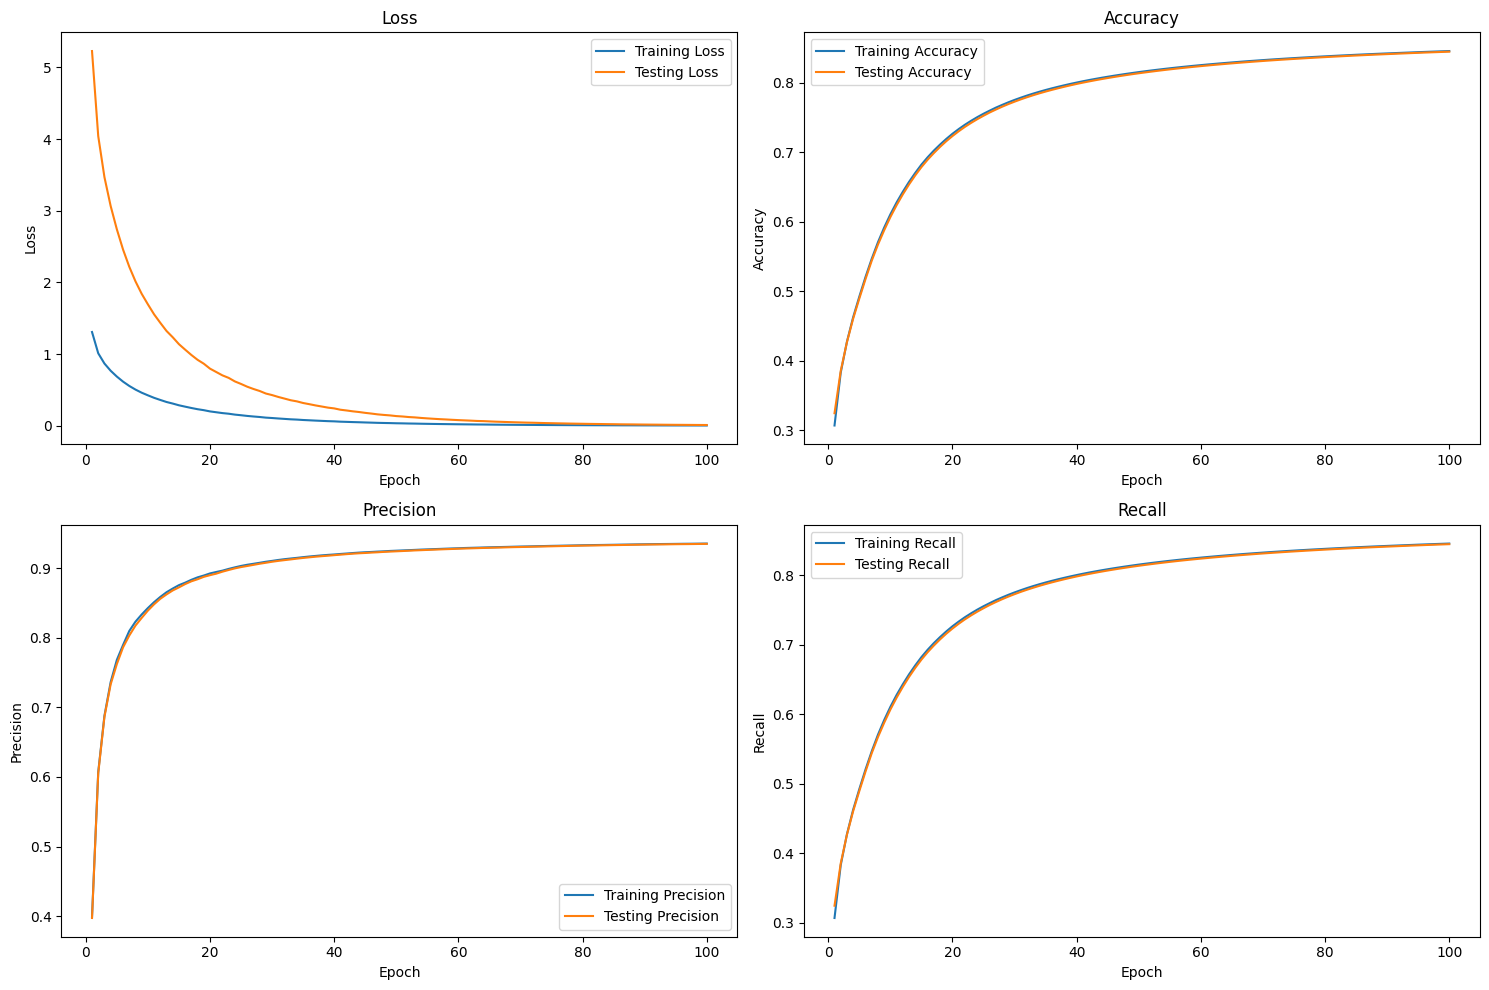

In [19]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [20]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Otras enfermedades o anormalidades, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Hipertensión, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal


### VGG16 con feature extraction y conjunto de capas cambio de learning rate a 0.0001(data augmentation)

In [34]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.0001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 1.3794, Training Accuracy: 0.2887, Training Precision: 0.3098, Training Recall: 0.2887


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 5.5178, Testing Accuracy: 0.2988, Testing Precision: 0.3183, Testing Recall: 0.2988


Training Epoch 2/100: 100%|████████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 1.1561, Training Accuracy: 0.3415, Training Precision: 0.3998, Training Recall: 0.3415


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 4.6244, Testing Accuracy: 0.3437, Testing Precision: 0.4186, Testing Recall: 0.3437


Training Epoch 3/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.0149, Training Accuracy: 0.3823, Training Precision: 0.5135, Training Recall: 0.3823


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 4.0597, Testing Accuracy: 0.3859, Testing Precision: 0.5095, Testing Recall: 0.3859


Training Epoch 4/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.8497, Training Accuracy: 0.4216, Training Precision: 0.5750, Training Recall: 0.4216


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.3988, Testing Accuracy: 0.4208, Testing Precision: 0.5743, Testing Recall: 0.4208


Training Epoch 5/100: 100%|████████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.6826, Training Accuracy: 0.4585, Training Precision: 0.6262, Training Recall: 0.4585


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 2.7302, Testing Accuracy: 0.4581, Testing Precision: 0.6257, Testing Recall: 0.4581


Training Epoch 6/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.5299, Training Accuracy: 0.4955, Training Precision: 0.6746, Training Recall: 0.4955


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 2.1197, Testing Accuracy: 0.4935, Testing Precision: 0.6716, Testing Recall: 0.4935


Training Epoch 7/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.4163, Training Accuracy: 0.5305, Training Precision: 0.7137, Training Recall: 0.5305


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 1.6653, Testing Accuracy: 0.5267, Testing Precision: 0.7069, Testing Recall: 0.5267


Training Epoch 8/100: 100%|████████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.3234, Training Accuracy: 0.5594, Training Precision: 0.7380, Training Recall: 0.5594


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 1.2937, Testing Accuracy: 0.5558, Testing Precision: 0.7354, Testing Recall: 0.5558


Training Epoch 9/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.2442, Training Accuracy: 0.5864, Training Precision: 0.7612, Training Recall: 0.5864


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.9770, Testing Accuracy: 0.5831, Testing Precision: 0.7585, Testing Recall: 0.5831


Training Epoch 10/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.1595, Training Accuracy: 0.6122, Training Precision: 0.7814, Training Recall: 0.6122


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.6382, Testing Accuracy: 0.6082, Testing Precision: 0.7771, Testing Recall: 0.6082


Training Epoch 11/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.1557, Training Accuracy: 0.6332, Training Precision: 0.7955, Training Recall: 0.6332


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.6226, Testing Accuracy: 0.6290, Testing Precision: 0.7927, Testing Recall: 0.6290


Training Epoch 12/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.1164, Training Accuracy: 0.6508, Training Precision: 0.8080, Training Recall: 0.6508


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.4658, Testing Accuracy: 0.6472, Testing Precision: 0.8020, Testing Recall: 0.6472


Training Epoch 13/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.1057, Training Accuracy: 0.6668, Training Precision: 0.8156, Training Recall: 0.6668


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.4230, Testing Accuracy: 0.6620, Testing Precision: 0.8120, Testing Recall: 0.6620


Training Epoch 14/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.1080, Training Accuracy: 0.6797, Training Precision: 0.8237, Training Recall: 0.6797


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.4320, Testing Accuracy: 0.6761, Testing Precision: 0.8197, Testing Recall: 0.6761


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0722, Training Accuracy: 0.6917, Training Precision: 0.8301, Training Recall: 0.6917


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.51batch/s]


Testing Loss: 0.2889, Testing Accuracy: 0.6881, Testing Precision: 0.8271, Testing Recall: 0.6881


Training Epoch 16/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0702, Training Accuracy: 0.7026, Training Precision: 0.8364, Training Recall: 0.7026


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.2808, Testing Accuracy: 0.6986, Testing Precision: 0.8347, Testing Recall: 0.6986


Training Epoch 17/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0855, Training Accuracy: 0.7110, Training Precision: 0.8422, Training Recall: 0.7110


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]


Testing Loss: 0.3421, Testing Accuracy: 0.7074, Testing Precision: 0.8403, Testing Recall: 0.7074


Training Epoch 18/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0907, Training Accuracy: 0.7189, Training Precision: 0.8472, Training Recall: 0.7189


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.3628, Testing Accuracy: 0.7153, Testing Precision: 0.8449, Testing Recall: 0.7153


Training Epoch 19/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0706, Training Accuracy: 0.7261, Training Precision: 0.8515, Training Recall: 0.7261


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.2824, Testing Accuracy: 0.7227, Testing Precision: 0.8475, Testing Recall: 0.7227


Training Epoch 20/100: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0613, Training Accuracy: 0.7326, Training Precision: 0.8534, Training Recall: 0.7326


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.2453, Testing Accuracy: 0.7293, Testing Precision: 0.8511, Testing Recall: 0.7293


Training Epoch 21/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0821, Training Accuracy: 0.7385, Training Precision: 0.8563, Training Recall: 0.7385


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 0.3284, Testing Accuracy: 0.7357, Testing Precision: 0.8528, Testing Recall: 0.7357


Training Epoch 22/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0517, Training Accuracy: 0.7446, Training Precision: 0.8583, Training Recall: 0.7446


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.2068, Testing Accuracy: 0.7414, Testing Precision: 0.8566, Testing Recall: 0.7414


Training Epoch 23/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0354, Training Accuracy: 0.7499, Training Precision: 0.8618, Training Recall: 0.7499


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.1416, Testing Accuracy: 0.7470, Testing Precision: 0.8600, Testing Recall: 0.7470


Training Epoch 24/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0465, Training Accuracy: 0.7549, Training Precision: 0.8649, Training Recall: 0.7549


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.1861, Testing Accuracy: 0.7516, Testing Precision: 0.8637, Testing Recall: 0.7516


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.1261, Training Accuracy: 0.7581, Training Precision: 0.8671, Training Recall: 0.7581


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.5046, Testing Accuracy: 0.7553, Testing Precision: 0.8653, Testing Recall: 0.7553


Training Epoch 26/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0924, Training Accuracy: 0.7618, Training Precision: 0.8691, Training Recall: 0.7618


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.3697, Testing Accuracy: 0.7590, Testing Precision: 0.8679, Testing Recall: 0.7590


Training Epoch 27/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0517, Training Accuracy: 0.7656, Training Precision: 0.8718, Training Recall: 0.7656


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.2067, Testing Accuracy: 0.7628, Testing Precision: 0.8703, Testing Recall: 0.7628


Training Epoch 28/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0415, Training Accuracy: 0.7692, Training Precision: 0.8740, Training Recall: 0.7692


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]

Testing Loss: 0.1662, Testing Accuracy: 0.7664, Testing Precision: 0.8728, Testing Recall: 0.7664
No improvement for 5 epochs. Early stopping...


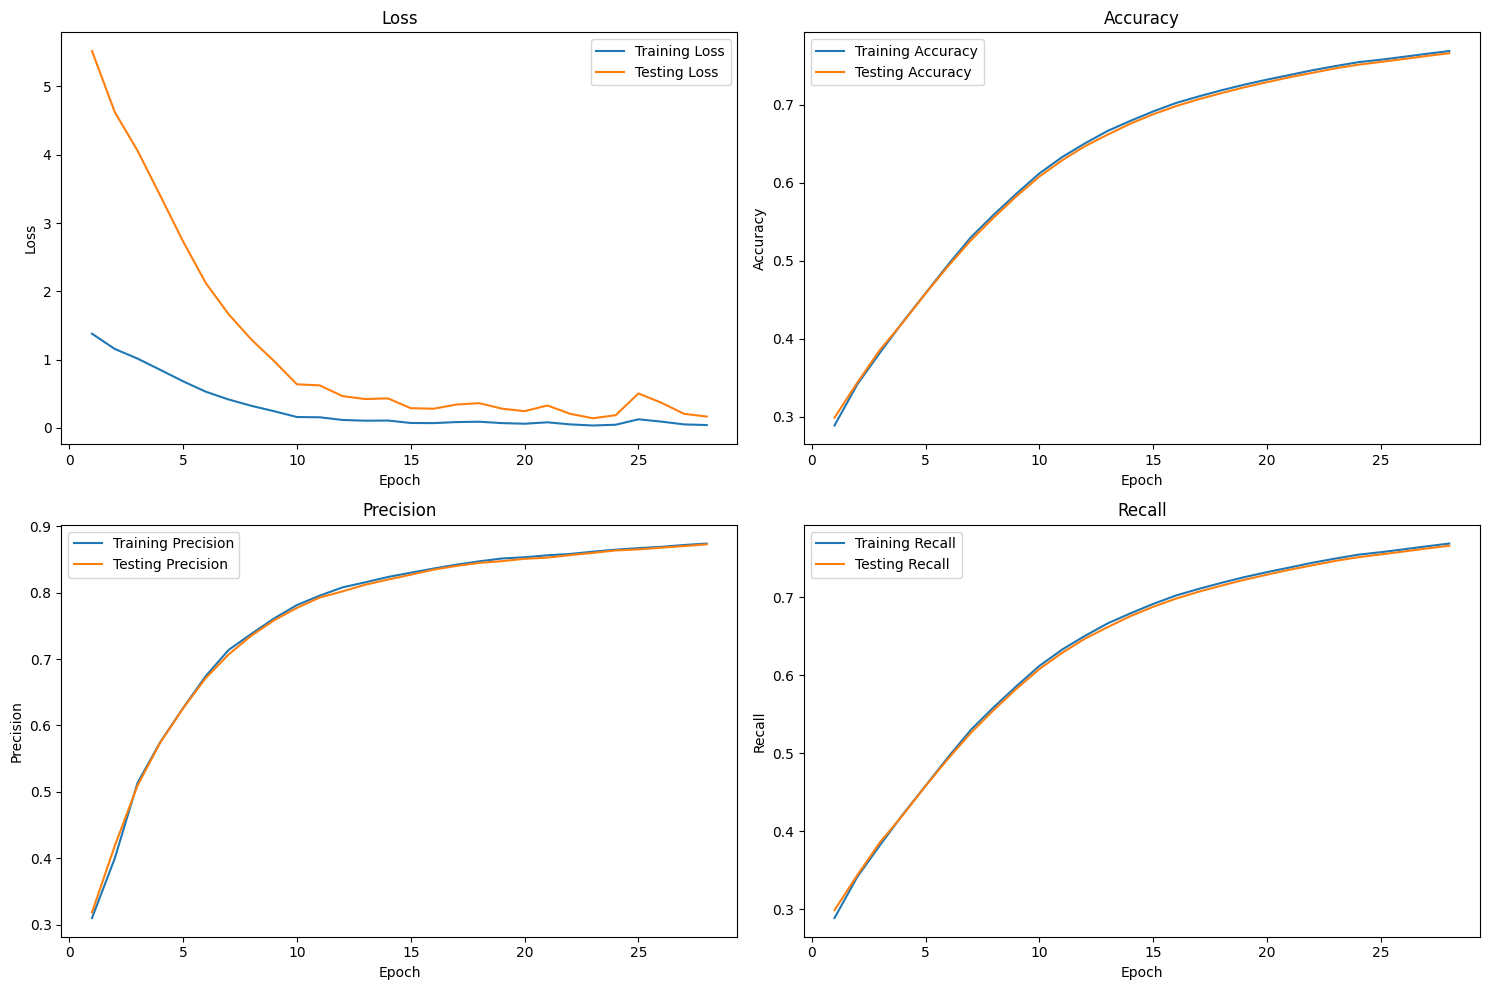

In [35]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [36]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction con conjunto de capas cambio de learning rate a 0.00001(data augmentation)

In [37]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.00001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.4687, Training Accuracy: 0.1752, Training Precision: 0.2195, Training Recall: 0.1752


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 5.8748, Testing Accuracy: 0.1906, Testing Precision: 0.2562, Testing Recall: 0.1906


Training Epoch 2/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.2628, Training Accuracy: 0.2530, Training Precision: 0.3694, Training Recall: 0.2530


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 5.0514, Testing Accuracy: 0.2597, Testing Precision: 0.3667, Testing Recall: 0.2597


Training Epoch 3/100: 100%|████████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 1.1631, Training Accuracy: 0.2960, Training Precision: 0.4129, Training Recall: 0.2960


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 4.6523, Testing Accuracy: 0.2998, Testing Precision: 0.4139, Testing Recall: 0.2998


Training Epoch 4/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.0754, Training Accuracy: 0.3229, Training Precision: 0.4889, Training Recall: 0.3229


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 4.3017, Testing Accuracy: 0.3246, Testing Precision: 0.4899, Testing Recall: 0.3246


Training Epoch 5/100: 100%|████████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.9898, Training Accuracy: 0.3457, Training Precision: 0.5188, Training Recall: 0.3457


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 3.9593, Testing Accuracy: 0.3472, Testing Precision: 0.5162, Testing Recall: 0.3472


Training Epoch 6/100: 100%|████████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.9071, Training Accuracy: 0.3677, Training Precision: 0.5855, Training Recall: 0.3677


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.6285, Testing Accuracy: 0.3684, Testing Precision: 0.5818, Testing Recall: 0.3684


Training Epoch 7/100: 100%|████████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.8194, Training Accuracy: 0.3885, Training Precision: 0.6281, Training Recall: 0.3885


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.2776, Testing Accuracy: 0.3886, Testing Precision: 0.6264, Testing Recall: 0.3886


Training Epoch 8/100: 100%|████████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.7284, Training Accuracy: 0.4088, Training Precision: 0.6593, Training Recall: 0.4088


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 2.9138, Testing Accuracy: 0.4087, Testing Precision: 0.6547, Testing Recall: 0.4087


Training Epoch 9/100: 100%|████████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.6452, Training Accuracy: 0.4300, Training Precision: 0.6899, Training Recall: 0.4300


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 2.5807, Testing Accuracy: 0.4295, Testing Precision: 0.6862, Testing Recall: 0.4295


Training Epoch 10/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.5545, Training Accuracy: 0.4509, Training Precision: 0.7145, Training Recall: 0.4509


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 2.2179, Testing Accuracy: 0.4508, Testing Precision: 0.7120, Testing Recall: 0.4508


Training Epoch 11/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.4757, Training Accuracy: 0.4725, Training Precision: 0.7394, Training Recall: 0.4725


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 1.9027, Testing Accuracy: 0.4715, Testing Precision: 0.7356, Testing Recall: 0.4715


Training Epoch 12/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.4030, Training Accuracy: 0.4919, Training Precision: 0.7571, Training Recall: 0.4919


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 1.6119, Testing Accuracy: 0.4909, Testing Precision: 0.7529, Testing Recall: 0.4909


Training Epoch 13/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.3265, Training Accuracy: 0.5117, Training Precision: 0.7741, Training Recall: 0.5117


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 1.3060, Testing Accuracy: 0.5108, Testing Precision: 0.7704, Testing Recall: 0.5108


Training Epoch 14/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.2718, Training Accuracy: 0.5314, Training Precision: 0.7896, Training Recall: 0.5314


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 1.0870, Testing Accuracy: 0.5297, Testing Precision: 0.7870, Testing Recall: 0.5297


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.2208, Training Accuracy: 0.5496, Training Precision: 0.8031, Training Recall: 0.5496


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.8830, Testing Accuracy: 0.5478, Testing Precision: 0.8010, Testing Recall: 0.5478


Training Epoch 16/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.1736, Training Accuracy: 0.5671, Training Precision: 0.8142, Training Recall: 0.5671


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.6944, Testing Accuracy: 0.5652, Testing Precision: 0.8117, Testing Recall: 0.5652


Training Epoch 17/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.1373, Training Accuracy: 0.5835, Training Precision: 0.8233, Training Recall: 0.5835


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.5494, Testing Accuracy: 0.5814, Testing Precision: 0.8211, Testing Recall: 0.5814


Training Epoch 18/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.1106, Training Accuracy: 0.5984, Training Precision: 0.8319, Training Recall: 0.5984


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.44batch/s]


Testing Loss: 0.4424, Testing Accuracy: 0.5962, Testing Precision: 0.8298, Testing Recall: 0.5962


Training Epoch 19/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0884, Training Accuracy: 0.6124, Training Precision: 0.8395, Training Recall: 0.6124


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.3537, Testing Accuracy: 0.6104, Testing Precision: 0.8372, Testing Recall: 0.6104


Training Epoch 20/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0715, Training Accuracy: 0.6255, Training Precision: 0.8458, Training Recall: 0.6255


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.2861, Testing Accuracy: 0.6235, Testing Precision: 0.8436, Testing Recall: 0.6235


Training Epoch 21/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0550, Training Accuracy: 0.6376, Training Precision: 0.8513, Training Recall: 0.6376


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.2201, Testing Accuracy: 0.6356, Testing Precision: 0.8489, Testing Recall: 0.6356


Training Epoch 22/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0462, Training Accuracy: 0.6486, Training Precision: 0.8558, Training Recall: 0.6486


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.1850, Testing Accuracy: 0.6464, Testing Precision: 0.8541, Testing Recall: 0.6464


Training Epoch 23/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0375, Training Accuracy: 0.6585, Training Precision: 0.8605, Training Recall: 0.6585


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.1500, Testing Accuracy: 0.6563, Testing Precision: 0.8586, Testing Recall: 0.6563


Training Epoch 24/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0305, Training Accuracy: 0.6677, Training Precision: 0.8644, Training Recall: 0.6677


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.1220, Testing Accuracy: 0.6656, Testing Precision: 0.8624, Testing Recall: 0.6656


Training Epoch 25/100: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0259, Training Accuracy: 0.6763, Training Precision: 0.8677, Training Recall: 0.6763


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.1035, Testing Accuracy: 0.6744, Testing Precision: 0.8651, Testing Recall: 0.6744


Training Epoch 26/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0211, Training Accuracy: 0.6843, Training Precision: 0.8701, Training Recall: 0.6843


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0846, Testing Accuracy: 0.6825, Testing Precision: 0.8681, Testing Recall: 0.6825


Training Epoch 27/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0180, Training Accuracy: 0.6918, Training Precision: 0.8727, Training Recall: 0.6918


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0720, Testing Accuracy: 0.6898, Testing Precision: 0.8711, Testing Recall: 0.6898


Training Epoch 28/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0149, Training Accuracy: 0.6986, Training Precision: 0.8755, Training Recall: 0.6986


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0597, Testing Accuracy: 0.6966, Testing Precision: 0.8740, Testing Recall: 0.6966


Training Epoch 29/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0141, Training Accuracy: 0.7049, Training Precision: 0.8780, Training Recall: 0.7049


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0563, Testing Accuracy: 0.7029, Testing Precision: 0.8765, Testing Recall: 0.7029


Training Epoch 30/100: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0120, Training Accuracy: 0.7108, Training Precision: 0.8804, Training Recall: 0.7108


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0479, Testing Accuracy: 0.7090, Testing Precision: 0.8783, Testing Recall: 0.7090


Training Epoch 31/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0105, Training Accuracy: 0.7165, Training Precision: 0.8819, Training Recall: 0.7165


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0421, Testing Accuracy: 0.7146, Testing Precision: 0.8802, Testing Recall: 0.7146


Training Epoch 32/100: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0102, Training Accuracy: 0.7217, Training Precision: 0.8837, Training Recall: 0.7217


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0409, Testing Accuracy: 0.7198, Testing Precision: 0.8820, Testing Recall: 0.7198


Training Epoch 33/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0076, Training Accuracy: 0.7266, Training Precision: 0.8853, Training Recall: 0.7266


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0303, Testing Accuracy: 0.7247, Testing Precision: 0.8839, Testing Recall: 0.7247


Training Epoch 34/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0065, Training Accuracy: 0.7311, Training Precision: 0.8870, Training Recall: 0.7311


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0259, Testing Accuracy: 0.7293, Testing Precision: 0.8855, Testing Recall: 0.7293


Training Epoch 35/100: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0066, Training Accuracy: 0.7354, Training Precision: 0.8885, Training Recall: 0.7354


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0263, Testing Accuracy: 0.7336, Testing Precision: 0.8870, Testing Recall: 0.7336


Training Epoch 36/100: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0050, Training Accuracy: 0.7395, Training Precision: 0.8899, Training Recall: 0.7395


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0202, Testing Accuracy: 0.7376, Testing Precision: 0.8885, Testing Recall: 0.7376


Training Epoch 37/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0051, Training Accuracy: 0.7432, Training Precision: 0.8912, Training Recall: 0.7432


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0206, Testing Accuracy: 0.7415, Testing Precision: 0.8897, Testing Recall: 0.7415


Training Epoch 38/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0044, Training Accuracy: 0.7470, Training Precision: 0.8923, Training Recall: 0.7470


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0174, Testing Accuracy: 0.7452, Testing Precision: 0.8911, Testing Recall: 0.7452


Training Epoch 39/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0038, Training Accuracy: 0.7504, Training Precision: 0.8936, Training Recall: 0.7504


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0152, Testing Accuracy: 0.7488, Testing Precision: 0.8921, Testing Recall: 0.7488


Training Epoch 40/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0035, Training Accuracy: 0.7537, Training Precision: 0.8946, Training Recall: 0.7537


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0140, Testing Accuracy: 0.7520, Testing Precision: 0.8934, Testing Recall: 0.7520


Training Epoch 41/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0032, Training Accuracy: 0.7568, Training Precision: 0.8957, Training Recall: 0.7568


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.7552, Testing Precision: 0.8945, Testing Recall: 0.7552


Training Epoch 42/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0024, Training Accuracy: 0.7598, Training Precision: 0.8967, Training Recall: 0.7598


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.0095, Testing Accuracy: 0.7582, Testing Precision: 0.8956, Testing Recall: 0.7582


Training Epoch 43/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0020, Training Accuracy: 0.7627, Training Precision: 0.8978, Training Recall: 0.7627


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.0082, Testing Accuracy: 0.7610, Testing Precision: 0.8966, Testing Recall: 0.7610


Training Epoch 44/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0024, Training Accuracy: 0.7653, Training Precision: 0.8987, Training Recall: 0.7653


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0098, Testing Accuracy: 0.7637, Testing Precision: 0.8975, Testing Recall: 0.7637


Training Epoch 45/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0021, Training Accuracy: 0.7679, Training Precision: 0.8995, Training Recall: 0.7679


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0083, Testing Accuracy: 0.7664, Testing Precision: 0.8982, Testing Recall: 0.7664


Training Epoch 46/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0028, Training Accuracy: 0.7704, Training Precision: 0.9001, Training Recall: 0.7704


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.7688, Testing Precision: 0.8991, Testing Recall: 0.7688


Training Epoch 47/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0148, Training Accuracy: 0.7727, Training Precision: 0.9010, Training Recall: 0.7727


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0590, Testing Accuracy: 0.7711, Testing Precision: 0.9000, Testing Recall: 0.7711


Training Epoch 48/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.1159, Training Accuracy: 0.7744, Training Precision: 0.9014, Training Recall: 0.7744


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]

Testing Loss: 0.4635, Testing Accuracy: 0.7729, Testing Precision: 0.8999, Testing Recall: 0.7729
No improvement for 5 epochs. Early stopping...


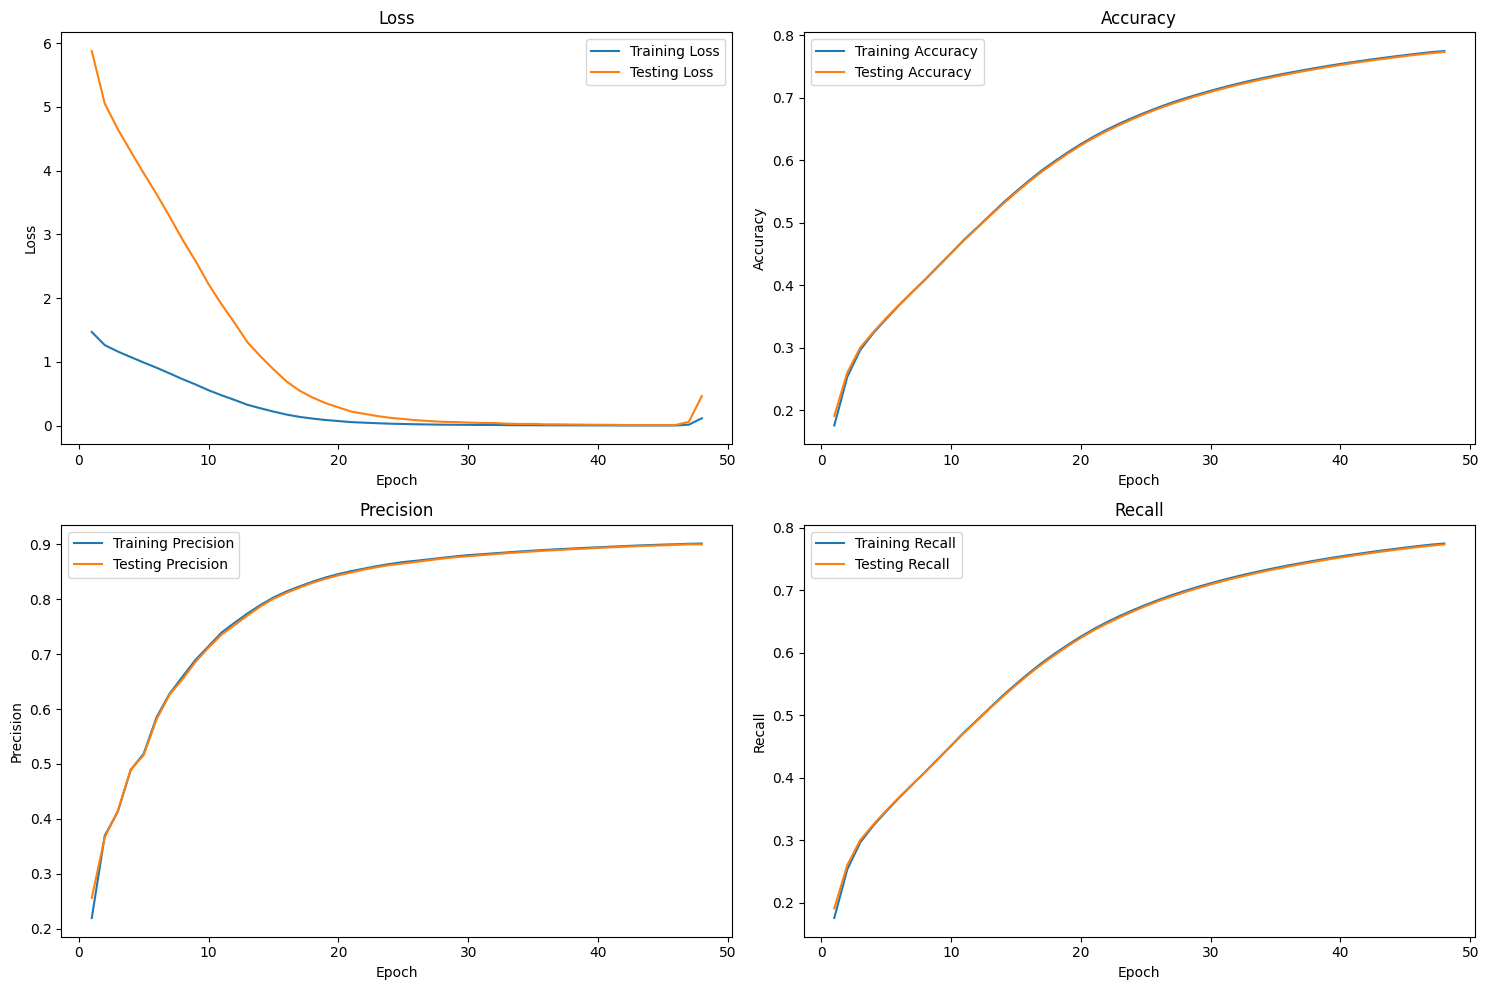

In [38]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [39]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Hipertensión, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Diabetes
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction con clasificador de conjunto de capas cambio de learning rate a 0.00001(data augmentation) y loss ponderada

In [22]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = weights

    def forward(self, outputs, labels):
        loss = F.cross_entropy(outputs, labels, weight=self.weights)
        return loss


In [24]:
from collections import Counter
# Obtener todas las etiquetas del dataset
all_labels = []
for idx in range(len(dataset)):
    _, label = dataset[idx]
    all_labels.append(label.item())

# Calcular la frecuencia de cada clase
class_frequency = Counter(all_labels)

# Calcular los pesos inversamente proporcionales a la frecuencia de clase
class_weights = {class_label: 1 / frequency for class_label, frequency in class_frequency.items()}


for class_label, weight in class_weights.items():
    print(f"Clase {class_label}: Peso {weight}")

Clase 0: Peso 0.0003480682213713888
Clase 1: Peso 0.0006218905472636816
Clase 7: Peso 0.0014124293785310734
Clase 6: Peso 0.004310344827586207
Clase 5: Peso 0.0078125
Clase 3: Peso 0.0034129692832764505
Clase 4: Peso 0.0037593984962406013
Clase 2: Peso 0.0035211267605633804


In [25]:
sorted_class_weights = sorted(class_weights.items())
weights_values = [weight for _, weight in sorted_class_weights]

In [26]:
class_weights_tensor = torch.Tensor(weights_values)

In [63]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.00001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer.weight = class_weights_tensor.to(device)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 1.4817, Training Accuracy: 0.1723, Training Precision: 0.2612, Training Recall: 0.1723


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 5.9267, Testing Accuracy: 0.1914, Testing Precision: 0.3052, Testing Recall: 0.1914


Training Epoch 2/100: 100%|████████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 1.2655, Training Accuracy: 0.2515, Training Precision: 0.3457, Training Recall: 0.2515


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 5.0621, Testing Accuracy: 0.2600, Testing Precision: 0.3410, Testing Recall: 0.2600


Training Epoch 3/100: 100%|████████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 1.1559, Training Accuracy: 0.2978, Training Precision: 0.4216, Training Recall: 0.2978


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 4.6238, Testing Accuracy: 0.3004, Testing Precision: 0.4204, Testing Recall: 0.3004


Training Epoch 4/100: 100%|████████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 1.0736, Training Accuracy: 0.3241, Training Precision: 0.4543, Training Recall: 0.3241


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 4.2942, Testing Accuracy: 0.3261, Testing Precision: 0.4539, Testing Recall: 0.3261


Training Epoch 5/100: 100%|████████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.9882, Training Accuracy: 0.3477, Training Precision: 0.5086, Training Recall: 0.3477


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 3.9526, Testing Accuracy: 0.3487, Testing Precision: 0.5075, Testing Recall: 0.3487


Training Epoch 6/100: 100%|████████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.9131, Training Accuracy: 0.3695, Training Precision: 0.5713, Training Recall: 0.3695


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 3.6523, Testing Accuracy: 0.3697, Testing Precision: 0.5687, Testing Recall: 0.3697


Training Epoch 7/100: 100%|████████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.8258, Training Accuracy: 0.3893, Training Precision: 0.6070, Training Recall: 0.3893


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 3.3031, Testing Accuracy: 0.3897, Testing Precision: 0.6092, Testing Recall: 0.3897


Training Epoch 8/100: 100%|████████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.7318, Training Accuracy: 0.4110, Training Precision: 0.6466, Training Recall: 0.4110


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 2.9273, Testing Accuracy: 0.4103, Testing Precision: 0.6446, Testing Recall: 0.4103


Training Epoch 9/100: 100%|████████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.6442, Training Accuracy: 0.4312, Training Precision: 0.6745, Training Recall: 0.4312


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 2.5766, Testing Accuracy: 0.4315, Testing Precision: 0.6704, Testing Recall: 0.4315


Training Epoch 10/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.5640, Training Accuracy: 0.4528, Training Precision: 0.6978, Training Recall: 0.4528


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 2.2560, Testing Accuracy: 0.4518, Testing Precision: 0.6954, Testing Recall: 0.4518


Training Epoch 11/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.4842, Training Accuracy: 0.4730, Training Precision: 0.7246, Training Recall: 0.4730


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 1.9370, Testing Accuracy: 0.4719, Testing Precision: 0.7222, Testing Recall: 0.4719


Training Epoch 12/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.4039, Training Accuracy: 0.4933, Training Precision: 0.7469, Training Recall: 0.4933


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.74batch/s]


Testing Loss: 1.6158, Testing Accuracy: 0.4926, Testing Precision: 0.7425, Testing Recall: 0.4926


Training Epoch 13/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.3213, Training Accuracy: 0.5140, Training Precision: 0.7666, Training Recall: 0.5140


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 1.2853, Testing Accuracy: 0.5128, Testing Precision: 0.7634, Testing Recall: 0.5128


Training Epoch 14/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.2644, Training Accuracy: 0.5335, Training Precision: 0.7825, Training Recall: 0.5335


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 1.0577, Testing Accuracy: 0.5324, Testing Precision: 0.7798, Testing Recall: 0.5324


Training Epoch 15/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.2138, Training Accuracy: 0.5523, Training Precision: 0.7974, Training Recall: 0.5523


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.8553, Testing Accuracy: 0.5505, Testing Precision: 0.7957, Testing Recall: 0.5505


Training Epoch 16/100: 100%|███████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.1662, Training Accuracy: 0.5695, Training Precision: 0.8102, Training Recall: 0.5695


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.6648, Testing Accuracy: 0.5679, Testing Precision: 0.8070, Testing Recall: 0.5679


Training Epoch 17/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.1387, Training Accuracy: 0.5860, Training Precision: 0.8197, Training Recall: 0.5860


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 0.5547, Testing Accuracy: 0.5844, Testing Precision: 0.8159, Testing Recall: 0.5844


Training Epoch 18/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.1085, Training Accuracy: 0.6015, Training Precision: 0.8276, Training Recall: 0.6015


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.4338, Testing Accuracy: 0.5996, Testing Precision: 0.8253, Testing Recall: 0.5996


Training Epoch 19/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0864, Training Accuracy: 0.6154, Training Precision: 0.8352, Training Recall: 0.6154


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.3458, Testing Accuracy: 0.6134, Testing Precision: 0.8324, Testing Recall: 0.6134


Training Epoch 20/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0670, Training Accuracy: 0.6284, Training Precision: 0.8415, Training Recall: 0.6284


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.2680, Testing Accuracy: 0.6263, Testing Precision: 0.8393, Testing Recall: 0.6263


Training Epoch 21/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0553, Training Accuracy: 0.6402, Training Precision: 0.8475, Training Recall: 0.6402


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.2210, Testing Accuracy: 0.6384, Testing Precision: 0.8446, Testing Recall: 0.6384


Training Epoch 22/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0451, Training Accuracy: 0.6513, Training Precision: 0.8520, Training Recall: 0.6513


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.1806, Testing Accuracy: 0.6494, Testing Precision: 0.8493, Testing Recall: 0.6494


Training Epoch 23/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0383, Training Accuracy: 0.6614, Training Precision: 0.8560, Training Recall: 0.6614


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.1532, Testing Accuracy: 0.6594, Testing Precision: 0.8541, Testing Recall: 0.6594


Training Epoch 24/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0316, Training Accuracy: 0.6707, Training Precision: 0.8603, Training Recall: 0.6707


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.1262, Testing Accuracy: 0.6686, Testing Precision: 0.8585, Testing Recall: 0.6686


Training Epoch 25/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0248, Training Accuracy: 0.6791, Training Precision: 0.8642, Training Recall: 0.6791


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0993, Testing Accuracy: 0.6771, Testing Precision: 0.8622, Testing Recall: 0.6771


Training Epoch 26/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0209, Training Accuracy: 0.6870, Training Precision: 0.8674, Training Recall: 0.6870


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0835, Testing Accuracy: 0.6850, Testing Precision: 0.8655, Testing Recall: 0.6850


Training Epoch 27/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0180, Training Accuracy: 0.6943, Training Precision: 0.8704, Training Recall: 0.6943


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0720, Testing Accuracy: 0.6923, Testing Precision: 0.8683, Testing Recall: 0.6923


Training Epoch 28/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0137, Training Accuracy: 0.7011, Training Precision: 0.8728, Training Recall: 0.7011


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0547, Testing Accuracy: 0.6990, Testing Precision: 0.8715, Testing Recall: 0.6990


Training Epoch 29/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0145, Training Accuracy: 0.7072, Training Precision: 0.8757, Training Recall: 0.7072


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0580, Testing Accuracy: 0.7052, Testing Precision: 0.8739, Testing Recall: 0.7052


Training Epoch 30/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0120, Training Accuracy: 0.7130, Training Precision: 0.8779, Training Recall: 0.7130


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0481, Testing Accuracy: 0.7111, Testing Precision: 0.8760, Testing Recall: 0.7111


Training Epoch 31/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0096, Training Accuracy: 0.7185, Training Precision: 0.8798, Training Recall: 0.7185


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.0384, Testing Accuracy: 0.7166, Testing Precision: 0.8784, Testing Recall: 0.7166


Training Epoch 32/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0091, Training Accuracy: 0.7236, Training Precision: 0.8819, Training Recall: 0.7236


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0364, Testing Accuracy: 0.7217, Testing Precision: 0.8802, Testing Recall: 0.7217


Training Epoch 33/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0075, Training Accuracy: 0.7284, Training Precision: 0.8836, Training Recall: 0.7284


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0299, Testing Accuracy: 0.7265, Testing Precision: 0.8822, Testing Recall: 0.7265


Training Epoch 34/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0065, Training Accuracy: 0.7329, Training Precision: 0.8854, Training Recall: 0.7329


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0260, Testing Accuracy: 0.7310, Testing Precision: 0.8842, Testing Recall: 0.7310


Training Epoch 35/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0058, Training Accuracy: 0.7371, Training Precision: 0.8873, Training Recall: 0.7371


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0233, Testing Accuracy: 0.7352, Testing Precision: 0.8860, Testing Recall: 0.7352


Training Epoch 36/100: 100%|███████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 0.0055, Training Accuracy: 0.7410, Training Precision: 0.8889, Training Recall: 0.7410


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0219, Testing Accuracy: 0.7392, Testing Precision: 0.8876, Testing Recall: 0.7392


Training Epoch 37/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0048, Training Accuracy: 0.7448, Training Precision: 0.8904, Training Recall: 0.7448


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0194, Testing Accuracy: 0.7430, Testing Precision: 0.8892, Testing Recall: 0.7430


Training Epoch 38/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0045, Training Accuracy: 0.7484, Training Precision: 0.8918, Training Recall: 0.7484


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 0.0182, Testing Accuracy: 0.7467, Testing Precision: 0.8904, Testing Recall: 0.7467


Training Epoch 39/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0038, Training Accuracy: 0.7518, Training Precision: 0.8930, Training Recall: 0.7518


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.0154, Testing Accuracy: 0.7501, Testing Precision: 0.8916, Testing Recall: 0.7501


Training Epoch 40/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0029, Training Accuracy: 0.7551, Training Precision: 0.8940, Training Recall: 0.7551


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0117, Testing Accuracy: 0.7533, Testing Precision: 0.8926, Testing Recall: 0.7533


Training Epoch 41/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0027, Training Accuracy: 0.7581, Training Precision: 0.8949, Training Recall: 0.7581


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.7565, Testing Precision: 0.8939, Testing Recall: 0.7565


Training Epoch 42/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.7611, Training Precision: 0.8961, Training Recall: 0.7611


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.7594, Testing Precision: 0.8951, Testing Recall: 0.7594


Training Epoch 43/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0022, Training Accuracy: 0.7638, Training Precision: 0.8972, Training Recall: 0.7638


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0090, Testing Accuracy: 0.7622, Testing Precision: 0.8961, Testing Recall: 0.7622


Training Epoch 44/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0024, Training Accuracy: 0.7665, Training Precision: 0.8982, Training Recall: 0.7665


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0094, Testing Accuracy: 0.7649, Testing Precision: 0.8970, Testing Recall: 0.7649


Training Epoch 45/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0019, Training Accuracy: 0.7691, Training Precision: 0.8991, Training Recall: 0.7691


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0076, Testing Accuracy: 0.7675, Testing Precision: 0.8979, Testing Recall: 0.7675


Training Epoch 46/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0016, Training Accuracy: 0.7715, Training Precision: 0.8999, Training Recall: 0.7715


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0065, Testing Accuracy: 0.7700, Testing Precision: 0.8987, Testing Recall: 0.7700


Training Epoch 47/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0017, Training Accuracy: 0.7739, Training Precision: 0.9006, Training Recall: 0.7739


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0067, Testing Accuracy: 0.7723, Testing Precision: 0.8995, Testing Recall: 0.7723


Training Epoch 48/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0019, Training Accuracy: 0.7761, Training Precision: 0.9014, Training Recall: 0.7761


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0075, Testing Accuracy: 0.7746, Testing Precision: 0.9001, Testing Recall: 0.7746


Training Epoch 49/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0011, Training Accuracy: 0.7783, Training Precision: 0.9019, Training Recall: 0.7783


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0045, Testing Accuracy: 0.7768, Testing Precision: 0.9009, Testing Recall: 0.7768


Training Epoch 50/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0011, Training Accuracy: 0.7803, Training Precision: 0.9027, Training Recall: 0.7803


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0043, Testing Accuracy: 0.7788, Testing Precision: 0.9016, Testing Recall: 0.7788


Training Epoch 51/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0011, Training Accuracy: 0.7823, Training Precision: 0.9034, Training Recall: 0.7823


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0043, Testing Accuracy: 0.7808, Testing Precision: 0.9024, Testing Recall: 0.7808


Training Epoch 52/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0009, Training Accuracy: 0.7842, Training Precision: 0.9041, Training Recall: 0.7842


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0034, Testing Accuracy: 0.7827, Testing Precision: 0.9032, Testing Recall: 0.7827


Training Epoch 53/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0007, Training Accuracy: 0.7859, Training Precision: 0.9048, Training Recall: 0.7859


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0030, Testing Accuracy: 0.7845, Testing Precision: 0.9040, Testing Recall: 0.7845


Training Epoch 54/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0008, Training Accuracy: 0.7877, Training Precision: 0.9055, Training Recall: 0.7877


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0031, Testing Accuracy: 0.7863, Testing Precision: 0.9047, Testing Recall: 0.7863


Training Epoch 55/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0016, Training Accuracy: 0.7894, Training Precision: 0.9063, Training Recall: 0.7894


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0065, Testing Accuracy: 0.7880, Testing Precision: 0.9055, Testing Recall: 0.7880


Training Epoch 56/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0945, Training Accuracy: 0.7906, Training Precision: 0.9067, Training Recall: 0.7906


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.3780, Testing Accuracy: 0.7894, Testing Precision: 0.9058, Testing Recall: 0.7894


Training Epoch 57/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0296, Training Accuracy: 0.7922, Training Precision: 0.9072, Training Recall: 0.7922


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.1183, Testing Accuracy: 0.7908, Testing Precision: 0.9064, Testing Recall: 0.7908


Training Epoch 58/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0099, Training Accuracy: 0.7937, Training Precision: 0.9078, Training Recall: 0.7937


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]

Testing Loss: 0.0396, Testing Accuracy: 0.7923, Testing Precision: 0.9070, Testing Recall: 0.7923
No improvement for 5 epochs. Early stopping...


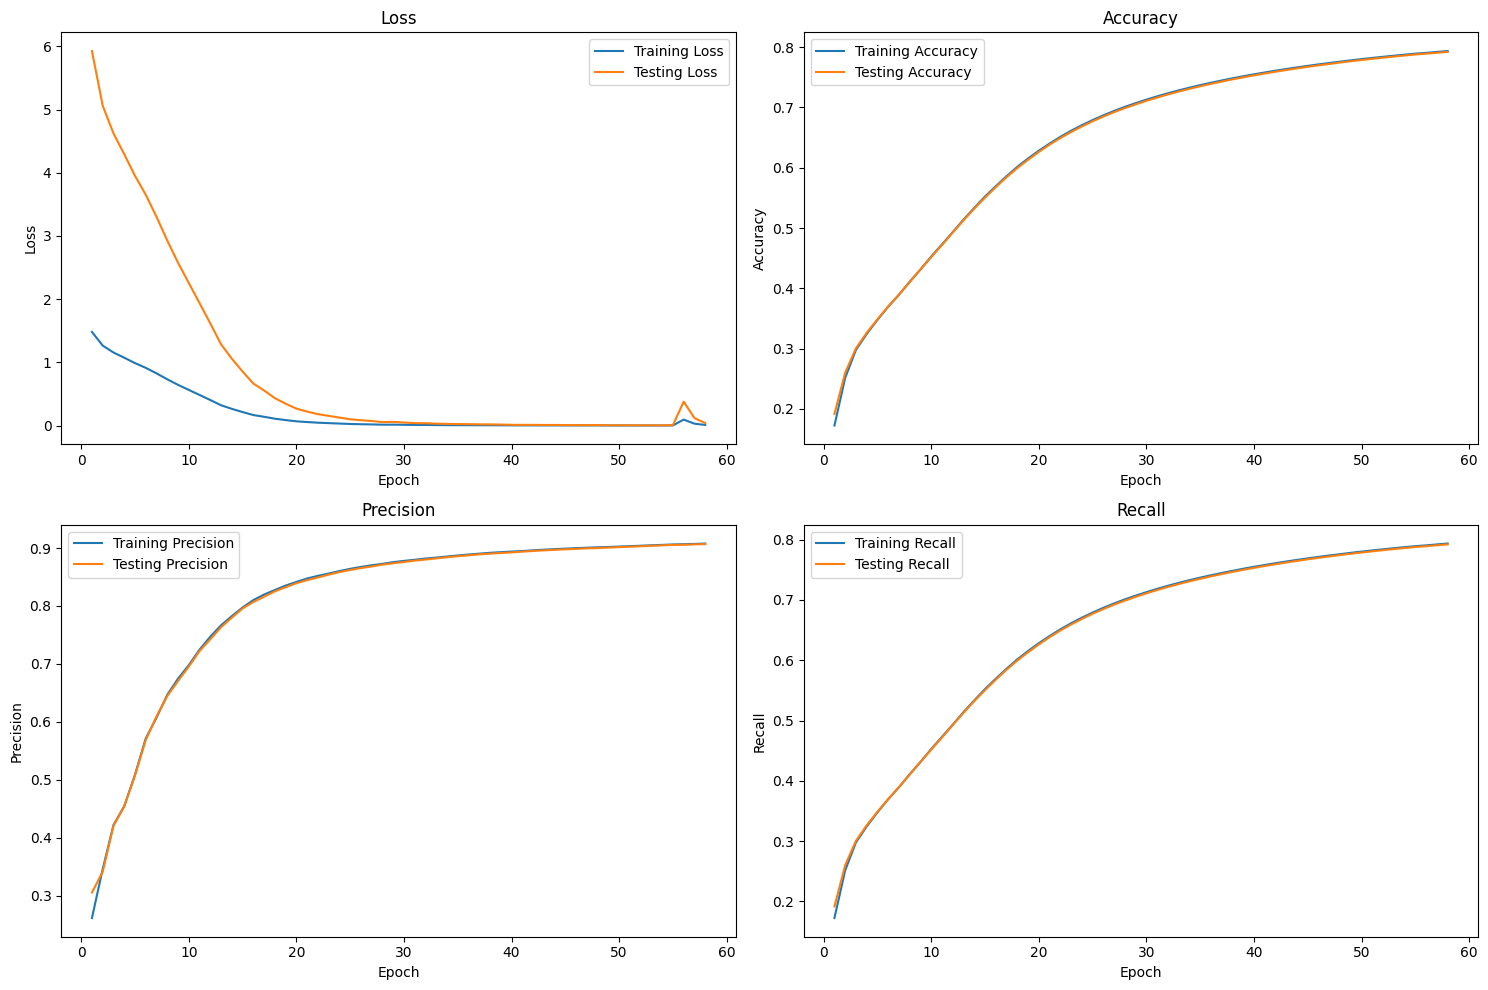

In [64]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [65]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction clasificador de conjunto de capas cambio de learning rate variable (data augmentation) y loss ponderada 100 epochs

In [69]:
torch.cuda.empty_cache()
num_epochs = 100
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

# Definir la tasa de aprendizaje inicial y el decaimiento
initial_learning_rate = 0.00001
lr_decay_step_size = 30
lr_decay_gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
optimizer.weight = class_weights_tensor.to(device)

# Programar el decaimiento de la tasa de aprendizaje
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)


In [70]:
def train_and_evaluate_variable_lr(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, num_classes=8, early_stopping=False, patience=5):
    if early_stopping:
        best_loss = float('inf')
        no_improvement_count = 0

    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            

            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy.compute()
        train_accuracies.append(train_accuracy)
        train_precision = precision.compute()
        train_precisions.append(train_precision)
        train_recall = recall.compute()
        train_recalls.append(train_recall)

            #train_predictions.extend(predicted.cpu().tolist())
            #train_targets.extend(labels.cpu().tolist())



        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}')

        # Evaluación del modelo en el conjunto de datos de prueba
        model.eval()
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}', unit='batch'):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
              

                accuracy.update(predicted, labels)
                precision.update(predicted, labels)
                recall.update(predicted, labels)

                #test_predictions.extend(predicted.cpu().tolist())
                #test_targets.extend(labels.cpu().tolist())
        test_loss = running_loss/len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = accuracy.compute()
        test_accuracies.append(test_accuracy)
        test_precision = precision.compute()
        test_precisions.append(test_precision)
        test_recall = recall.compute()
        test_recalls.append(test_recall)

        print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}, Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}')

        if early_stopping:
            if test_loss < best_loss:
                best_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'No improvement for {patience} epochs. Early stopping...')
                break
    
        scheduler.step()
    return train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls

In [71]:
train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate_variable_lr(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=False, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 1.4835, Training Accuracy: 0.1664, Training Precision: 0.2233, Training Recall: 0.1664


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 5.9339, Testing Accuracy: 0.1816, Testing Precision: 0.2564, Testing Recall: 0.1816


Training Epoch 2/100: 100%|████████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 1.2618, Training Accuracy: 0.2471, Training Precision: 0.3142, Training Recall: 0.2471


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 5.0472, Testing Accuracy: 0.2561, Testing Precision: 0.3145, Testing Recall: 0.2561


Training Epoch 3/100: 100%|████████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 1.1570, Training Accuracy: 0.2923, Training Precision: 0.4262, Training Recall: 0.2923


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 4.6280, Testing Accuracy: 0.2967, Testing Precision: 0.4294, Testing Recall: 0.2967


Training Epoch 4/100: 100%|████████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 1.0791, Training Accuracy: 0.3216, Training Precision: 0.4901, Training Recall: 0.3216


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 4.3162, Testing Accuracy: 0.3238, Testing Precision: 0.4788, Testing Recall: 0.3238


Training Epoch 5/100: 100%|████████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.9904, Training Accuracy: 0.3458, Training Precision: 0.5370, Training Recall: 0.3458


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 3.9618, Testing Accuracy: 0.3467, Testing Precision: 0.5302, Testing Recall: 0.3467


Training Epoch 6/100: 100%|████████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.9073, Training Accuracy: 0.3692, Training Precision: 0.5927, Training Recall: 0.3692


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 3.6291, Testing Accuracy: 0.3708, Testing Precision: 0.5929, Testing Recall: 0.3708


Training Epoch 7/100: 100%|████████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.8215, Training Accuracy: 0.3900, Training Precision: 0.6249, Training Recall: 0.3900


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 3.2858, Testing Accuracy: 0.3907, Testing Precision: 0.6221, Testing Recall: 0.3907


Training Epoch 8/100: 100%|████████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.7339, Training Accuracy: 0.4126, Training Precision: 0.6657, Training Recall: 0.4126


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 2.9358, Testing Accuracy: 0.4127, Testing Precision: 0.6622, Testing Recall: 0.4127


Training Epoch 9/100: 100%|████████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.6444, Training Accuracy: 0.4336, Training Precision: 0.6912, Training Recall: 0.4336


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 2.5775, Testing Accuracy: 0.4330, Testing Precision: 0.6871, Testing Recall: 0.4330


Training Epoch 10/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.5577, Training Accuracy: 0.4542, Training Precision: 0.7155, Training Recall: 0.4542


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 2.2308, Testing Accuracy: 0.4541, Testing Precision: 0.7105, Testing Recall: 0.4541


Training Epoch 11/100: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.4702, Training Accuracy: 0.4759, Training Precision: 0.7378, Training Recall: 0.4759


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 1.8809, Testing Accuracy: 0.4751, Testing Precision: 0.7343, Testing Recall: 0.4751


Training Epoch 12/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.3931, Training Accuracy: 0.4959, Training Precision: 0.7559, Training Recall: 0.4959


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 1.5724, Testing Accuracy: 0.4945, Testing Precision: 0.7531, Testing Recall: 0.4945


Training Epoch 13/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.3258, Training Accuracy: 0.5153, Training Precision: 0.7736, Training Recall: 0.5153


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 1.3031, Testing Accuracy: 0.5138, Testing Precision: 0.7709, Testing Recall: 0.5138


Training Epoch 14/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.2713, Training Accuracy: 0.5338, Training Precision: 0.7868, Training Recall: 0.5338


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 1.0852, Testing Accuracy: 0.5318, Testing Precision: 0.7853, Testing Recall: 0.5318


Training Epoch 15/100: 100%|███████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 0.2032, Training Accuracy: 0.5518, Training Precision: 0.8017, Training Recall: 0.5518


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.8127, Testing Accuracy: 0.5499, Testing Precision: 0.7995, Testing Recall: 0.5499


Training Epoch 16/100: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.1749, Training Accuracy: 0.5683, Training Precision: 0.8120, Training Recall: 0.5683


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.6996, Testing Accuracy: 0.5665, Testing Precision: 0.8085, Testing Recall: 0.5665


Training Epoch 17/100: 100%|███████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 0.1348, Training Accuracy: 0.5843, Training Precision: 0.8204, Training Recall: 0.5843


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.5393, Testing Accuracy: 0.5823, Testing Precision: 0.8177, Testing Recall: 0.5823


Training Epoch 18/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.1049, Training Accuracy: 0.5994, Training Precision: 0.8289, Training Recall: 0.5994


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.4194, Testing Accuracy: 0.5973, Testing Precision: 0.8262, Testing Recall: 0.5973


Training Epoch 19/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0874, Training Accuracy: 0.6134, Training Precision: 0.8362, Training Recall: 0.6134


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.3494, Testing Accuracy: 0.6114, Testing Precision: 0.8341, Testing Recall: 0.6114


Training Epoch 20/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0748, Training Accuracy: 0.6263, Training Precision: 0.8429, Training Recall: 0.6263


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.2993, Testing Accuracy: 0.6241, Testing Precision: 0.8409, Testing Recall: 0.6241


Training Epoch 21/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0547, Training Accuracy: 0.6381, Training Precision: 0.8489, Training Recall: 0.6381


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.2187, Testing Accuracy: 0.6359, Testing Precision: 0.8468, Testing Recall: 0.6359


Training Epoch 22/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0452, Training Accuracy: 0.6489, Training Precision: 0.8540, Training Recall: 0.6489


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.1809, Testing Accuracy: 0.6469, Testing Precision: 0.8519, Testing Recall: 0.6469


Training Epoch 23/100: 100%|███████████████| 160/160 [00:47<00:00,  3.37batch/s]


Training Loss: 0.0383, Training Accuracy: 0.6591, Training Precision: 0.8584, Training Recall: 0.6591


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.1531, Testing Accuracy: 0.6569, Testing Precision: 0.8566, Testing Recall: 0.6569


Training Epoch 24/100: 100%|███████████████| 160/160 [00:47<00:00,  3.34batch/s]


Training Loss: 0.0302, Training Accuracy: 0.6682, Training Precision: 0.8625, Training Recall: 0.6682


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.1209, Testing Accuracy: 0.6662, Testing Precision: 0.8598, Testing Recall: 0.6662


Training Epoch 25/100: 100%|███████████████| 160/160 [00:45<00:00,  3.52batch/s]


Training Loss: 0.0250, Training Accuracy: 0.6768, Training Precision: 0.8653, Training Recall: 0.6768


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 0.1001, Testing Accuracy: 0.6748, Testing Precision: 0.8634, Testing Recall: 0.6748


Training Epoch 26/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0210, Training Accuracy: 0.6847, Training Precision: 0.8685, Training Recall: 0.6847


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0840, Testing Accuracy: 0.6826, Testing Precision: 0.8665, Testing Recall: 0.6826


Training Epoch 27/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0181, Training Accuracy: 0.6920, Training Precision: 0.8712, Training Recall: 0.6920


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0725, Testing Accuracy: 0.6898, Testing Precision: 0.8694, Testing Recall: 0.6898


Training Epoch 28/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0160, Training Accuracy: 0.6986, Training Precision: 0.8739, Training Recall: 0.6986


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0638, Testing Accuracy: 0.6966, Testing Precision: 0.8722, Testing Recall: 0.6966


Training Epoch 29/100: 100%|███████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.0134, Training Accuracy: 0.7049, Training Precision: 0.8763, Training Recall: 0.7049


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0538, Testing Accuracy: 0.7029, Testing Precision: 0.8747, Testing Recall: 0.7029


Training Epoch 30/100: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0111, Training Accuracy: 0.7108, Training Precision: 0.8786, Training Recall: 0.7108


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.76batch/s]


Testing Loss: 0.0442, Testing Accuracy: 0.7088, Testing Precision: 0.8771, Testing Recall: 0.7088


Training Epoch 31/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.0088, Training Accuracy: 0.7163, Training Precision: 0.8808, Training Recall: 0.7163


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0353, Testing Accuracy: 0.7143, Testing Precision: 0.8792, Testing Recall: 0.7143


Training Epoch 32/100: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0081, Training Accuracy: 0.7214, Training Precision: 0.8827, Training Recall: 0.7214


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0324, Testing Accuracy: 0.7196, Testing Precision: 0.8810, Testing Recall: 0.7196


Training Epoch 33/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0081, Training Accuracy: 0.7263, Training Precision: 0.8843, Training Recall: 0.7263


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0324, Testing Accuracy: 0.7245, Testing Precision: 0.8827, Testing Recall: 0.7245


Training Epoch 34/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0078, Training Accuracy: 0.7309, Training Precision: 0.8858, Training Recall: 0.7309


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0313, Testing Accuracy: 0.7291, Testing Precision: 0.8843, Testing Recall: 0.7291


Training Epoch 35/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0076, Training Accuracy: 0.7352, Training Precision: 0.8874, Training Recall: 0.7352


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0305, Testing Accuracy: 0.7334, Testing Precision: 0.8859, Testing Recall: 0.7334


Training Epoch 36/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0074, Training Accuracy: 0.7392, Training Precision: 0.8888, Training Recall: 0.7392


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0298, Testing Accuracy: 0.7374, Testing Precision: 0.8874, Testing Recall: 0.7374


Training Epoch 37/100: 100%|███████████████| 160/160 [00:45<00:00,  3.54batch/s]


Training Loss: 0.0072, Training Accuracy: 0.7430, Training Precision: 0.8901, Training Recall: 0.7430


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0286, Testing Accuracy: 0.7412, Testing Precision: 0.8888, Testing Recall: 0.7412


Training Epoch 38/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0071, Training Accuracy: 0.7466, Training Precision: 0.8914, Training Recall: 0.7466


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 0.0285, Testing Accuracy: 0.7449, Testing Precision: 0.8900, Testing Recall: 0.7449


Training Epoch 39/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0070, Training Accuracy: 0.7501, Training Precision: 0.8926, Training Recall: 0.7501


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0278, Testing Accuracy: 0.7483, Testing Precision: 0.8912, Testing Recall: 0.7483


Training Epoch 40/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0066, Training Accuracy: 0.7533, Training Precision: 0.8937, Training Recall: 0.7533


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0264, Testing Accuracy: 0.7516, Testing Precision: 0.8924, Testing Recall: 0.7516


Training Epoch 41/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0066, Training Accuracy: 0.7564, Training Precision: 0.8948, Training Recall: 0.7564


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0263, Testing Accuracy: 0.7548, Testing Precision: 0.8935, Testing Recall: 0.7548


Training Epoch 42/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0064, Training Accuracy: 0.7594, Training Precision: 0.8958, Training Recall: 0.7594


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.0256, Testing Accuracy: 0.7577, Testing Precision: 0.8946, Testing Recall: 0.7577


Training Epoch 43/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0058, Training Accuracy: 0.7622, Training Precision: 0.8968, Training Recall: 0.7622


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0232, Testing Accuracy: 0.7606, Testing Precision: 0.8956, Testing Recall: 0.7606


Training Epoch 44/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0058, Training Accuracy: 0.7649, Training Precision: 0.8977, Training Recall: 0.7649


Testing Epoch 44/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0234, Testing Accuracy: 0.7633, Testing Precision: 0.8965, Testing Recall: 0.7633


Training Epoch 45/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0061, Training Accuracy: 0.7674, Training Precision: 0.8986, Training Recall: 0.7674


Testing Epoch 45/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0245, Testing Accuracy: 0.7659, Testing Precision: 0.8974, Testing Recall: 0.7659


Training Epoch 46/100: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0057, Training Accuracy: 0.7699, Training Precision: 0.8994, Training Recall: 0.7699


Testing Epoch 46/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0229, Testing Accuracy: 0.7684, Testing Precision: 0.8983, Testing Recall: 0.7684


Training Epoch 47/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0056, Training Accuracy: 0.7723, Training Precision: 0.9002, Training Recall: 0.7723


Testing Epoch 47/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0223, Testing Accuracy: 0.7707, Testing Precision: 0.8992, Testing Recall: 0.7707


Training Epoch 48/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0054, Training Accuracy: 0.7745, Training Precision: 0.9010, Training Recall: 0.7745


Testing Epoch 48/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0217, Testing Accuracy: 0.7730, Testing Precision: 0.8999, Testing Recall: 0.7730


Training Epoch 49/100: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0051, Training Accuracy: 0.7767, Training Precision: 0.9018, Training Recall: 0.7767


Testing Epoch 49/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0205, Testing Accuracy: 0.7752, Testing Precision: 0.9007, Testing Recall: 0.7752


Training Epoch 50/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0049, Training Accuracy: 0.7788, Training Precision: 0.9025, Training Recall: 0.7788


Testing Epoch 50/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0196, Testing Accuracy: 0.7773, Testing Precision: 0.9014, Testing Recall: 0.7773


Training Epoch 51/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0051, Training Accuracy: 0.7808, Training Precision: 0.9031, Training Recall: 0.7808


Testing Epoch 51/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0204, Testing Accuracy: 0.7793, Testing Precision: 0.9022, Testing Recall: 0.7793


Training Epoch 52/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0048, Training Accuracy: 0.7827, Training Precision: 0.9038, Training Recall: 0.7827


Testing Epoch 52/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0192, Testing Accuracy: 0.7812, Testing Precision: 0.9028, Testing Recall: 0.7812


Training Epoch 53/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0047, Training Accuracy: 0.7845, Training Precision: 0.9045, Training Recall: 0.7845


Testing Epoch 53/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0189, Testing Accuracy: 0.7831, Testing Precision: 0.9034, Testing Recall: 0.7831


Training Epoch 54/100: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0047, Training Accuracy: 0.7863, Training Precision: 0.9050, Training Recall: 0.7863


Testing Epoch 54/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0188, Testing Accuracy: 0.7849, Testing Precision: 0.9040, Testing Recall: 0.7849


Training Epoch 55/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0040, Training Accuracy: 0.7880, Training Precision: 0.9056, Training Recall: 0.7880


Testing Epoch 55/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0160, Testing Accuracy: 0.7867, Testing Precision: 0.9046, Testing Recall: 0.7867


Training Epoch 56/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0041, Training Accuracy: 0.7897, Training Precision: 0.9061, Training Recall: 0.7897


Testing Epoch 56/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0165, Testing Accuracy: 0.7884, Testing Precision: 0.9051, Testing Recall: 0.7884


Training Epoch 57/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0040, Training Accuracy: 0.7913, Training Precision: 0.9065, Training Recall: 0.7913


Testing Epoch 57/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0161, Testing Accuracy: 0.7900, Testing Precision: 0.9056, Testing Recall: 0.7900


Training Epoch 58/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0039, Training Accuracy: 0.7928, Training Precision: 0.9070, Training Recall: 0.7928


Testing Epoch 58/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0156, Testing Accuracy: 0.7915, Testing Precision: 0.9061, Testing Recall: 0.7915


Training Epoch 59/100: 100%|███████████████| 160/160 [00:43<00:00,  3.72batch/s]


Training Loss: 0.0040, Training Accuracy: 0.7943, Training Precision: 0.9074, Training Recall: 0.7943


Testing Epoch 59/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0160, Testing Accuracy: 0.7930, Testing Precision: 0.9065, Testing Recall: 0.7930


Training Epoch 60/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0035, Training Accuracy: 0.7957, Training Precision: 0.9078, Training Recall: 0.7957


Testing Epoch 60/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0140, Testing Accuracy: 0.7945, Testing Precision: 0.9069, Testing Recall: 0.7945


Training Epoch 61/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0036, Training Accuracy: 0.7972, Training Precision: 0.9082, Training Recall: 0.7972


Testing Epoch 61/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0143, Testing Accuracy: 0.7959, Testing Precision: 0.9073, Testing Recall: 0.7959


Training Epoch 62/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0033, Training Accuracy: 0.7985, Training Precision: 0.9086, Training Recall: 0.7985


Testing Epoch 62/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0130, Testing Accuracy: 0.7973, Testing Precision: 0.9077, Testing Recall: 0.7973


Training Epoch 63/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0033, Training Accuracy: 0.7998, Training Precision: 0.9090, Training Recall: 0.7998


Testing Epoch 63/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.0132, Testing Accuracy: 0.7986, Testing Precision: 0.9082, Testing Recall: 0.7986


Training Epoch 64/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0033, Training Accuracy: 0.8011, Training Precision: 0.9094, Training Recall: 0.8011


Testing Epoch 64/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0131, Testing Accuracy: 0.7998, Testing Precision: 0.9086, Testing Recall: 0.7998


Training Epoch 65/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.0035, Training Accuracy: 0.8023, Training Precision: 0.9098, Training Recall: 0.8023


Testing Epoch 65/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.0138, Testing Accuracy: 0.8011, Testing Precision: 0.9090, Testing Recall: 0.8011


Training Epoch 66/100: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0033, Training Accuracy: 0.8035, Training Precision: 0.9102, Training Recall: 0.8035


Testing Epoch 66/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0131, Testing Accuracy: 0.8023, Testing Precision: 0.9094, Testing Recall: 0.8023


Training Epoch 67/100: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8046, Training Precision: 0.9106, Training Recall: 0.8046


Testing Epoch 67/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0129, Testing Accuracy: 0.8034, Testing Precision: 0.9098, Testing Recall: 0.8034


Training Epoch 68/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0033, Training Accuracy: 0.8057, Training Precision: 0.9110, Training Recall: 0.8057


Testing Epoch 68/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.0133, Testing Accuracy: 0.8045, Testing Precision: 0.9102, Testing Recall: 0.8045


Training Epoch 69/100: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8068, Training Precision: 0.9113, Training Recall: 0.8068


Testing Epoch 69/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0126, Testing Accuracy: 0.8056, Testing Precision: 0.9106, Testing Recall: 0.8056


Training Epoch 70/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8078, Training Precision: 0.9117, Training Recall: 0.8078


Testing Epoch 70/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0125, Testing Accuracy: 0.8067, Testing Precision: 0.9109, Testing Recall: 0.8067


Training Epoch 71/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8088, Training Precision: 0.9120, Training Recall: 0.8088


Testing Epoch 71/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0126, Testing Accuracy: 0.8077, Testing Precision: 0.9113, Testing Recall: 0.8077


Training Epoch 72/100: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8098, Training Precision: 0.9123, Training Recall: 0.8098


Testing Epoch 72/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0124, Testing Accuracy: 0.8087, Testing Precision: 0.9116, Testing Recall: 0.8087


Training Epoch 73/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8108, Training Precision: 0.9126, Training Recall: 0.8108


Testing Epoch 73/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0121, Testing Accuracy: 0.8097, Testing Precision: 0.9119, Testing Recall: 0.8097


Training Epoch 74/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8117, Training Precision: 0.9130, Training Recall: 0.8117


Testing Epoch 74/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0121, Testing Accuracy: 0.8106, Testing Precision: 0.9123, Testing Recall: 0.8106


Training Epoch 75/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8126, Training Precision: 0.9133, Training Recall: 0.8126


Testing Epoch 75/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0120, Testing Accuracy: 0.8115, Testing Precision: 0.9126, Testing Recall: 0.8115


Training Epoch 76/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8135, Training Precision: 0.9136, Training Recall: 0.8135


Testing Epoch 76/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0124, Testing Accuracy: 0.8124, Testing Precision: 0.9129, Testing Recall: 0.8124


Training Epoch 77/100: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8144, Training Precision: 0.9138, Training Recall: 0.8144


Testing Epoch 77/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0118, Testing Accuracy: 0.8133, Testing Precision: 0.9132, Testing Recall: 0.8133


Training Epoch 78/100: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8152, Training Precision: 0.9141, Training Recall: 0.8152


Testing Epoch 78/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0119, Testing Accuracy: 0.8142, Testing Precision: 0.9134, Testing Recall: 0.8142


Training Epoch 79/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8160, Training Precision: 0.9144, Training Recall: 0.8160


Testing Epoch 79/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0123, Testing Accuracy: 0.8150, Testing Precision: 0.9137, Testing Recall: 0.8150


Training Epoch 80/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8168, Training Precision: 0.9146, Training Recall: 0.8168


Testing Epoch 80/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0114, Testing Accuracy: 0.8158, Testing Precision: 0.9140, Testing Recall: 0.8158


Training Epoch 81/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8176, Training Precision: 0.9149, Training Recall: 0.8176


Testing Epoch 81/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0115, Testing Accuracy: 0.8166, Testing Precision: 0.9142, Testing Recall: 0.8166


Training Epoch 82/100: 100%|███████████████| 160/160 [00:42<00:00,  3.81batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8183, Training Precision: 0.9151, Training Recall: 0.8183


Testing Epoch 82/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0118, Testing Accuracy: 0.8173, Testing Precision: 0.9145, Testing Recall: 0.8173


Training Epoch 83/100: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8191, Training Precision: 0.9154, Training Recall: 0.8191


Testing Epoch 83/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.0115, Testing Accuracy: 0.8181, Testing Precision: 0.9147, Testing Recall: 0.8181


Training Epoch 84/100: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8198, Training Precision: 0.9156, Training Recall: 0.8198


Testing Epoch 84/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0114, Testing Accuracy: 0.8188, Testing Precision: 0.9150, Testing Recall: 0.8188


Training Epoch 85/100: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8205, Training Precision: 0.9158, Training Recall: 0.8205


Testing Epoch 85/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8195, Testing Precision: 0.9152, Testing Recall: 0.8195


Training Epoch 86/100: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8212, Training Precision: 0.9161, Training Recall: 0.8212


Testing Epoch 86/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8202, Testing Precision: 0.9155, Testing Recall: 0.8202


Training Epoch 87/100: 100%|███████████████| 160/160 [00:43<00:00,  3.72batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8219, Training Precision: 0.9163, Training Recall: 0.8219


Testing Epoch 87/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8209, Testing Precision: 0.9157, Testing Recall: 0.8209


Training Epoch 88/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8225, Training Precision: 0.9165, Training Recall: 0.8225


Testing Epoch 88/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8216, Testing Precision: 0.9159, Testing Recall: 0.8216


Training Epoch 89/100: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8232, Training Precision: 0.9167, Training Recall: 0.8232


Testing Epoch 89/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8222, Testing Precision: 0.9161, Testing Recall: 0.8222


Training Epoch 90/100: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8238, Training Precision: 0.9169, Training Recall: 0.8238


Testing Epoch 90/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8229, Testing Precision: 0.9163, Testing Recall: 0.8229


Training Epoch 91/100: 100%|███████████████| 160/160 [00:45<00:00,  3.54batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8244, Training Precision: 0.9171, Training Recall: 0.8244


Testing Epoch 91/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0115, Testing Accuracy: 0.8235, Testing Precision: 0.9165, Testing Recall: 0.8235


Training Epoch 92/100: 100%|███████████████| 160/160 [00:45<00:00,  3.52batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8250, Training Precision: 0.9173, Training Recall: 0.8250


Testing Epoch 92/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8241, Testing Precision: 0.9167, Testing Recall: 0.8241


Training Epoch 93/100: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8256, Training Precision: 0.9175, Training Recall: 0.8256


Testing Epoch 93/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8247, Testing Precision: 0.9169, Testing Recall: 0.8247


Training Epoch 94/100: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8262, Training Precision: 0.9177, Training Recall: 0.8262


Testing Epoch 94/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8253, Testing Precision: 0.9171, Testing Recall: 0.8253


Training Epoch 95/100: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8268, Training Precision: 0.9179, Training Recall: 0.8268


Testing Epoch 95/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8259, Testing Precision: 0.9173, Testing Recall: 0.8259


Training Epoch 96/100: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8273, Training Precision: 0.9181, Training Recall: 0.8273


Testing Epoch 96/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8264, Testing Precision: 0.9175, Testing Recall: 0.8264


Training Epoch 97/100: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8279, Training Precision: 0.9182, Training Recall: 0.8279


Testing Epoch 97/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0112, Testing Accuracy: 0.8270, Testing Precision: 0.9177, Testing Recall: 0.8270


Training Epoch 98/100: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8284, Training Precision: 0.9184, Training Recall: 0.8284


Testing Epoch 98/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8275, Testing Precision: 0.9179, Testing Recall: 0.8275


Training Epoch 99/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8289, Training Precision: 0.9186, Training Recall: 0.8289


Testing Epoch 99/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8281, Testing Precision: 0.9181, Testing Recall: 0.8281


Training Epoch 100/100: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8294, Training Precision: 0.9188, Training Recall: 0.8294


Testing Epoch 100/100: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]

Testing Loss: 0.0110, Testing Accuracy: 0.8286, Testing Precision: 0.9182, Testing Recall: 0.8286


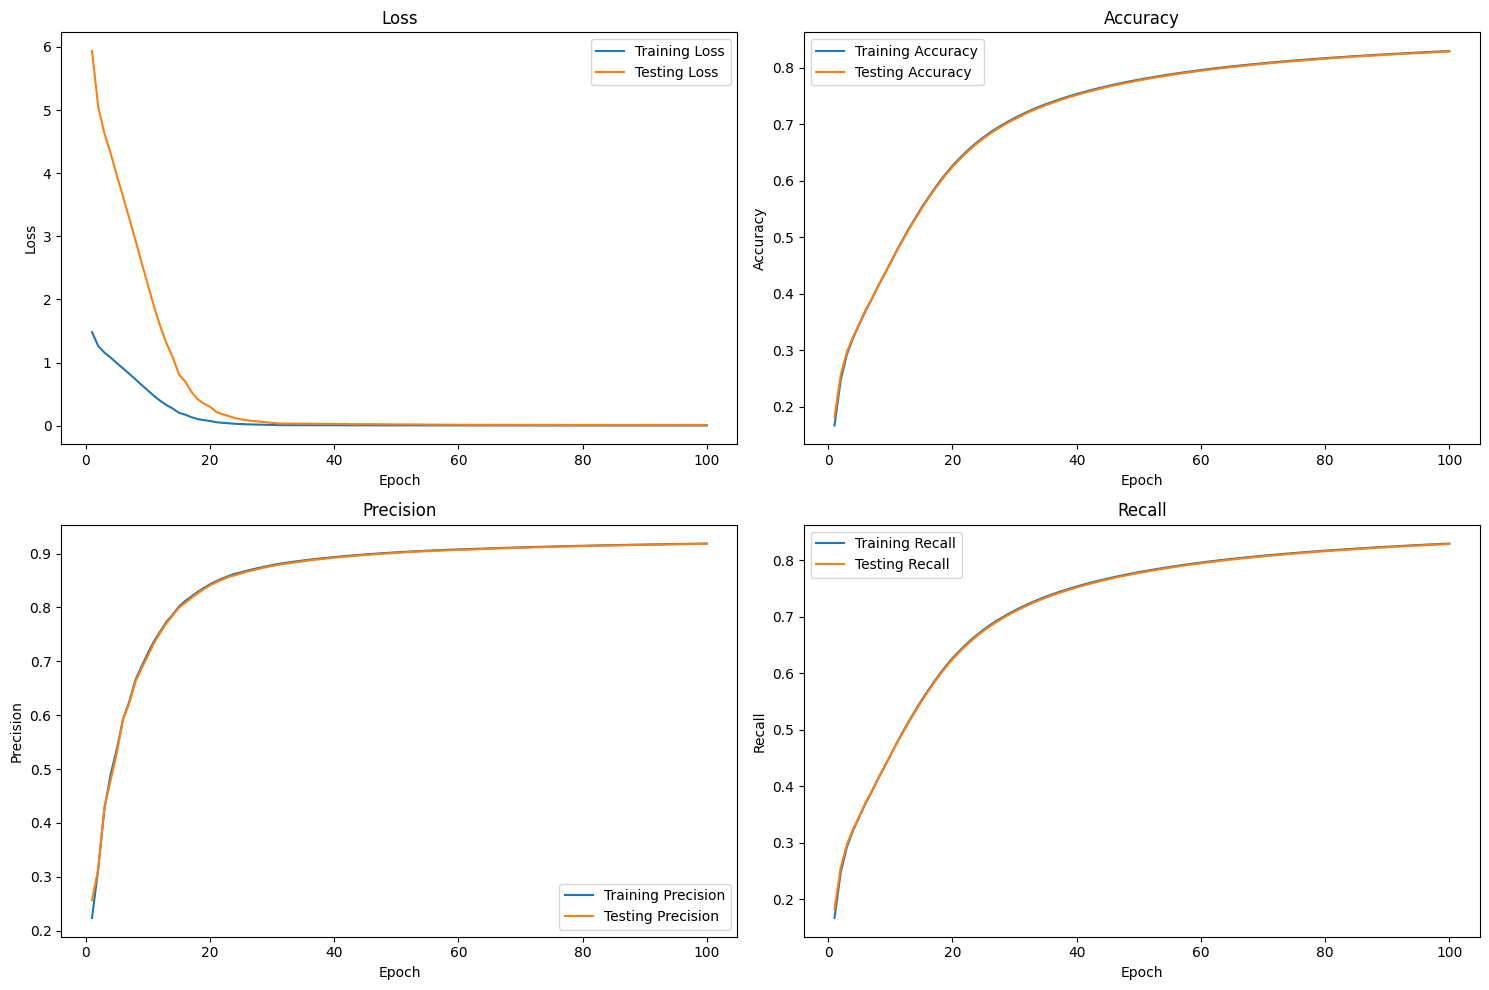

In [72]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [73]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction cambio de learning rate variable (data augmentation) y loss ponderada 200 epochs

In [74]:
torch.cuda.empty_cache()
num_epochs = 200
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

# Definir la tasa de aprendizaje inicial y el decaimiento
initial_learning_rate = 0.00001
lr_decay_step_size = 30
lr_decay_gamma = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
optimizer.weight = class_weights_tensor.to(device)

# Programar el decaimiento de la tasa de aprendizaje
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)

In [75]:
train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate_variable_lr(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=False, patience=5)

Training Epoch 1/200: 100%|████████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 1.4814, Training Accuracy: 0.1732, Training Precision: 0.2787, Training Recall: 0.1732


Testing Epoch 1/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 5.9257, Testing Accuracy: 0.1875, Testing Precision: 0.3018, Testing Recall: 0.1875


Training Epoch 2/200: 100%|████████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 1.2685, Training Accuracy: 0.2455, Training Precision: 0.3207, Training Recall: 0.2455


Testing Epoch 2/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 5.0741, Testing Accuracy: 0.2531, Testing Precision: 0.3159, Testing Recall: 0.2531


Training Epoch 3/200: 100%|████████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 1.1641, Training Accuracy: 0.2891, Training Precision: 0.4053, Training Recall: 0.2891


Testing Epoch 3/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 4.6563, Testing Accuracy: 0.2914, Testing Precision: 0.4070, Testing Recall: 0.2914


Training Epoch 4/200: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.0806, Training Accuracy: 0.3173, Training Precision: 0.4707, Training Recall: 0.3173


Testing Epoch 4/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 4.3224, Testing Accuracy: 0.3197, Testing Precision: 0.4686, Testing Recall: 0.3197


Training Epoch 5/200: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.9932, Training Accuracy: 0.3420, Training Precision: 0.5562, Training Recall: 0.3420


Testing Epoch 5/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 3.9727, Testing Accuracy: 0.3433, Testing Precision: 0.5588, Testing Recall: 0.3433


Training Epoch 6/200: 100%|████████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.9118, Training Accuracy: 0.3644, Training Precision: 0.6143, Training Recall: 0.3644


Testing Epoch 6/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 3.6472, Testing Accuracy: 0.3652, Testing Precision: 0.6145, Testing Recall: 0.3652


Training Epoch 7/200: 100%|████████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.8178, Training Accuracy: 0.3865, Training Precision: 0.6628, Training Recall: 0.3865


Testing Epoch 7/200: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.2713, Testing Accuracy: 0.3877, Testing Precision: 0.6611, Testing Recall: 0.3877


Training Epoch 8/200: 100%|████████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7387, Training Accuracy: 0.4090, Training Precision: 0.6892, Training Recall: 0.4090


Testing Epoch 8/200: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 2.9546, Testing Accuracy: 0.4089, Testing Precision: 0.6894, Testing Recall: 0.4089


Training Epoch 9/200: 100%|████████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.6400, Training Accuracy: 0.4297, Training Precision: 0.7111, Training Recall: 0.4297


Testing Epoch 9/200: 100%|███████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 2.5600, Testing Accuracy: 0.4293, Testing Precision: 0.7059, Testing Recall: 0.4293


Training Epoch 10/200: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.5470, Training Accuracy: 0.4505, Training Precision: 0.7257, Training Recall: 0.4505


Testing Epoch 10/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 2.1880, Testing Accuracy: 0.4504, Testing Precision: 0.7220, Testing Recall: 0.4504


Training Epoch 11/200: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.4655, Training Accuracy: 0.4720, Training Precision: 0.7419, Training Recall: 0.4720


Testing Epoch 11/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 1.8622, Testing Accuracy: 0.4710, Testing Precision: 0.7391, Testing Recall: 0.4710


Training Epoch 12/200: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.3880, Training Accuracy: 0.4926, Training Precision: 0.7623, Training Recall: 0.4926


Testing Epoch 12/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 1.5518, Testing Accuracy: 0.4920, Testing Precision: 0.7595, Testing Recall: 0.4920


Training Epoch 13/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.3254, Training Accuracy: 0.5131, Training Precision: 0.7789, Training Recall: 0.5131


Testing Epoch 13/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 1.3017, Testing Accuracy: 0.5114, Testing Precision: 0.7758, Testing Recall: 0.5114


Training Epoch 14/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.2601, Training Accuracy: 0.5318, Training Precision: 0.7924, Training Recall: 0.5318


Testing Epoch 14/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 1.0403, Testing Accuracy: 0.5304, Testing Precision: 0.7892, Testing Recall: 0.5304


Training Epoch 15/200: 100%|███████████████| 160/160 [00:40<00:00,  3.90batch/s]


Training Loss: 0.2095, Training Accuracy: 0.5501, Training Precision: 0.8040, Training Recall: 0.5501


Testing Epoch 15/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.8380, Testing Accuracy: 0.5486, Testing Precision: 0.8009, Testing Recall: 0.5486


Training Epoch 16/200: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.1663, Training Accuracy: 0.5674, Training Precision: 0.8138, Training Recall: 0.5674


Testing Epoch 16/200: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.6650, Testing Accuracy: 0.5657, Testing Precision: 0.8112, Testing Recall: 0.5657


Training Epoch 17/200: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.1345, Training Accuracy: 0.5839, Training Precision: 0.8230, Training Recall: 0.5839


Testing Epoch 17/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.5380, Testing Accuracy: 0.5821, Testing Precision: 0.8201, Testing Recall: 0.5821


Training Epoch 18/200: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.1059, Training Accuracy: 0.5991, Training Precision: 0.8305, Training Recall: 0.5991


Testing Epoch 18/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.4236, Testing Accuracy: 0.5973, Testing Precision: 0.8274, Testing Recall: 0.5973


Training Epoch 19/200: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0795, Training Accuracy: 0.6135, Training Precision: 0.8372, Training Recall: 0.6135


Testing Epoch 19/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.3178, Testing Accuracy: 0.6115, Testing Precision: 0.8352, Testing Recall: 0.6115


Training Epoch 20/200: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0675, Training Accuracy: 0.6266, Training Precision: 0.8436, Training Recall: 0.6266


Testing Epoch 20/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.2701, Testing Accuracy: 0.6245, Testing Precision: 0.8410, Testing Recall: 0.6245


Training Epoch 21/200: 100%|███████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0511, Training Accuracy: 0.6386, Training Precision: 0.8489, Training Recall: 0.6386


Testing Epoch 21/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.2042, Testing Accuracy: 0.6364, Testing Precision: 0.8469, Testing Recall: 0.6364


Training Epoch 22/200: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0450, Training Accuracy: 0.6495, Training Precision: 0.8541, Training Recall: 0.6495


Testing Epoch 22/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.1801, Testing Accuracy: 0.6475, Testing Precision: 0.8516, Testing Recall: 0.6475


Training Epoch 23/200: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0355, Training Accuracy: 0.6596, Training Precision: 0.8581, Training Recall: 0.6596


Testing Epoch 23/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.1419, Testing Accuracy: 0.6576, Testing Precision: 0.8557, Testing Recall: 0.6576


Training Epoch 24/200: 100%|███████████████| 160/160 [00:42<00:00,  3.72batch/s]


Training Loss: 0.0296, Training Accuracy: 0.6689, Training Precision: 0.8616, Training Recall: 0.6689


Testing Epoch 24/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.1182, Testing Accuracy: 0.6668, Testing Precision: 0.8595, Testing Recall: 0.6668


Training Epoch 25/200: 100%|███████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 0.0254, Training Accuracy: 0.6774, Training Precision: 0.8650, Training Recall: 0.6774


Testing Epoch 25/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.1015, Testing Accuracy: 0.6754, Testing Precision: 0.8627, Testing Recall: 0.6754


Training Epoch 26/200: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0213, Training Accuracy: 0.6853, Training Precision: 0.8679, Training Recall: 0.6853


Testing Epoch 26/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0854, Testing Accuracy: 0.6833, Testing Precision: 0.8659, Testing Recall: 0.6833


Training Epoch 27/200: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0173, Training Accuracy: 0.6927, Training Precision: 0.8707, Training Recall: 0.6927


Testing Epoch 27/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0694, Testing Accuracy: 0.6906, Testing Precision: 0.8691, Testing Recall: 0.6906


Training Epoch 28/200: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0146, Training Accuracy: 0.6994, Training Precision: 0.8735, Training Recall: 0.6994


Testing Epoch 28/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0585, Testing Accuracy: 0.6974, Testing Precision: 0.8719, Testing Recall: 0.6974


Training Epoch 29/200: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0126, Training Accuracy: 0.7057, Training Precision: 0.8761, Training Recall: 0.7057


Testing Epoch 29/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0503, Testing Accuracy: 0.7038, Testing Precision: 0.8743, Testing Recall: 0.7038


Training Epoch 30/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0104, Training Accuracy: 0.7116, Training Precision: 0.8782, Training Recall: 0.7116


Testing Epoch 30/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0415, Testing Accuracy: 0.7096, Testing Precision: 0.8768, Testing Recall: 0.7096


Training Epoch 31/200: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0090, Training Accuracy: 0.7171, Training Precision: 0.8806, Training Recall: 0.7171


Testing Epoch 31/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0359, Testing Accuracy: 0.7151, Testing Precision: 0.8791, Testing Recall: 0.7151


Training Epoch 32/200: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0081, Training Accuracy: 0.7222, Training Precision: 0.8826, Training Recall: 0.7222


Testing Epoch 32/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0325, Testing Accuracy: 0.7202, Testing Precision: 0.8811, Testing Recall: 0.7202


Training Epoch 33/200: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0079, Training Accuracy: 0.7270, Training Precision: 0.8844, Training Recall: 0.7270


Testing Epoch 33/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0317, Testing Accuracy: 0.7251, Testing Precision: 0.8830, Testing Recall: 0.7251


Training Epoch 34/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0076, Training Accuracy: 0.7316, Training Precision: 0.8861, Training Recall: 0.7316


Testing Epoch 34/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0303, Testing Accuracy: 0.7297, Testing Precision: 0.8847, Testing Recall: 0.7297


Training Epoch 35/200: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.0074, Training Accuracy: 0.7359, Training Precision: 0.8877, Training Recall: 0.7359


Testing Epoch 35/200: 100%|██████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 0.0297, Testing Accuracy: 0.7341, Testing Precision: 0.8862, Testing Recall: 0.7341


Training Epoch 36/200: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0075, Training Accuracy: 0.7400, Training Precision: 0.8891, Training Recall: 0.7400


Testing Epoch 36/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0299, Testing Accuracy: 0.7382, Testing Precision: 0.8877, Testing Recall: 0.7382


Training Epoch 37/200: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0071, Training Accuracy: 0.7438, Training Precision: 0.8905, Training Recall: 0.7438


Testing Epoch 37/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0283, Testing Accuracy: 0.7421, Testing Precision: 0.8892, Testing Recall: 0.7421


Training Epoch 38/200: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0071, Training Accuracy: 0.7475, Training Precision: 0.8919, Training Recall: 0.7475


Testing Epoch 38/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0282, Testing Accuracy: 0.7457, Testing Precision: 0.8906, Testing Recall: 0.7457


Training Epoch 39/200: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0067, Training Accuracy: 0.7509, Training Precision: 0.8931, Training Recall: 0.7509


Testing Epoch 39/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0269, Testing Accuracy: 0.7492, Testing Precision: 0.8918, Testing Recall: 0.7492


Training Epoch 40/200: 100%|███████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0065, Training Accuracy: 0.7542, Training Precision: 0.8942, Training Recall: 0.7542


Testing Epoch 40/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0258, Testing Accuracy: 0.7525, Testing Precision: 0.8930, Testing Recall: 0.7525


Training Epoch 41/200: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0065, Training Accuracy: 0.7573, Training Precision: 0.8953, Training Recall: 0.7573


Testing Epoch 41/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0262, Testing Accuracy: 0.7557, Testing Precision: 0.8941, Testing Recall: 0.7557


Training Epoch 42/200: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0061, Training Accuracy: 0.7603, Training Precision: 0.8964, Training Recall: 0.7603


Testing Epoch 42/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0243, Testing Accuracy: 0.7586, Testing Precision: 0.8952, Testing Recall: 0.7586


Training Epoch 43/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0061, Training Accuracy: 0.7631, Training Precision: 0.8974, Training Recall: 0.7631


Testing Epoch 43/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0242, Testing Accuracy: 0.7615, Testing Precision: 0.8963, Testing Recall: 0.7615


Training Epoch 44/200: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0059, Training Accuracy: 0.7658, Training Precision: 0.8984, Training Recall: 0.7658


Testing Epoch 44/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.0236, Testing Accuracy: 0.7642, Testing Precision: 0.8973, Testing Recall: 0.7642


Training Epoch 45/200: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0061, Training Accuracy: 0.7683, Training Precision: 0.8993, Training Recall: 0.7683


Testing Epoch 45/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0242, Testing Accuracy: 0.7668, Testing Precision: 0.8982, Testing Recall: 0.7668


Training Epoch 46/200: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0059, Training Accuracy: 0.7708, Training Precision: 0.9002, Training Recall: 0.7708


Testing Epoch 46/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0234, Testing Accuracy: 0.7692, Testing Precision: 0.8991, Testing Recall: 0.7692


Training Epoch 47/200: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0057, Training Accuracy: 0.7731, Training Precision: 0.9010, Training Recall: 0.7731


Testing Epoch 47/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0228, Testing Accuracy: 0.7716, Testing Precision: 0.8999, Testing Recall: 0.7716


Training Epoch 48/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0054, Training Accuracy: 0.7754, Training Precision: 0.9018, Training Recall: 0.7754


Testing Epoch 48/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0215, Testing Accuracy: 0.7739, Testing Precision: 0.9007, Testing Recall: 0.7739


Training Epoch 49/200: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0052, Training Accuracy: 0.7776, Training Precision: 0.9025, Training Recall: 0.7776


Testing Epoch 49/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0207, Testing Accuracy: 0.7761, Testing Precision: 0.9015, Testing Recall: 0.7761


Training Epoch 50/200: 100%|███████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0050, Training Accuracy: 0.7796, Training Precision: 0.9033, Training Recall: 0.7796


Testing Epoch 50/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0201, Testing Accuracy: 0.7781, Testing Precision: 0.9023, Testing Recall: 0.7781


Training Epoch 51/200: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0047, Training Accuracy: 0.7816, Training Precision: 0.9040, Training Recall: 0.7816


Testing Epoch 51/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0190, Testing Accuracy: 0.7802, Testing Precision: 0.9030, Testing Recall: 0.7802


Training Epoch 52/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0047, Training Accuracy: 0.7835, Training Precision: 0.9046, Training Recall: 0.7835


Testing Epoch 52/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0190, Testing Accuracy: 0.7821, Testing Precision: 0.9036, Testing Recall: 0.7821


Training Epoch 53/200: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0046, Training Accuracy: 0.7853, Training Precision: 0.9052, Training Recall: 0.7853


Testing Epoch 53/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0184, Testing Accuracy: 0.7839, Testing Precision: 0.9043, Testing Recall: 0.7839


Training Epoch 54/200: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0044, Training Accuracy: 0.7871, Training Precision: 0.9059, Training Recall: 0.7871


Testing Epoch 54/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0177, Testing Accuracy: 0.7857, Testing Precision: 0.9049, Testing Recall: 0.7857


Training Epoch 55/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0040, Training Accuracy: 0.7888, Training Precision: 0.9064, Training Recall: 0.7888


Testing Epoch 55/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0162, Testing Accuracy: 0.7874, Testing Precision: 0.9055, Testing Recall: 0.7874


Training Epoch 56/200: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.0039, Training Accuracy: 0.7904, Training Precision: 0.9070, Training Recall: 0.7904


Testing Epoch 56/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0158, Testing Accuracy: 0.7891, Testing Precision: 0.9061, Testing Recall: 0.7891


Training Epoch 57/200: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0039, Training Accuracy: 0.7920, Training Precision: 0.9075, Training Recall: 0.7920


Testing Epoch 57/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0156, Testing Accuracy: 0.7907, Testing Precision: 0.9066, Testing Recall: 0.7907


Training Epoch 58/200: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0037, Training Accuracy: 0.7936, Training Precision: 0.9080, Training Recall: 0.7936


Testing Epoch 58/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0146, Testing Accuracy: 0.7922, Testing Precision: 0.9072, Testing Recall: 0.7922


Training Epoch 59/200: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0036, Training Accuracy: 0.7950, Training Precision: 0.9086, Training Recall: 0.7950


Testing Epoch 59/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.72batch/s]


Testing Loss: 0.0142, Testing Accuracy: 0.7937, Testing Precision: 0.9077, Testing Recall: 0.7937


Training Epoch 60/200: 100%|███████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0037, Training Accuracy: 0.7965, Training Precision: 0.9091, Training Recall: 0.7965


Testing Epoch 60/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0148, Testing Accuracy: 0.7952, Testing Precision: 0.9082, Testing Recall: 0.7952


Training Epoch 61/200: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.0033, Training Accuracy: 0.7979, Training Precision: 0.9095, Training Recall: 0.7979


Testing Epoch 61/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0130, Testing Accuracy: 0.7966, Testing Precision: 0.9087, Testing Recall: 0.7966


Training Epoch 62/200: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.0031, Training Accuracy: 0.7992, Training Precision: 0.9100, Training Recall: 0.7992


Testing Epoch 62/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0126, Testing Accuracy: 0.7980, Testing Precision: 0.9092, Testing Recall: 0.7980


Training Epoch 63/200: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0034, Training Accuracy: 0.8005, Training Precision: 0.9104, Training Recall: 0.8005


Testing Epoch 63/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0136, Testing Accuracy: 0.7993, Testing Precision: 0.9096, Testing Recall: 0.7993


Training Epoch 64/200: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8018, Training Precision: 0.9109, Training Recall: 0.8018


Testing Epoch 64/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0126, Testing Accuracy: 0.8006, Testing Precision: 0.9101, Testing Recall: 0.8006


Training Epoch 65/200: 100%|███████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8030, Training Precision: 0.9113, Training Recall: 0.8030


Testing Epoch 65/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.8018, Testing Precision: 0.9105, Testing Recall: 0.8018


Training Epoch 66/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8042, Training Precision: 0.9117, Training Recall: 0.8042


Testing Epoch 66/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0122, Testing Accuracy: 0.8030, Testing Precision: 0.9109, Testing Recall: 0.8030


Training Epoch 67/200: 100%|███████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8053, Training Precision: 0.9121, Training Recall: 0.8053


Testing Epoch 67/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.8042, Testing Precision: 0.9113, Testing Recall: 0.8042


Training Epoch 68/200: 100%|███████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8064, Training Precision: 0.9124, Training Recall: 0.8064


Testing Epoch 68/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0123, Testing Accuracy: 0.8053, Testing Precision: 0.9117, Testing Recall: 0.8053


Training Epoch 69/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8075, Training Precision: 0.9128, Training Recall: 0.8075


Testing Epoch 69/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0121, Testing Accuracy: 0.8064, Testing Precision: 0.9120, Testing Recall: 0.8064


Training Epoch 70/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8086, Training Precision: 0.9131, Training Recall: 0.8086


Testing Epoch 70/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.8075, Testing Precision: 0.9124, Testing Recall: 0.8075


Training Epoch 71/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8096, Training Precision: 0.9135, Training Recall: 0.8096


Testing Epoch 71/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0125, Testing Accuracy: 0.8085, Testing Precision: 0.9127, Testing Recall: 0.8085


Training Epoch 72/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8106, Training Precision: 0.9138, Training Recall: 0.8106


Testing Epoch 72/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0122, Testing Accuracy: 0.8095, Testing Precision: 0.9131, Testing Recall: 0.8095


Training Epoch 73/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8116, Training Precision: 0.9141, Training Recall: 0.8116


Testing Epoch 73/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0123, Testing Accuracy: 0.8105, Testing Precision: 0.9134, Testing Recall: 0.8105


Training Epoch 74/200: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8125, Training Precision: 0.9144, Training Recall: 0.8125


Testing Epoch 74/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8114, Testing Precision: 0.9137, Testing Recall: 0.8114


Training Epoch 75/200: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8134, Training Precision: 0.9147, Training Recall: 0.8134


Testing Epoch 75/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0120, Testing Accuracy: 0.8124, Testing Precision: 0.9140, Testing Recall: 0.8124


Training Epoch 76/200: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8143, Training Precision: 0.9150, Training Recall: 0.8143


Testing Epoch 76/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.0118, Testing Accuracy: 0.8133, Testing Precision: 0.9143, Testing Recall: 0.8133


Training Epoch 77/200: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8152, Training Precision: 0.9153, Training Recall: 0.8152


Testing Epoch 77/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0123, Testing Accuracy: 0.8141, Testing Precision: 0.9146, Testing Recall: 0.8141


Training Epoch 78/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8160, Training Precision: 0.9156, Training Recall: 0.8160


Testing Epoch 78/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8150, Testing Precision: 0.9149, Testing Recall: 0.8150


Training Epoch 79/200: 100%|███████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0030, Training Accuracy: 0.8169, Training Precision: 0.9158, Training Recall: 0.8169


Testing Epoch 79/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 0.0118, Testing Accuracy: 0.8158, Testing Precision: 0.9152, Testing Recall: 0.8158


Training Epoch 80/200: 100%|███████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8177, Training Precision: 0.9161, Training Recall: 0.8177


Testing Epoch 80/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0114, Testing Accuracy: 0.8167, Testing Precision: 0.9154, Testing Recall: 0.8167


Training Epoch 81/200: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8184, Training Precision: 0.9163, Training Recall: 0.8184


Testing Epoch 81/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0118, Testing Accuracy: 0.8174, Testing Precision: 0.9157, Testing Recall: 0.8174


Training Epoch 82/200: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8192, Training Precision: 0.9166, Training Recall: 0.8192


Testing Epoch 82/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8182, Testing Precision: 0.9159, Testing Recall: 0.8182


Training Epoch 83/200: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8200, Training Precision: 0.9168, Training Recall: 0.8200


Testing Epoch 83/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8190, Testing Precision: 0.9162, Testing Recall: 0.8190


Training Epoch 84/200: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8207, Training Precision: 0.9170, Training Recall: 0.8207


Testing Epoch 84/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0112, Testing Accuracy: 0.8197, Testing Precision: 0.9164, Testing Recall: 0.8197


Training Epoch 85/200: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8214, Training Precision: 0.9173, Training Recall: 0.8214


Testing Epoch 85/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8204, Testing Precision: 0.9167, Testing Recall: 0.8204


Training Epoch 86/200: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8221, Training Precision: 0.9175, Training Recall: 0.8221


Testing Epoch 86/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8211, Testing Precision: 0.9169, Testing Recall: 0.8211


Training Epoch 87/200: 100%|███████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8227, Training Precision: 0.9177, Training Recall: 0.8227


Testing Epoch 87/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8218, Testing Precision: 0.9171, Testing Recall: 0.8218


Training Epoch 88/200: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8234, Training Precision: 0.9179, Training Recall: 0.8234


Testing Epoch 88/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8225, Testing Precision: 0.9174, Testing Recall: 0.8225


Training Epoch 89/200: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8240, Training Precision: 0.9182, Training Recall: 0.8240


Testing Epoch 89/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8231, Testing Precision: 0.9176, Testing Recall: 0.8231


Training Epoch 90/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8247, Training Precision: 0.9184, Training Recall: 0.8247


Testing Epoch 90/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8238, Testing Precision: 0.9178, Testing Recall: 0.8238


Training Epoch 91/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8253, Training Precision: 0.9186, Training Recall: 0.8253


Testing Epoch 91/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8244, Testing Precision: 0.9180, Testing Recall: 0.8244


Training Epoch 92/200: 100%|███████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8259, Training Precision: 0.9188, Training Recall: 0.8259


Testing Epoch 92/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8250, Testing Precision: 0.9182, Testing Recall: 0.8250


Training Epoch 93/200: 100%|███████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8265, Training Precision: 0.9190, Training Recall: 0.8265


Testing Epoch 93/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8256, Testing Precision: 0.9184, Testing Recall: 0.8256


Training Epoch 94/200: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8271, Training Precision: 0.9192, Training Recall: 0.8271


Testing Epoch 94/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8262, Testing Precision: 0.9187, Testing Recall: 0.8262


Training Epoch 95/200: 100%|███████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8276, Training Precision: 0.9194, Training Recall: 0.8276


Testing Epoch 95/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8268, Testing Precision: 0.9189, Testing Recall: 0.8268


Training Epoch 96/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8282, Training Precision: 0.9196, Training Recall: 0.8282


Testing Epoch 96/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8273, Testing Precision: 0.9190, Testing Recall: 0.8273


Training Epoch 97/200: 100%|███████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8287, Training Precision: 0.9198, Training Recall: 0.8287


Testing Epoch 97/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8279, Testing Precision: 0.9192, Testing Recall: 0.8279


Training Epoch 98/200: 100%|███████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8293, Training Precision: 0.9199, Training Recall: 0.8293


Testing Epoch 98/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.77batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8284, Testing Precision: 0.9194, Testing Recall: 0.8284


Training Epoch 99/200: 100%|███████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8298, Training Precision: 0.9201, Training Recall: 0.8298


Testing Epoch 99/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8289, Testing Precision: 0.9196, Testing Recall: 0.8289


Training Epoch 100/200: 100%|██████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8303, Training Precision: 0.9203, Training Recall: 0.8303


Testing Epoch 100/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0116, Testing Accuracy: 0.8295, Testing Precision: 0.9198, Testing Recall: 0.8295


Training Epoch 101/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8308, Training Precision: 0.9205, Training Recall: 0.8308


Testing Epoch 101/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8300, Testing Precision: 0.9199, Testing Recall: 0.8300


Training Epoch 102/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8313, Training Precision: 0.9206, Training Recall: 0.8313


Testing Epoch 102/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8305, Testing Precision: 0.9201, Testing Recall: 0.8305


Training Epoch 103/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8318, Training Precision: 0.9207, Training Recall: 0.8318


Testing Epoch 103/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8309, Testing Precision: 0.9202, Testing Recall: 0.8309


Training Epoch 104/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8322, Training Precision: 0.9209, Training Recall: 0.8322


Testing Epoch 104/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8314, Testing Precision: 0.9204, Testing Recall: 0.8314


Training Epoch 105/200: 100%|██████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8327, Training Precision: 0.9210, Training Recall: 0.8327


Testing Epoch 105/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8319, Testing Precision: 0.9206, Testing Recall: 0.8319


Training Epoch 106/200: 100%|██████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8331, Training Precision: 0.9212, Training Recall: 0.8331


Testing Epoch 106/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8324, Testing Precision: 0.9207, Testing Recall: 0.8324


Training Epoch 107/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8336, Training Precision: 0.9213, Training Recall: 0.8336


Testing Epoch 107/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8328, Testing Precision: 0.9208, Testing Recall: 0.8328


Training Epoch 108/200: 100%|██████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8340, Training Precision: 0.9215, Training Recall: 0.8340


Testing Epoch 108/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8332, Testing Precision: 0.9210, Testing Recall: 0.8332


Training Epoch 109/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8345, Training Precision: 0.9216, Training Recall: 0.8345


Testing Epoch 109/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8337, Testing Precision: 0.9211, Testing Recall: 0.8337


Training Epoch 110/200: 100%|██████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8349, Training Precision: 0.9217, Training Recall: 0.8349


Testing Epoch 110/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8341, Testing Precision: 0.9212, Testing Recall: 0.8341


Training Epoch 111/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8353, Training Precision: 0.9219, Training Recall: 0.8353


Testing Epoch 111/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8345, Testing Precision: 0.9214, Testing Recall: 0.8345


Training Epoch 112/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8357, Training Precision: 0.9220, Training Recall: 0.8357


Testing Epoch 112/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8349, Testing Precision: 0.9215, Testing Recall: 0.8349


Training Epoch 113/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8361, Training Precision: 0.9221, Training Recall: 0.8361


Testing Epoch 113/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8353, Testing Precision: 0.9216, Testing Recall: 0.8353


Training Epoch 114/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8365, Training Precision: 0.9222, Training Recall: 0.8365


Testing Epoch 114/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8357, Testing Precision: 0.9218, Testing Recall: 0.8357


Training Epoch 115/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8369, Training Precision: 0.9223, Training Recall: 0.8369


Testing Epoch 115/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8361, Testing Precision: 0.9219, Testing Recall: 0.8361


Training Epoch 116/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8373, Training Precision: 0.9225, Training Recall: 0.8373


Testing Epoch 116/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8365, Testing Precision: 0.9220, Testing Recall: 0.8365


Training Epoch 117/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8376, Training Precision: 0.9226, Training Recall: 0.8376


Testing Epoch 117/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8369, Testing Precision: 0.9221, Testing Recall: 0.8369


Training Epoch 118/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8380, Training Precision: 0.9227, Training Recall: 0.8380


Testing Epoch 118/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8373, Testing Precision: 0.9222, Testing Recall: 0.8373


Training Epoch 119/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8383, Training Precision: 0.9228, Training Recall: 0.8383


Testing Epoch 119/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8376, Testing Precision: 0.9223, Testing Recall: 0.8376


Training Epoch 120/200: 100%|██████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8387, Training Precision: 0.9229, Training Recall: 0.8387


Testing Epoch 120/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0101, Testing Accuracy: 0.8380, Testing Precision: 0.9225, Testing Recall: 0.8380


Training Epoch 121/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8390, Training Precision: 0.9230, Training Recall: 0.8390


Testing Epoch 121/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8383, Testing Precision: 0.9226, Testing Recall: 0.8383


Training Epoch 122/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8394, Training Precision: 0.9231, Training Recall: 0.8394


Testing Epoch 122/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8387, Testing Precision: 0.9227, Testing Recall: 0.8387


Training Epoch 123/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8397, Training Precision: 0.9232, Training Recall: 0.8397


Testing Epoch 123/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8390, Testing Precision: 0.9228, Testing Recall: 0.8390


Training Epoch 124/200: 100%|██████████████| 160/160 [00:43<00:00,  3.69batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8401, Training Precision: 0.9233, Training Recall: 0.8401


Testing Epoch 124/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8394, Testing Precision: 0.9229, Testing Recall: 0.8394


Training Epoch 125/200: 100%|██████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8404, Training Precision: 0.9234, Training Recall: 0.8404


Testing Epoch 125/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8397, Testing Precision: 0.9230, Testing Recall: 0.8397


Training Epoch 126/200: 100%|██████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8407, Training Precision: 0.9235, Training Recall: 0.8407


Testing Epoch 126/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8400, Testing Precision: 0.9231, Testing Recall: 0.8400


Training Epoch 127/200: 100%|██████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8410, Training Precision: 0.9236, Training Recall: 0.8410


Testing Epoch 127/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8403, Testing Precision: 0.9232, Testing Recall: 0.8403


Training Epoch 128/200: 100%|██████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8413, Training Precision: 0.9237, Training Recall: 0.8413


Testing Epoch 128/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8407, Testing Precision: 0.9233, Testing Recall: 0.8407


Training Epoch 129/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8416, Training Precision: 0.9238, Training Recall: 0.8416


Testing Epoch 129/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8410, Testing Precision: 0.9234, Testing Recall: 0.8410


Training Epoch 130/200: 100%|██████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8419, Training Precision: 0.9239, Training Recall: 0.8419


Testing Epoch 130/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8413, Testing Precision: 0.9235, Testing Recall: 0.8413


Training Epoch 131/200: 100%|██████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8422, Training Precision: 0.9240, Training Recall: 0.8422


Testing Epoch 131/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0101, Testing Accuracy: 0.8416, Testing Precision: 0.9236, Testing Recall: 0.8416


Training Epoch 132/200: 100%|██████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8425, Training Precision: 0.9241, Training Recall: 0.8425


Testing Epoch 132/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8419, Testing Precision: 0.9237, Testing Recall: 0.8419


Training Epoch 133/200: 100%|██████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8428, Training Precision: 0.9242, Training Recall: 0.8428


Testing Epoch 133/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8422, Testing Precision: 0.9238, Testing Recall: 0.8422


Training Epoch 134/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8431, Training Precision: 0.9242, Training Recall: 0.8431


Testing Epoch 134/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8424, Testing Precision: 0.9239, Testing Recall: 0.8424


Training Epoch 135/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8434, Training Precision: 0.9243, Training Recall: 0.8434


Testing Epoch 135/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0112, Testing Accuracy: 0.8427, Testing Precision: 0.9239, Testing Recall: 0.8427


Training Epoch 136/200: 100%|██████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8436, Training Precision: 0.9244, Training Recall: 0.8436


Testing Epoch 136/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8430, Testing Precision: 0.9240, Testing Recall: 0.8430


Training Epoch 137/200: 100%|██████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8439, Training Precision: 0.9245, Training Recall: 0.8439


Testing Epoch 137/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8433, Testing Precision: 0.9241, Testing Recall: 0.8433


Training Epoch 138/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8442, Training Precision: 0.9246, Training Recall: 0.8442


Testing Epoch 138/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8436, Testing Precision: 0.9242, Testing Recall: 0.8436


Training Epoch 139/200: 100%|██████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8444, Training Precision: 0.9247, Training Recall: 0.8444


Testing Epoch 139/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 0.0101, Testing Accuracy: 0.8438, Testing Precision: 0.9243, Testing Recall: 0.8438


Training Epoch 140/200: 100%|██████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8447, Training Precision: 0.9247, Training Recall: 0.8447


Testing Epoch 140/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8441, Testing Precision: 0.9244, Testing Recall: 0.8441


Training Epoch 141/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8450, Training Precision: 0.9248, Training Recall: 0.8450


Testing Epoch 141/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8443, Testing Precision: 0.9244, Testing Recall: 0.8443


Training Epoch 142/200: 100%|██████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8452, Training Precision: 0.9249, Training Recall: 0.8452


Testing Epoch 142/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8446, Testing Precision: 0.9245, Testing Recall: 0.8446


Training Epoch 143/200: 100%|██████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8455, Training Precision: 0.9250, Training Recall: 0.8455


Testing Epoch 143/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8448, Testing Precision: 0.9246, Testing Recall: 0.8448


Training Epoch 144/200: 100%|██████████████| 160/160 [00:48<00:00,  3.32batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8457, Training Precision: 0.9250, Training Recall: 0.8457


Testing Epoch 144/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8451, Testing Precision: 0.9247, Testing Recall: 0.8451


Training Epoch 145/200: 100%|██████████████| 160/160 [00:46<00:00,  3.44batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8459, Training Precision: 0.9251, Training Recall: 0.8459


Testing Epoch 145/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8453, Testing Precision: 0.9248, Testing Recall: 0.8453


Training Epoch 146/200: 100%|██████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8462, Training Precision: 0.9252, Training Recall: 0.8462


Testing Epoch 146/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8456, Testing Precision: 0.9248, Testing Recall: 0.8456


Training Epoch 147/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8464, Training Precision: 0.9253, Training Recall: 0.8464


Testing Epoch 147/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8458, Testing Precision: 0.9249, Testing Recall: 0.8458


Training Epoch 148/200: 100%|██████████████| 160/160 [00:44<00:00,  3.57batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8466, Training Precision: 0.9253, Training Recall: 0.8466


Testing Epoch 148/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0112, Testing Accuracy: 0.8461, Testing Precision: 0.9250, Testing Recall: 0.8461


Training Epoch 149/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8469, Training Precision: 0.9254, Training Recall: 0.8469


Testing Epoch 149/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8463, Testing Precision: 0.9251, Testing Recall: 0.8463


Training Epoch 150/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8471, Training Precision: 0.9255, Training Recall: 0.8471


Testing Epoch 150/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8465, Testing Precision: 0.9251, Testing Recall: 0.8465


Training Epoch 151/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8473, Training Precision: 0.9255, Training Recall: 0.8473


Testing Epoch 151/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8467, Testing Precision: 0.9252, Testing Recall: 0.8467


Training Epoch 152/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8475, Training Precision: 0.9256, Training Recall: 0.8475


Testing Epoch 152/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0111, Testing Accuracy: 0.8470, Testing Precision: 0.9253, Testing Recall: 0.8470


Training Epoch 153/200: 100%|██████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8478, Training Precision: 0.9257, Training Recall: 0.8478


Testing Epoch 153/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8472, Testing Precision: 0.9253, Testing Recall: 0.8472


Training Epoch 154/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8480, Training Precision: 0.9257, Training Recall: 0.8480


Testing Epoch 154/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8474, Testing Precision: 0.9254, Testing Recall: 0.8474


Training Epoch 155/200: 100%|██████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8482, Training Precision: 0.9258, Training Recall: 0.8482


Testing Epoch 155/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8476, Testing Precision: 0.9255, Testing Recall: 0.8476


Training Epoch 156/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8484, Training Precision: 0.9259, Training Recall: 0.8484


Testing Epoch 156/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0100, Testing Accuracy: 0.8478, Testing Precision: 0.9255, Testing Recall: 0.8478


Training Epoch 157/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8486, Training Precision: 0.9259, Training Recall: 0.8486


Testing Epoch 157/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8480, Testing Precision: 0.9256, Testing Recall: 0.8480


Training Epoch 158/200: 100%|██████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8488, Training Precision: 0.9260, Training Recall: 0.8488


Testing Epoch 158/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8482, Testing Precision: 0.9257, Testing Recall: 0.8482


Training Epoch 159/200: 100%|██████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8490, Training Precision: 0.9261, Training Recall: 0.8490


Testing Epoch 159/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8484, Testing Precision: 0.9257, Testing Recall: 0.8484


Training Epoch 160/200: 100%|██████████████| 160/160 [00:43<00:00,  3.71batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8492, Training Precision: 0.9261, Training Recall: 0.8492


Testing Epoch 160/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8487, Testing Precision: 0.9258, Testing Recall: 0.8487


Training Epoch 161/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8494, Training Precision: 0.9262, Training Recall: 0.8494


Testing Epoch 161/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8488, Testing Precision: 0.9258, Testing Recall: 0.8488


Training Epoch 162/200: 100%|██████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8496, Training Precision: 0.9262, Training Recall: 0.8496


Testing Epoch 162/200: 100%|█████████████████| 40/40 [00:10<00:00,  4.00batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8490, Testing Precision: 0.9259, Testing Recall: 0.8490


Training Epoch 163/200: 100%|██████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8498, Training Precision: 0.9263, Training Recall: 0.8498


Testing Epoch 163/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8492, Testing Precision: 0.9260, Testing Recall: 0.8492


Training Epoch 164/200: 100%|██████████████| 160/160 [00:43<00:00,  3.68batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8500, Training Precision: 0.9263, Training Recall: 0.8500


Testing Epoch 164/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0110, Testing Accuracy: 0.8494, Testing Precision: 0.9260, Testing Recall: 0.8494


Training Epoch 165/200: 100%|██████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8502, Training Precision: 0.9264, Training Recall: 0.8502


Testing Epoch 165/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8496, Testing Precision: 0.9261, Testing Recall: 0.8496


Training Epoch 166/200: 100%|██████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8503, Training Precision: 0.9265, Training Recall: 0.8503


Testing Epoch 166/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8498, Testing Precision: 0.9261, Testing Recall: 0.8498


Training Epoch 167/200: 100%|██████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8505, Training Precision: 0.9265, Training Recall: 0.8505


Testing Epoch 167/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8500, Testing Precision: 0.9262, Testing Recall: 0.8500


Training Epoch 168/200: 100%|██████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8507, Training Precision: 0.9266, Training Recall: 0.8507


Testing Epoch 168/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8502, Testing Precision: 0.9263, Testing Recall: 0.8502


Training Epoch 169/200: 100%|██████████████| 160/160 [00:44<00:00,  3.58batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8509, Training Precision: 0.9266, Training Recall: 0.8509


Testing Epoch 169/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8504, Testing Precision: 0.9263, Testing Recall: 0.8504


Training Epoch 170/200: 100%|██████████████| 160/160 [00:45<00:00,  3.54batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8511, Training Precision: 0.9267, Training Recall: 0.8511


Testing Epoch 170/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8505, Testing Precision: 0.9264, Testing Recall: 0.8505


Training Epoch 171/200: 100%|██████████████| 160/160 [00:44<00:00,  3.56batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8512, Training Precision: 0.9267, Training Recall: 0.8512


Testing Epoch 171/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0099, Testing Accuracy: 0.8507, Testing Precision: 0.9264, Testing Recall: 0.8507


Training Epoch 172/200: 100%|██████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8514, Training Precision: 0.9268, Training Recall: 0.8514


Testing Epoch 172/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8509, Testing Precision: 0.9265, Testing Recall: 0.8509


Training Epoch 173/200: 100%|██████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8516, Training Precision: 0.9268, Training Recall: 0.8516


Testing Epoch 173/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8511, Testing Precision: 0.9265, Testing Recall: 0.8511


Training Epoch 174/200: 100%|██████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8517, Training Precision: 0.9269, Training Recall: 0.8517


Testing Epoch 174/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.75batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8512, Testing Precision: 0.9266, Testing Recall: 0.8512


Training Epoch 175/200: 100%|██████████████| 160/160 [00:44<00:00,  3.60batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8519, Training Precision: 0.9269, Training Recall: 0.8519


Testing Epoch 175/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8514, Testing Precision: 0.9266, Testing Recall: 0.8514


Training Epoch 176/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8521, Training Precision: 0.9270, Training Recall: 0.8521


Testing Epoch 176/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8516, Testing Precision: 0.9267, Testing Recall: 0.8516


Training Epoch 177/200: 100%|██████████████| 160/160 [00:45<00:00,  3.55batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8522, Training Precision: 0.9270, Training Recall: 0.8522


Testing Epoch 177/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8517, Testing Precision: 0.9267, Testing Recall: 0.8517


Training Epoch 178/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8524, Training Precision: 0.9271, Training Recall: 0.8524


Testing Epoch 178/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8519, Testing Precision: 0.9268, Testing Recall: 0.8519


Training Epoch 179/200: 100%|██████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8525, Training Precision: 0.9271, Training Recall: 0.8525


Testing Epoch 179/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 0.0099, Testing Accuracy: 0.8520, Testing Precision: 0.9268, Testing Recall: 0.8520


Training Epoch 180/200: 100%|██████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8527, Training Precision: 0.9272, Training Recall: 0.8527


Testing Epoch 180/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0100, Testing Accuracy: 0.8522, Testing Precision: 0.9269, Testing Recall: 0.8522


Training Epoch 181/200: 100%|██████████████| 160/160 [00:44<00:00,  3.59batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8529, Training Precision: 0.9272, Training Recall: 0.8529


Testing Epoch 181/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8524, Testing Precision: 0.9269, Testing Recall: 0.8524


Training Epoch 182/200: 100%|██████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8530, Training Precision: 0.9273, Training Recall: 0.8530


Testing Epoch 182/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0109, Testing Accuracy: 0.8525, Testing Precision: 0.9270, Testing Recall: 0.8525


Training Epoch 183/200: 100%|██████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8532, Training Precision: 0.9273, Training Recall: 0.8532


Testing Epoch 183/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0107, Testing Accuracy: 0.8527, Testing Precision: 0.9270, Testing Recall: 0.8527


Training Epoch 184/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8533, Training Precision: 0.9274, Training Recall: 0.8533


Testing Epoch 184/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0099, Testing Accuracy: 0.8528, Testing Precision: 0.9271, Testing Recall: 0.8528


Training Epoch 185/200: 100%|██████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8535, Training Precision: 0.9274, Training Recall: 0.8535


Testing Epoch 185/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8530, Testing Precision: 0.9271, Testing Recall: 0.8530


Training Epoch 186/200: 100%|██████████████| 160/160 [00:45<00:00,  3.54batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8536, Training Precision: 0.9275, Training Recall: 0.8536


Testing Epoch 186/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8531, Testing Precision: 0.9272, Testing Recall: 0.8531


Training Epoch 187/200: 100%|██████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8537, Training Precision: 0.9275, Training Recall: 0.8537


Testing Epoch 187/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8533, Testing Precision: 0.9272, Testing Recall: 0.8533


Training Epoch 188/200: 100%|██████████████| 160/160 [00:43<00:00,  3.65batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8539, Training Precision: 0.9275, Training Recall: 0.8539


Testing Epoch 188/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8534, Testing Precision: 0.9273, Testing Recall: 0.8534


Training Epoch 189/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8540, Training Precision: 0.9276, Training Recall: 0.8540


Testing Epoch 189/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0108, Testing Accuracy: 0.8536, Testing Precision: 0.9273, Testing Recall: 0.8536


Training Epoch 190/200: 100%|██████████████| 160/160 [00:44<00:00,  3.63batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8542, Training Precision: 0.9276, Training Recall: 0.8542


Testing Epoch 190/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8537, Testing Precision: 0.9274, Testing Recall: 0.8537


Training Epoch 191/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8543, Training Precision: 0.9277, Training Recall: 0.8543


Testing Epoch 191/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8538, Testing Precision: 0.9274, Testing Recall: 0.8538


Training Epoch 192/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8544, Training Precision: 0.9277, Training Recall: 0.8544


Testing Epoch 192/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8540, Testing Precision: 0.9274, Testing Recall: 0.8540


Training Epoch 193/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8546, Training Precision: 0.9278, Training Recall: 0.8546


Testing Epoch 193/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8541, Testing Precision: 0.9275, Testing Recall: 0.8541


Training Epoch 194/200: 100%|██████████████| 160/160 [00:43<00:00,  3.67batch/s]


Training Loss: 0.0025, Training Accuracy: 0.8547, Training Precision: 0.9278, Training Recall: 0.8547


Testing Epoch 194/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8543, Testing Precision: 0.9275, Testing Recall: 0.8543


Training Epoch 195/200: 100%|██████████████| 160/160 [00:43<00:00,  3.64batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8548, Training Precision: 0.9278, Training Recall: 0.8548


Testing Epoch 195/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8544, Testing Precision: 0.9276, Testing Recall: 0.8544


Training Epoch 196/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8550, Training Precision: 0.9279, Training Recall: 0.8550


Testing Epoch 196/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0105, Testing Accuracy: 0.8545, Testing Precision: 0.9276, Testing Recall: 0.8545


Training Epoch 197/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8551, Training Precision: 0.9279, Training Recall: 0.8551


Testing Epoch 197/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8547, Testing Precision: 0.9277, Testing Recall: 0.8547


Training Epoch 198/200: 100%|██████████████| 160/160 [00:44<00:00,  3.64batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8552, Training Precision: 0.9280, Training Recall: 0.8552


Testing Epoch 198/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0106, Testing Accuracy: 0.8548, Testing Precision: 0.9277, Testing Recall: 0.8548


Training Epoch 199/200: 100%|██████████████| 160/160 [00:44<00:00,  3.62batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8554, Training Precision: 0.9280, Training Recall: 0.8554


Testing Epoch 199/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0103, Testing Accuracy: 0.8549, Testing Precision: 0.9277, Testing Recall: 0.8549


Training Epoch 200/200: 100%|██████████████| 160/160 [00:44<00:00,  3.61batch/s]


Training Loss: 0.0027, Training Accuracy: 0.8555, Training Precision: 0.9280, Training Recall: 0.8555


Testing Epoch 200/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.11batch/s]

Testing Loss: 0.0107, Testing Accuracy: 0.8550, Testing Precision: 0.9278, Testing Recall: 0.8550


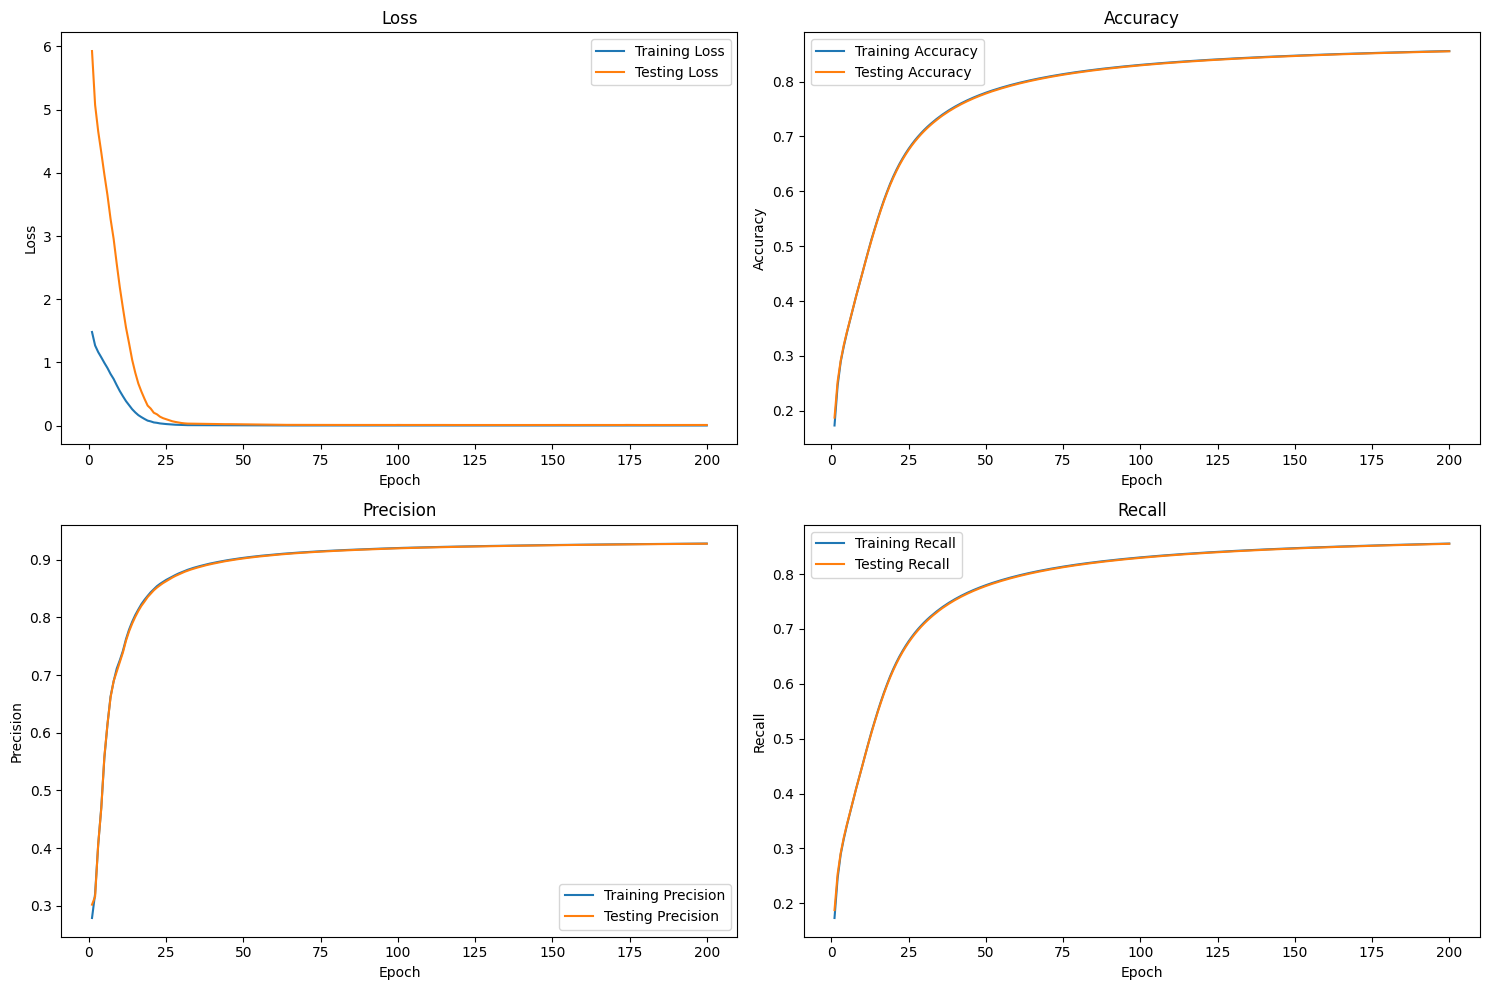

In [76]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [77]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### Vggnet16 Clasificador Linear 200 epochs early stop loss ponderada(data augmentation)

In [27]:
torch.cuda.empty_cache()
num_epochs = 200
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtractionND(num_classes=num_classes).to(device)

# Definir la tasa de aprendizaje inicial y el decaimiento
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer.weight = class_weights_tensor.to(device)


In [28]:
train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/200: 100%|████████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 1.6091, Training Accuracy: 0.3631, Training Precision: 0.3748, Training Recall: 0.3631


Testing Epoch 1/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 6.4365, Testing Accuracy: 0.3743, Testing Precision: 0.3898, Testing Recall: 0.3743


Training Epoch 2/200: 100%|████████████████| 160/160 [00:37<00:00,  4.31batch/s]


Training Loss: 0.6798, Training Accuracy: 0.5075, Training Precision: 0.5702, Training Recall: 0.5075


Testing Epoch 2/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 2.7194, Testing Accuracy: 0.4949, Testing Precision: 0.5638, Testing Recall: 0.4949


Training Epoch 3/200: 100%|████████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.3820, Training Accuracy: 0.5994, Training Precision: 0.6793, Training Recall: 0.5994


Testing Epoch 3/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 1.5279, Testing Accuracy: 0.5828, Testing Precision: 0.6749, Testing Recall: 0.5828


Training Epoch 4/200: 100%|████████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.2635, Training Accuracy: 0.6536, Training Precision: 0.7438, Training Recall: 0.6536


Testing Epoch 4/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 1.0539, Testing Accuracy: 0.6413, Testing Precision: 0.7388, Testing Recall: 0.6413


Training Epoch 5/200: 100%|████████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.1739, Training Accuracy: 0.6949, Training Precision: 0.7855, Training Recall: 0.6949


Testing Epoch 5/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.6955, Testing Accuracy: 0.6832, Testing Precision: 0.7798, Testing Recall: 0.6832


Training Epoch 6/200: 100%|████████████████| 160/160 [00:37<00:00,  4.27batch/s]


Training Loss: 0.1085, Training Accuracy: 0.7244, Training Precision: 0.8136, Training Recall: 0.7244


Testing Epoch 6/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.4341, Testing Accuracy: 0.7137, Testing Precision: 0.8076, Testing Recall: 0.7137


Training Epoch 7/200: 100%|████████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 0.0754, Training Accuracy: 0.7463, Training Precision: 0.8330, Training Recall: 0.7463


Testing Epoch 7/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.3017, Testing Accuracy: 0.7367, Testing Precision: 0.8274, Testing Recall: 0.7367


Training Epoch 8/200: 100%|████████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.0588, Training Accuracy: 0.7629, Training Precision: 0.8471, Training Recall: 0.7629


Testing Epoch 8/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.2351, Testing Accuracy: 0.7537, Testing Precision: 0.8428, Testing Recall: 0.7537


Training Epoch 9/200: 100%|████████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0435, Training Accuracy: 0.7755, Training Precision: 0.8587, Training Recall: 0.7755


Testing Epoch 9/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.1738, Testing Accuracy: 0.7675, Testing Precision: 0.8544, Testing Recall: 0.7675


Training Epoch 10/200: 100%|███████████████| 160/160 [00:37<00:00,  4.27batch/s]


Training Loss: 0.0358, Training Accuracy: 0.7860, Training Precision: 0.8675, Training Recall: 0.7860


Testing Epoch 10/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.1433, Testing Accuracy: 0.7785, Testing Precision: 0.8639, Testing Recall: 0.7785


Training Epoch 11/200: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0304, Training Accuracy: 0.7945, Training Precision: 0.8750, Training Recall: 0.7945


Testing Epoch 11/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.1215, Testing Accuracy: 0.7874, Testing Precision: 0.8715, Testing Recall: 0.7874


Training Epoch 12/200: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0259, Training Accuracy: 0.8015, Training Precision: 0.8810, Training Recall: 0.8015


Testing Epoch 12/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.1036, Testing Accuracy: 0.7948, Testing Precision: 0.8778, Testing Recall: 0.7948


Training Epoch 13/200: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0220, Training Accuracy: 0.8073, Training Precision: 0.8861, Training Recall: 0.8073


Testing Epoch 13/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0881, Testing Accuracy: 0.8012, Testing Precision: 0.8834, Testing Recall: 0.8012


Training Epoch 14/200: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0187, Training Accuracy: 0.8124, Training Precision: 0.8907, Training Recall: 0.8124


Testing Epoch 14/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0748, Testing Accuracy: 0.8066, Testing Precision: 0.8878, Testing Recall: 0.8066


Training Epoch 15/200: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0164, Training Accuracy: 0.8168, Training Precision: 0.8944, Training Recall: 0.8168


Testing Epoch 15/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0657, Testing Accuracy: 0.8113, Testing Precision: 0.8918, Testing Recall: 0.8113


Training Epoch 16/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0149, Training Accuracy: 0.8206, Training Precision: 0.8977, Training Recall: 0.8206


Testing Epoch 16/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0595, Testing Accuracy: 0.8154, Testing Precision: 0.8950, Testing Recall: 0.8154


Training Epoch 17/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0131, Training Accuracy: 0.8240, Training Precision: 0.9004, Training Recall: 0.8240


Testing Epoch 17/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0526, Testing Accuracy: 0.8191, Testing Precision: 0.8981, Testing Recall: 0.8191


Training Epoch 18/200: 100%|███████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0117, Training Accuracy: 0.8270, Training Precision: 0.9030, Training Recall: 0.8270


Testing Epoch 18/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0469, Testing Accuracy: 0.8224, Testing Precision: 0.9008, Testing Recall: 0.8224


Training Epoch 19/200: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0104, Training Accuracy: 0.8297, Training Precision: 0.9054, Training Recall: 0.8297


Testing Epoch 19/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0417, Testing Accuracy: 0.8252, Testing Precision: 0.9032, Testing Recall: 0.8252


Training Epoch 20/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0098, Training Accuracy: 0.8321, Training Precision: 0.9074, Training Recall: 0.8321


Testing Epoch 20/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0391, Testing Accuracy: 0.8279, Testing Precision: 0.9053, Testing Recall: 0.8279


Training Epoch 21/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0087, Training Accuracy: 0.8343, Training Precision: 0.9092, Training Recall: 0.8343


Testing Epoch 21/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0348, Testing Accuracy: 0.8302, Testing Precision: 0.9072, Testing Recall: 0.8302


Training Epoch 22/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0080, Training Accuracy: 0.8363, Training Precision: 0.9108, Training Recall: 0.8363


Testing Epoch 22/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0319, Testing Accuracy: 0.8323, Testing Precision: 0.9089, Testing Recall: 0.8323


Training Epoch 23/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0070, Training Accuracy: 0.8381, Training Precision: 0.9123, Training Recall: 0.8381


Testing Epoch 23/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0282, Testing Accuracy: 0.8342, Testing Precision: 0.9107, Testing Recall: 0.8342


Training Epoch 24/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0065, Training Accuracy: 0.8396, Training Precision: 0.9139, Training Recall: 0.8396


Testing Epoch 24/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0261, Testing Accuracy: 0.8360, Testing Precision: 0.9122, Testing Recall: 0.8360


Training Epoch 25/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0058, Training Accuracy: 0.8412, Training Precision: 0.9152, Training Recall: 0.8412


Testing Epoch 25/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0234, Testing Accuracy: 0.8377, Testing Precision: 0.9136, Testing Recall: 0.8377


Training Epoch 26/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0053, Training Accuracy: 0.8426, Training Precision: 0.9165, Training Recall: 0.8426


Testing Epoch 26/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0211, Testing Accuracy: 0.8392, Testing Precision: 0.9149, Testing Recall: 0.8392


Training Epoch 27/200: 100%|███████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0047, Training Accuracy: 0.8439, Training Precision: 0.9176, Training Recall: 0.8439


Testing Epoch 27/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0190, Testing Accuracy: 0.8407, Testing Precision: 0.9161, Testing Recall: 0.8407


Training Epoch 28/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0044, Training Accuracy: 0.8451, Training Precision: 0.9187, Training Recall: 0.8451


Testing Epoch 28/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0174, Testing Accuracy: 0.8420, Testing Precision: 0.9172, Testing Recall: 0.8420


Training Epoch 29/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0040, Training Accuracy: 0.8462, Training Precision: 0.9196, Training Recall: 0.8462


Testing Epoch 29/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0161, Testing Accuracy: 0.8432, Testing Precision: 0.9181, Testing Recall: 0.8432


Training Epoch 30/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0037, Training Accuracy: 0.8473, Training Precision: 0.9204, Training Recall: 0.8473


Testing Epoch 30/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0148, Testing Accuracy: 0.8444, Testing Precision: 0.9190, Testing Recall: 0.8444


Training Epoch 31/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0034, Training Accuracy: 0.8483, Training Precision: 0.9212, Training Recall: 0.8483


Testing Epoch 31/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0137, Testing Accuracy: 0.8455, Testing Precision: 0.9198, Testing Recall: 0.8455


Training Epoch 32/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0031, Training Accuracy: 0.8492, Training Precision: 0.9220, Training Recall: 0.8492


Testing Epoch 32/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0124, Testing Accuracy: 0.8465, Testing Precision: 0.9206, Testing Recall: 0.8465


Training Epoch 33/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0028, Training Accuracy: 0.8501, Training Precision: 0.9227, Training Recall: 0.8501


Testing Epoch 33/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0113, Testing Accuracy: 0.8474, Testing Precision: 0.9213, Testing Recall: 0.8474


Training Epoch 34/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8510, Training Precision: 0.9233, Training Recall: 0.8510


Testing Epoch 34/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0102, Testing Accuracy: 0.8483, Testing Precision: 0.9220, Testing Recall: 0.8483


Training Epoch 35/200: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0024, Training Accuracy: 0.8517, Training Precision: 0.9239, Training Recall: 0.8517


Testing Epoch 35/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0095, Testing Accuracy: 0.8491, Testing Precision: 0.9227, Testing Recall: 0.8491


Training Epoch 36/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0022, Training Accuracy: 0.8524, Training Precision: 0.9246, Training Recall: 0.8524


Testing Epoch 36/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0088, Testing Accuracy: 0.8499, Testing Precision: 0.9233, Testing Recall: 0.8499


Training Epoch 37/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0020, Training Accuracy: 0.8530, Training Precision: 0.9251, Training Recall: 0.8530


Testing Epoch 37/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0080, Testing Accuracy: 0.8506, Testing Precision: 0.9239, Testing Recall: 0.8506


Training Epoch 38/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0018, Training Accuracy: 0.8537, Training Precision: 0.9256, Training Recall: 0.8537


Testing Epoch 38/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0074, Testing Accuracy: 0.8514, Testing Precision: 0.9244, Testing Recall: 0.8514


Training Epoch 39/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0017, Training Accuracy: 0.8543, Training Precision: 0.9261, Training Recall: 0.8543


Testing Epoch 39/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0068, Testing Accuracy: 0.8520, Testing Precision: 0.9249, Testing Recall: 0.8520


Training Epoch 40/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0016, Training Accuracy: 0.8549, Training Precision: 0.9265, Training Recall: 0.8549


Testing Epoch 40/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0063, Testing Accuracy: 0.8526, Testing Precision: 0.9255, Testing Recall: 0.8526


Training Epoch 41/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8554, Training Precision: 0.9270, Training Recall: 0.8554


Testing Epoch 41/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0058, Testing Accuracy: 0.8533, Testing Precision: 0.9260, Testing Recall: 0.8533


Training Epoch 42/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8560, Training Precision: 0.9275, Training Recall: 0.8560


Testing Epoch 42/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0055, Testing Accuracy: 0.8539, Testing Precision: 0.9264, Testing Recall: 0.8539


Training Epoch 43/200: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0012, Training Accuracy: 0.8565, Training Precision: 0.9279, Training Recall: 0.8565


Testing Epoch 43/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0049, Testing Accuracy: 0.8544, Testing Precision: 0.9268, Testing Recall: 0.8544


Training Epoch 44/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8570, Training Precision: 0.9282, Training Recall: 0.8570


Testing Epoch 44/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0045, Testing Accuracy: 0.8550, Testing Precision: 0.9272, Testing Recall: 0.8550


Training Epoch 45/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8575, Training Precision: 0.9285, Training Recall: 0.8575


Testing Epoch 45/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0042, Testing Accuracy: 0.8555, Testing Precision: 0.9275, Testing Recall: 0.8555


Training Epoch 46/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8579, Training Precision: 0.9289, Training Recall: 0.8579


Testing Epoch 46/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0038, Testing Accuracy: 0.8560, Testing Precision: 0.9279, Testing Recall: 0.8560


Training Epoch 47/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8583, Training Precision: 0.9291, Training Recall: 0.8583


Testing Epoch 47/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0035, Testing Accuracy: 0.8564, Testing Precision: 0.9282, Testing Recall: 0.8564


Training Epoch 48/200: 100%|███████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8588, Training Precision: 0.9294, Training Recall: 0.8588


Testing Epoch 48/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0033, Testing Accuracy: 0.8569, Testing Precision: 0.9285, Testing Recall: 0.8569


Training Epoch 49/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8592, Training Precision: 0.9297, Training Recall: 0.8592


Testing Epoch 49/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.13batch/s]


Testing Loss: 0.0030, Testing Accuracy: 0.8573, Testing Precision: 0.9288, Testing Recall: 0.8573


Training Epoch 50/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8595, Training Precision: 0.9300, Training Recall: 0.8595


Testing Epoch 50/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0028, Testing Accuracy: 0.8577, Testing Precision: 0.9291, Testing Recall: 0.8577


Training Epoch 51/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8599, Training Precision: 0.9303, Training Recall: 0.8599


Testing Epoch 51/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0026, Testing Accuracy: 0.8582, Testing Precision: 0.9294, Testing Recall: 0.8582


Training Epoch 52/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8603, Training Precision: 0.9305, Training Recall: 0.8603


Testing Epoch 52/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0024, Testing Accuracy: 0.8585, Testing Precision: 0.9296, Testing Recall: 0.8585


Training Epoch 53/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8606, Training Precision: 0.9308, Training Recall: 0.8606


Testing Epoch 53/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0022, Testing Accuracy: 0.8589, Testing Precision: 0.9299, Testing Recall: 0.8589


Training Epoch 54/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8609, Training Precision: 0.9310, Training Recall: 0.8609


Testing Epoch 54/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0021, Testing Accuracy: 0.8592, Testing Precision: 0.9302, Testing Recall: 0.8592


Training Epoch 55/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8612, Training Precision: 0.9312, Training Recall: 0.8612


Testing Epoch 55/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0019, Testing Accuracy: 0.8596, Testing Precision: 0.9304, Testing Recall: 0.8596


Training Epoch 56/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8615, Training Precision: 0.9314, Training Recall: 0.8615


Testing Epoch 56/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0017, Testing Accuracy: 0.8599, Testing Precision: 0.9306, Testing Recall: 0.8599


Training Epoch 57/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8618, Training Precision: 0.9316, Training Recall: 0.8618


Testing Epoch 57/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0016, Testing Accuracy: 0.8602, Testing Precision: 0.9308, Testing Recall: 0.8602


Training Epoch 58/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8621, Training Precision: 0.9319, Training Recall: 0.8621


Testing Epoch 58/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0015, Testing Accuracy: 0.8606, Testing Precision: 0.9311, Testing Recall: 0.8606


Training Epoch 59/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8624, Training Precision: 0.9321, Training Recall: 0.8624


Testing Epoch 59/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0014, Testing Accuracy: 0.8609, Testing Precision: 0.9313, Testing Recall: 0.8609


Training Epoch 60/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8627, Training Precision: 0.9322, Training Recall: 0.8627


Testing Epoch 60/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8612, Testing Precision: 0.9315, Testing Recall: 0.8612


Training Epoch 61/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8629, Training Precision: 0.9325, Training Recall: 0.8629


Testing Epoch 61/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8615, Testing Precision: 0.9317, Testing Recall: 0.8615


Training Epoch 62/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8632, Training Precision: 0.9326, Training Recall: 0.8632


Testing Epoch 62/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0011, Testing Accuracy: 0.8617, Testing Precision: 0.9319, Testing Recall: 0.8617


Training Epoch 63/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8634, Training Precision: 0.9328, Training Recall: 0.8634


Testing Epoch 63/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8620, Testing Precision: 0.9321, Testing Recall: 0.8620


Training Epoch 64/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8637, Training Precision: 0.9330, Training Recall: 0.8637


Testing Epoch 64/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8623, Testing Precision: 0.9323, Testing Recall: 0.8623


Training Epoch 65/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8639, Training Precision: 0.9332, Training Recall: 0.8639


Testing Epoch 65/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8625, Testing Precision: 0.9324, Testing Recall: 0.8625


Training Epoch 66/200: 100%|███████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8641, Training Precision: 0.9333, Training Recall: 0.8641


Testing Epoch 66/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8628, Testing Precision: 0.9326, Testing Recall: 0.8628


Training Epoch 67/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8644, Training Precision: 0.9334, Training Recall: 0.8644


Testing Epoch 67/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8630, Testing Precision: 0.9327, Testing Recall: 0.8630


Training Epoch 68/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8646, Training Precision: 0.9336, Training Recall: 0.8646


Testing Epoch 68/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8632, Testing Precision: 0.9329, Testing Recall: 0.8632


Training Epoch 69/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8648, Training Precision: 0.9337, Training Recall: 0.8648


Testing Epoch 69/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8635, Testing Precision: 0.9330, Testing Recall: 0.8635


Training Epoch 70/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8650, Training Precision: 0.9338, Training Recall: 0.8650


Testing Epoch 70/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8637, Testing Precision: 0.9332, Testing Recall: 0.8637


Training Epoch 71/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8652, Training Precision: 0.9340, Training Recall: 0.8652


Testing Epoch 71/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8639, Testing Precision: 0.9333, Testing Recall: 0.8639


Training Epoch 72/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8654, Training Precision: 0.9341, Training Recall: 0.8654


Testing Epoch 72/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8641, Testing Precision: 0.9334, Testing Recall: 0.8641


Training Epoch 73/200: 100%|███████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8656, Training Precision: 0.9342, Training Recall: 0.8656


Testing Epoch 73/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8643, Testing Precision: 0.9336, Testing Recall: 0.8643


Training Epoch 74/200: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8657, Training Precision: 0.9343, Training Recall: 0.8657


Testing Epoch 74/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8645, Testing Precision: 0.9337, Testing Recall: 0.8645


Training Epoch 75/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8659, Training Precision: 0.9344, Training Recall: 0.8659


Testing Epoch 75/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8647, Testing Precision: 0.9338, Testing Recall: 0.8647


Training Epoch 76/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8661, Training Precision: 0.9345, Training Recall: 0.8661


Testing Epoch 76/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8649, Testing Precision: 0.9339, Testing Recall: 0.8649


Training Epoch 77/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8663, Training Precision: 0.9347, Training Recall: 0.8663


Testing Epoch 77/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8651, Testing Precision: 0.9340, Testing Recall: 0.8651


Training Epoch 78/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8664, Training Precision: 0.9348, Training Recall: 0.8664


Testing Epoch 78/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8653, Testing Precision: 0.9342, Testing Recall: 0.8653


Training Epoch 79/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8666, Training Precision: 0.9349, Training Recall: 0.8666


Testing Epoch 79/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8654, Testing Precision: 0.9343, Testing Recall: 0.8654


Training Epoch 80/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8667, Training Precision: 0.9350, Training Recall: 0.8667


Testing Epoch 80/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8656, Testing Precision: 0.9344, Testing Recall: 0.8656


Training Epoch 81/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8669, Training Precision: 0.9351, Training Recall: 0.8669


Testing Epoch 81/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8657, Testing Precision: 0.9345, Testing Recall: 0.8657


Training Epoch 82/200: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8670, Training Precision: 0.9352, Training Recall: 0.8670


Testing Epoch 82/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8659, Testing Precision: 0.9346, Testing Recall: 0.8659


Training Epoch 83/200: 100%|███████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8672, Training Precision: 0.9353, Training Recall: 0.8672


Testing Epoch 83/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8661, Testing Precision: 0.9347, Testing Recall: 0.8661


Training Epoch 84/200: 100%|███████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8673, Training Precision: 0.9354, Training Recall: 0.8673


Testing Epoch 84/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8662, Testing Precision: 0.9348, Testing Recall: 0.8662


Training Epoch 85/200: 100%|███████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8675, Training Precision: 0.9355, Training Recall: 0.8675


Testing Epoch 85/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8664, Testing Precision: 0.9350, Testing Recall: 0.8664


Training Epoch 86/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8676, Training Precision: 0.9356, Training Recall: 0.8676


Testing Epoch 86/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8665, Testing Precision: 0.9351, Testing Recall: 0.8665


Training Epoch 87/200: 100%|███████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8677, Training Precision: 0.9357, Training Recall: 0.8677


Testing Epoch 87/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8667, Testing Precision: 0.9351, Testing Recall: 0.8667


Training Epoch 88/200: 100%|███████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8678, Training Precision: 0.9358, Training Recall: 0.8678


Testing Epoch 88/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8668, Testing Precision: 0.9353, Testing Recall: 0.8668


Training Epoch 89/200: 100%|███████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8680, Training Precision: 0.9359, Training Recall: 0.8680


Testing Epoch 89/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8669, Testing Precision: 0.9354, Testing Recall: 0.8669


Training Epoch 90/200: 100%|███████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8681, Training Precision: 0.9360, Training Recall: 0.8681


Testing Epoch 90/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8671, Testing Precision: 0.9354, Testing Recall: 0.8671


Training Epoch 91/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8682, Training Precision: 0.9360, Training Recall: 0.8682


Testing Epoch 91/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8672, Testing Precision: 0.9355, Testing Recall: 0.8672


Training Epoch 92/200: 100%|███████████████| 160/160 [00:39<00:00,  4.10batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8683, Training Precision: 0.9361, Training Recall: 0.8683


Testing Epoch 92/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8673, Testing Precision: 0.9356, Testing Recall: 0.8673


Training Epoch 93/200: 100%|███████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8684, Training Precision: 0.9362, Training Recall: 0.8684


Testing Epoch 93/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8674, Testing Precision: 0.9357, Testing Recall: 0.8674


Training Epoch 94/200: 100%|███████████████| 160/160 [00:40<00:00,  4.00batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8685, Training Precision: 0.9362, Training Recall: 0.8685


Testing Epoch 94/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8676, Testing Precision: 0.9357, Testing Recall: 0.8676


Training Epoch 95/200: 100%|███████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8686, Training Precision: 0.9363, Training Recall: 0.8686


Testing Epoch 95/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8677, Testing Precision: 0.9358, Testing Recall: 0.8677


Training Epoch 96/200: 100%|███████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8687, Training Precision: 0.9364, Training Recall: 0.8687


Testing Epoch 96/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8678, Testing Precision: 0.9359, Testing Recall: 0.8678


Training Epoch 97/200: 100%|███████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8689, Training Precision: 0.9364, Training Recall: 0.8689


Testing Epoch 97/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8679, Testing Precision: 0.9360, Testing Recall: 0.8679


Training Epoch 98/200: 100%|███████████████| 160/160 [00:40<00:00,  3.99batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8690, Training Precision: 0.9365, Training Recall: 0.8690


Testing Epoch 98/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8680, Testing Precision: 0.9360, Testing Recall: 0.8680


Training Epoch 99/200: 100%|███████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8691, Training Precision: 0.9366, Training Recall: 0.8691


Testing Epoch 99/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.26batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8681, Testing Precision: 0.9361, Testing Recall: 0.8681


Training Epoch 100/200: 100%|██████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8692, Training Precision: 0.9367, Training Recall: 0.8692


Testing Epoch 100/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8682, Testing Precision: 0.9362, Testing Recall: 0.8682


Training Epoch 101/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8692, Training Precision: 0.9367, Training Recall: 0.8692


Testing Epoch 101/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8683, Testing Precision: 0.9363, Testing Recall: 0.8683


Training Epoch 102/200: 100%|██████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8693, Training Precision: 0.9368, Training Recall: 0.8693


Testing Epoch 102/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8684, Testing Precision: 0.9363, Testing Recall: 0.8684


Training Epoch 103/200: 100%|██████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8694, Training Precision: 0.9368, Training Recall: 0.8694


Testing Epoch 103/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8685, Testing Precision: 0.9364, Testing Recall: 0.8685


Training Epoch 104/200: 100%|██████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8695, Training Precision: 0.9369, Training Recall: 0.8695


Testing Epoch 104/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8686, Testing Precision: 0.9365, Testing Recall: 0.8686


Training Epoch 105/200: 100%|██████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8696, Training Precision: 0.9370, Training Recall: 0.8696


Testing Epoch 105/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8687, Testing Precision: 0.9365, Testing Recall: 0.8687


Training Epoch 106/200: 100%|██████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8697, Training Precision: 0.9370, Training Recall: 0.8697


Testing Epoch 106/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8688, Testing Precision: 0.9366, Testing Recall: 0.8688


Training Epoch 107/200: 100%|██████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8698, Training Precision: 0.9371, Training Recall: 0.8698


Testing Epoch 107/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8689, Testing Precision: 0.9366, Testing Recall: 0.8689


Training Epoch 108/200: 100%|██████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8698, Training Precision: 0.9371, Training Recall: 0.8698


Testing Epoch 108/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8690, Testing Precision: 0.9367, Testing Recall: 0.8690


Training Epoch 109/200: 100%|██████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8699, Training Precision: 0.9372, Training Recall: 0.8699


Testing Epoch 109/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8691, Testing Precision: 0.9368, Testing Recall: 0.8691


Training Epoch 110/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8700, Training Precision: 0.9372, Training Recall: 0.8700


Testing Epoch 110/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8692, Testing Precision: 0.9368, Testing Recall: 0.8692


Training Epoch 111/200: 100%|██████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8701, Training Precision: 0.9373, Training Recall: 0.8701


Testing Epoch 111/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8692, Testing Precision: 0.9369, Testing Recall: 0.8692


Training Epoch 112/200: 100%|██████████████| 160/160 [00:38<00:00,  4.14batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8701, Training Precision: 0.9373, Training Recall: 0.8701


Testing Epoch 112/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8693, Testing Precision: 0.9369, Testing Recall: 0.8693


Training Epoch 113/200: 100%|██████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8702, Training Precision: 0.9374, Training Recall: 0.8702


Testing Epoch 113/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8694, Testing Precision: 0.9370, Testing Recall: 0.8694


Training Epoch 114/200: 100%|██████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8703, Training Precision: 0.9374, Training Recall: 0.8703


Testing Epoch 114/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8695, Testing Precision: 0.9370, Testing Recall: 0.8695


Training Epoch 115/200: 100%|██████████████| 160/160 [00:38<00:00,  4.15batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8704, Training Precision: 0.9375, Training Recall: 0.8704


Testing Epoch 115/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8696, Testing Precision: 0.9371, Testing Recall: 0.8696


Training Epoch 116/200: 100%|██████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8705, Training Precision: 0.9375, Training Recall: 0.8705


Testing Epoch 116/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8697, Testing Precision: 0.9371, Testing Recall: 0.8697


Training Epoch 117/200: 100%|██████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8705, Training Precision: 0.9376, Training Recall: 0.8705


Testing Epoch 117/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8697, Testing Precision: 0.9372, Testing Recall: 0.8697


Training Epoch 118/200: 100%|██████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8706, Training Precision: 0.9376, Training Recall: 0.8706


Testing Epoch 118/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8698, Testing Precision: 0.9372, Testing Recall: 0.8698


Training Epoch 119/200: 100%|██████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8707, Training Precision: 0.9377, Training Recall: 0.8707


Testing Epoch 119/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8699, Testing Precision: 0.9373, Testing Recall: 0.8699


Training Epoch 120/200: 100%|██████████████| 160/160 [00:37<00:00,  4.27batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8707, Training Precision: 0.9377, Training Recall: 0.8707


Testing Epoch 120/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8700, Testing Precision: 0.9373, Testing Recall: 0.8700


Training Epoch 121/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8708, Training Precision: 0.9377, Training Recall: 0.8708


Testing Epoch 121/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8700, Testing Precision: 0.9374, Testing Recall: 0.8700


Training Epoch 122/200: 100%|██████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8709, Training Precision: 0.9378, Training Recall: 0.8709


Testing Epoch 122/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8701, Testing Precision: 0.9374, Testing Recall: 0.8701


Training Epoch 123/200: 100%|██████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8709, Training Precision: 0.9378, Training Recall: 0.8709


Testing Epoch 123/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8702, Testing Precision: 0.9375, Testing Recall: 0.8702


Training Epoch 124/200: 100%|██████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8710, Training Precision: 0.9379, Training Recall: 0.8710


Testing Epoch 124/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8703, Testing Precision: 0.9375, Testing Recall: 0.8703


Training Epoch 125/200: 100%|██████████████| 160/160 [00:38<00:00,  4.13batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8711, Training Precision: 0.9379, Training Recall: 0.8711


Testing Epoch 125/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8703, Testing Precision: 0.9375, Testing Recall: 0.8703


Training Epoch 126/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8711, Training Precision: 0.9380, Training Recall: 0.8711


Testing Epoch 126/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8704, Testing Precision: 0.9376, Testing Recall: 0.8704


Training Epoch 127/200: 100%|██████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8712, Training Precision: 0.9380, Training Recall: 0.8712


Testing Epoch 127/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8705, Testing Precision: 0.9376, Testing Recall: 0.8705


Training Epoch 128/200: 100%|██████████████| 160/160 [00:40<00:00,  3.99batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8713, Training Precision: 0.9380, Training Recall: 0.8713


Testing Epoch 128/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8705, Testing Precision: 0.9377, Testing Recall: 0.8705


Training Epoch 129/200: 100%|██████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8713, Training Precision: 0.9381, Training Recall: 0.8713


Testing Epoch 129/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8706, Testing Precision: 0.9377, Testing Recall: 0.8706


Training Epoch 130/200: 100%|██████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8714, Training Precision: 0.9381, Training Recall: 0.8714


Testing Epoch 130/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8707, Testing Precision: 0.9377, Testing Recall: 0.8707


Training Epoch 131/200: 100%|██████████████| 160/160 [00:38<00:00,  4.16batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8714, Training Precision: 0.9381, Training Recall: 0.8714


Testing Epoch 131/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8707, Testing Precision: 0.9378, Testing Recall: 0.8707


Training Epoch 132/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8715, Training Precision: 0.9382, Training Recall: 0.8715


Testing Epoch 132/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8708, Testing Precision: 0.9378, Testing Recall: 0.8708


Training Epoch 133/200: 100%|██████████████| 160/160 [00:37<00:00,  4.24batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8716, Training Precision: 0.9382, Training Recall: 0.8716


Testing Epoch 133/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8709, Testing Precision: 0.9378, Testing Recall: 0.8709


Training Epoch 134/200: 100%|██████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8716, Training Precision: 0.9382, Training Recall: 0.8716


Testing Epoch 134/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8709, Testing Precision: 0.9379, Testing Recall: 0.8709


Training Epoch 135/200: 100%|██████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8717, Training Precision: 0.9383, Training Recall: 0.8717


Testing Epoch 135/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8710, Testing Precision: 0.9379, Testing Recall: 0.8710


Training Epoch 136/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8717, Training Precision: 0.9383, Training Recall: 0.8717


Testing Epoch 136/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8710, Testing Precision: 0.9379, Testing Recall: 0.8710


Training Epoch 137/200: 100%|██████████████| 160/160 [00:38<00:00,  4.18batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8718, Training Precision: 0.9383, Training Recall: 0.8718


Testing Epoch 137/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.18batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8711, Testing Precision: 0.9380, Testing Recall: 0.8711


Training Epoch 138/200: 100%|██████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8718, Training Precision: 0.9383, Training Recall: 0.8718


Testing Epoch 138/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8712, Testing Precision: 0.9380, Testing Recall: 0.8712


Training Epoch 139/200: 100%|██████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8719, Training Precision: 0.9384, Training Recall: 0.8719


Testing Epoch 139/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8712, Testing Precision: 0.9380, Testing Recall: 0.8712


Training Epoch 140/200: 100%|██████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8719, Training Precision: 0.9384, Training Recall: 0.8719


Testing Epoch 140/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.20batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8713, Testing Precision: 0.9381, Testing Recall: 0.8713


Training Epoch 141/200: 100%|██████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8720, Training Precision: 0.9384, Training Recall: 0.8720


Testing Epoch 141/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8713, Testing Precision: 0.9381, Testing Recall: 0.8713


Training Epoch 142/200: 100%|██████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8720, Training Precision: 0.9385, Training Recall: 0.8720


Testing Epoch 142/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8714, Testing Precision: 0.9381, Testing Recall: 0.8714


Training Epoch 143/200: 100%|██████████████| 160/160 [00:38<00:00,  4.13batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8721, Training Precision: 0.9385, Training Recall: 0.8721


Testing Epoch 143/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.17batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8714, Testing Precision: 0.9382, Testing Recall: 0.8714


Training Epoch 144/200: 100%|██████████████| 160/160 [00:38<00:00,  4.10batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8721, Training Precision: 0.9385, Training Recall: 0.8721


Testing Epoch 144/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8715, Testing Precision: 0.9382, Testing Recall: 0.8715


Training Epoch 145/200: 100%|██████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8721, Training Precision: 0.9385, Training Recall: 0.8721


Testing Epoch 145/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8715, Testing Precision: 0.9382, Testing Recall: 0.8715


Training Epoch 146/200: 100%|██████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8722, Training Precision: 0.9385, Training Recall: 0.8722


Testing Epoch 146/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8716, Testing Precision: 0.9382, Testing Recall: 0.8716


Training Epoch 147/200: 100%|██████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8722, Training Precision: 0.9386, Training Recall: 0.8722


Testing Epoch 147/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8716, Testing Precision: 0.9383, Testing Recall: 0.8716


Training Epoch 148/200: 100%|██████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8723, Training Precision: 0.9386, Training Recall: 0.8723


Testing Epoch 148/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8717, Testing Precision: 0.9383, Testing Recall: 0.8717


Training Epoch 149/200: 100%|██████████████| 160/160 [00:38<00:00,  4.11batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8723, Training Precision: 0.9386, Training Recall: 0.8723


Testing Epoch 149/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8717, Testing Precision: 0.9383, Testing Recall: 0.8717


Training Epoch 150/200: 100%|██████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8724, Training Precision: 0.9386, Training Recall: 0.8724


Testing Epoch 150/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8717, Testing Precision: 0.9383, Testing Recall: 0.8717


Training Epoch 151/200: 100%|██████████████| 160/160 [00:38<00:00,  4.19batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8724, Training Precision: 0.9387, Training Recall: 0.8724


Testing Epoch 151/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8718, Testing Precision: 0.9383, Testing Recall: 0.8718


Training Epoch 152/200: 100%|██████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8724, Training Precision: 0.9387, Training Recall: 0.8724


Testing Epoch 152/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8718, Testing Precision: 0.9384, Testing Recall: 0.8718


Training Epoch 153/200: 100%|██████████████| 160/160 [00:37<00:00,  4.22batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8725, Training Precision: 0.9387, Training Recall: 0.8725


Testing Epoch 153/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8719, Testing Precision: 0.9384, Testing Recall: 0.8719


Training Epoch 154/200: 100%|██████████████| 160/160 [00:38<00:00,  4.20batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8725, Training Precision: 0.9387, Training Recall: 0.8725


Testing Epoch 154/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8719, Testing Precision: 0.9384, Testing Recall: 0.8719


Training Epoch 155/200: 100%|██████████████| 160/160 [00:38<00:00,  4.14batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8726, Training Precision: 0.9388, Training Recall: 0.8726


Testing Epoch 155/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8720, Testing Precision: 0.9385, Testing Recall: 0.8720


Training Epoch 156/200: 100%|██████████████| 160/160 [00:37<00:00,  4.31batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8726, Training Precision: 0.9388, Training Recall: 0.8726


Testing Epoch 156/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8720, Testing Precision: 0.9385, Testing Recall: 0.8720


Training Epoch 157/200: 100%|██████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8726, Training Precision: 0.9388, Training Recall: 0.8726


Testing Epoch 157/200: 100%|█████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8721, Testing Precision: 0.9385, Testing Recall: 0.8721


Training Epoch 158/200: 100%|██████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8727, Training Precision: 0.9388, Training Recall: 0.8727


Testing Epoch 158/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8721, Testing Precision: 0.9385, Testing Recall: 0.8721


Training Epoch 159/200: 100%|██████████████| 160/160 [00:36<00:00,  4.37batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8727, Training Precision: 0.9388, Training Recall: 0.8727


Testing Epoch 159/200: 100%|█████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8721, Testing Precision: 0.9385, Testing Recall: 0.8721


Training Epoch 160/200: 100%|██████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8728, Training Precision: 0.9389, Training Recall: 0.8728


Testing Epoch 160/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8722, Testing Precision: 0.9386, Testing Recall: 0.8722


Training Epoch 161/200: 100%|██████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8728, Training Precision: 0.9389, Training Recall: 0.8728


Testing Epoch 161/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8722, Testing Precision: 0.9386, Testing Recall: 0.8722


Training Epoch 162/200: 100%|██████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8728, Training Precision: 0.9389, Training Recall: 0.8728


Testing Epoch 162/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8723, Testing Precision: 0.9386, Testing Recall: 0.8723


Training Epoch 163/200: 100%|██████████████| 160/160 [00:37<00:00,  4.30batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8729, Training Precision: 0.9389, Training Recall: 0.8729


Testing Epoch 163/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8723, Testing Precision: 0.9386, Testing Recall: 0.8723


Training Epoch 164/200: 100%|██████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8729, Training Precision: 0.9389, Training Recall: 0.8729


Testing Epoch 164/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8723, Testing Precision: 0.9386, Testing Recall: 0.8723


Training Epoch 165/200: 100%|██████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8729, Training Precision: 0.9390, Training Recall: 0.8729


Testing Epoch 165/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8724, Testing Precision: 0.9387, Testing Recall: 0.8724


Training Epoch 166/200: 100%|██████████████| 160/160 [00:36<00:00,  4.33batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8730, Training Precision: 0.9390, Training Recall: 0.8730


Testing Epoch 166/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.16batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8724, Testing Precision: 0.9387, Testing Recall: 0.8724


Training Epoch 167/200: 100%|██████████████| 160/160 [00:38<00:00,  4.17batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8730, Training Precision: 0.9390, Training Recall: 0.8730


Testing Epoch 167/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8725, Testing Precision: 0.9387, Testing Recall: 0.8725


Training Epoch 168/200: 100%|██████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8731, Training Precision: 0.9390, Training Recall: 0.8731


Testing Epoch 168/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8725, Testing Precision: 0.9387, Testing Recall: 0.8725


Training Epoch 169/200: 100%|██████████████| 160/160 [00:36<00:00,  4.43batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8731, Training Precision: 0.9390, Training Recall: 0.8731


Testing Epoch 169/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8725, Testing Precision: 0.9387, Testing Recall: 0.8725


Training Epoch 170/200: 100%|██████████████| 160/160 [00:37<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8731, Training Precision: 0.9390, Training Recall: 0.8731


Testing Epoch 170/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.27batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8726, Testing Precision: 0.9387, Testing Recall: 0.8726


Training Epoch 171/200: 100%|██████████████| 160/160 [00:35<00:00,  4.50batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8732, Training Precision: 0.9390, Training Recall: 0.8732


Testing Epoch 171/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8726, Testing Precision: 0.9387, Testing Recall: 0.8726


Training Epoch 172/200: 100%|██████████████| 160/160 [00:37<00:00,  4.29batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8732, Training Precision: 0.9390, Training Recall: 0.8732


Testing Epoch 172/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8727, Testing Precision: 0.9387, Testing Recall: 0.8727


Training Epoch 173/200: 100%|██████████████| 160/160 [00:35<00:00,  4.49batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8732, Training Precision: 0.9390, Training Recall: 0.8732


Testing Epoch 173/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8727, Testing Precision: 0.9387, Testing Recall: 0.8727


Training Epoch 174/200: 100%|██████████████| 160/160 [00:36<00:00,  4.40batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8733, Training Precision: 0.9390, Training Recall: 0.8733


Testing Epoch 174/200: 100%|█████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8727, Testing Precision: 0.9387, Testing Recall: 0.8727


Training Epoch 175/200: 100%|██████████████| 160/160 [00:37<00:00,  4.32batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8733, Training Precision: 0.9390, Training Recall: 0.8733


Testing Epoch 175/200: 100%|█████████████████| 40/40 [00:08<00:00,  4.55batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8728, Testing Precision: 0.9387, Testing Recall: 0.8728


Training Epoch 176/200: 100%|██████████████| 160/160 [00:36<00:00,  4.38batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8733, Training Precision: 0.9390, Training Recall: 0.8733


Testing Epoch 176/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8728, Testing Precision: 0.9387, Testing Recall: 0.8728


Training Epoch 177/200: 100%|██████████████| 160/160 [00:36<00:00,  4.39batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8734, Training Precision: 0.9389, Training Recall: 0.8734


Testing Epoch 177/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8728, Testing Precision: 0.9386, Testing Recall: 0.8728


Training Epoch 178/200: 100%|██████████████| 160/160 [00:38<00:00,  4.21batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8734, Training Precision: 0.9389, Training Recall: 0.8734


Testing Epoch 178/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.14batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8729, Testing Precision: 0.9386, Testing Recall: 0.8729


Training Epoch 179/200: 100%|██████████████| 160/160 [00:37<00:00,  4.28batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8734, Training Precision: 0.9389, Training Recall: 0.8734


Testing Epoch 179/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8729, Testing Precision: 0.9386, Testing Recall: 0.8729


Training Epoch 180/200: 100%|██████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8734, Training Precision: 0.9389, Training Recall: 0.8734


Testing Epoch 180/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8729, Testing Precision: 0.9386, Testing Recall: 0.8729


Training Epoch 181/200: 100%|██████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8735, Training Precision: 0.9389, Training Recall: 0.8735


Testing Epoch 181/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8730, Testing Precision: 0.9386, Testing Recall: 0.8730


Training Epoch 182/200: 100%|██████████████| 160/160 [00:36<00:00,  4.36batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8735, Training Precision: 0.9388, Training Recall: 0.8735


Testing Epoch 182/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8730, Testing Precision: 0.9385, Testing Recall: 0.8730


Training Epoch 183/200: 100%|██████████████| 160/160 [00:37<00:00,  4.23batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8735, Training Precision: 0.9388, Training Recall: 0.8735


Testing Epoch 183/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.19batch/s]


Testing Loss: 0.0000, Testing Accuracy: 0.8730, Testing Precision: 0.9385, Testing Recall: 0.8730


Training Epoch 184/200: 100%|██████████████| 160/160 [00:36<00:00,  4.34batch/s]


Training Loss: 0.3082, Training Accuracy: 0.8732, Training Precision: 0.9384, Training Recall: 0.8732


Testing Epoch 184/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 1.2326, Testing Accuracy: 0.8727, Testing Precision: 0.9381, Testing Recall: 0.8727


Training Epoch 185/200: 100%|██████████████| 160/160 [00:37<00:00,  4.26batch/s]


Training Loss: 0.0363, Training Accuracy: 0.8731, Training Precision: 0.9383, Training Recall: 0.8731


Testing Epoch 185/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 0.1452, Testing Accuracy: 0.8727, Testing Precision: 0.9379, Testing Recall: 0.8727


Training Epoch 186/200: 100%|██████████████| 160/160 [00:37<00:00,  4.25batch/s]


Training Loss: 0.0061, Training Accuracy: 0.8732, Training Precision: 0.9382, Training Recall: 0.8732


Testing Epoch 186/200: 100%|█████████████████| 40/40 [00:09<00:00,  4.15batch/s]


Testing Loss: 0.0242, Testing Accuracy: 0.8727, Testing Precision: 0.9378, Testing Recall: 0.8727


Training Epoch 187/200: 100%|██████████████| 160/160 [00:35<00:00,  4.52batch/s]


Training Loss: 0.0024, Training Accuracy: 0.8732, Training Precision: 0.9381, Training Recall: 0.8732


Testing Epoch 187/200: 100%|█████████████████| 40/40 [00:08<00:00,  4.51batch/s]

Testing Loss: 0.0097, Testing Accuracy: 0.8727, Testing Precision: 0.9377, Testing Recall: 0.8727
No improvement for 5 epochs. Early stopping...


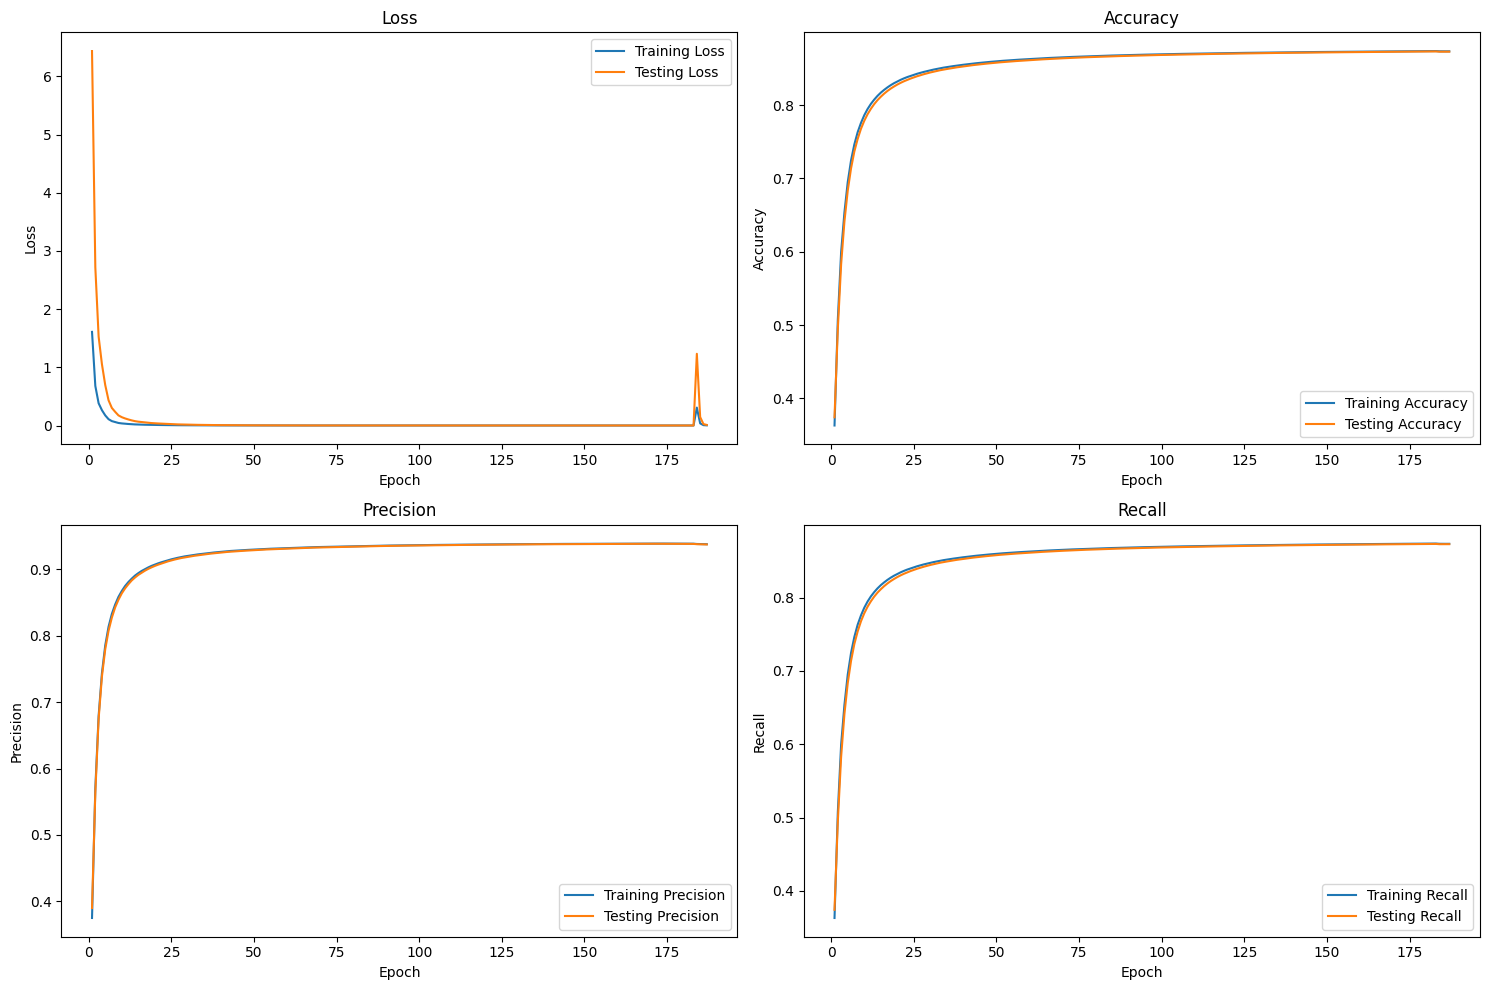

In [29]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [30]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Otras enfermedades o anormalidades, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Hipertensión, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal


### VGGNet19con feature extraction clasificador lineal 200 epochs(data augmentation) y loss ponderada, 

In [33]:
torch.cuda.empty_cache()
num_epochs = 200
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FeatureExtractionND(num_classes=num_classes).to(device)

# Definir la tasa de aprendizaje inicial y el decaimiento
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer.weight = class_weights_tensor.to(device)

In [34]:
train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/200: 100%|████████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 1.6128, Training Accuracy: 0.3669, Training Precision: 0.3884, Training Recall: 0.3669


Testing Epoch 1/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.77batch/s]


Testing Loss: 6.4513, Testing Accuracy: 0.3759, Testing Precision: 0.3936, Testing Recall: 0.3759


Training Epoch 2/200: 100%|████████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.8220, Training Accuracy: 0.4984, Training Precision: 0.5519, Training Recall: 0.4984


Testing Epoch 2/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.74batch/s]


Testing Loss: 3.2881, Testing Accuracy: 0.4892, Testing Precision: 0.5468, Testing Recall: 0.4892


Training Epoch 3/200: 100%|████████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.5242, Training Accuracy: 0.5726, Training Precision: 0.6420, Training Recall: 0.5726


Testing Epoch 3/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 2.0969, Testing Accuracy: 0.5646, Testing Precision: 0.6317, Testing Recall: 0.5646


Training Epoch 4/200: 100%|████████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.3468, Training Accuracy: 0.6302, Training Precision: 0.7009, Training Recall: 0.6302


Testing Epoch 4/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 1.3874, Testing Accuracy: 0.6198, Testing Precision: 0.6944, Testing Recall: 0.6198


Training Epoch 5/200: 100%|████████████████| 160/160 [00:43<00:00,  3.70batch/s]


Training Loss: 0.2879, Training Accuracy: 0.6691, Training Precision: 0.7424, Training Recall: 0.6691


Testing Epoch 5/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 1.1515, Testing Accuracy: 0.6586, Testing Precision: 0.7378, Testing Recall: 0.6586


Training Epoch 6/200: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.2280, Training Accuracy: 0.6982, Training Precision: 0.7737, Training Recall: 0.6982


Testing Epoch 6/200: 100%|███████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.9118, Testing Accuracy: 0.6874, Testing Precision: 0.7703, Testing Recall: 0.6874


Training Epoch 7/200: 100%|████████████████| 160/160 [00:40<00:00,  4.00batch/s]


Training Loss: 0.1588, Training Accuracy: 0.7205, Training Precision: 0.7987, Training Recall: 0.7205


Testing Epoch 7/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.6350, Testing Accuracy: 0.7112, Testing Precision: 0.7924, Testing Recall: 0.7112


Training Epoch 8/200: 100%|████████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.1156, Training Accuracy: 0.7391, Training Precision: 0.8155, Training Recall: 0.7391


Testing Epoch 8/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.4624, Testing Accuracy: 0.7306, Testing Precision: 0.8102, Testing Recall: 0.7306


Training Epoch 9/200: 100%|████████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0905, Training Accuracy: 0.7540, Training Precision: 0.8290, Training Recall: 0.7540


Testing Epoch 9/200: 100%|███████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.3622, Testing Accuracy: 0.7462, Testing Precision: 0.8247, Testing Recall: 0.7462


Training Epoch 10/200: 100%|███████████████| 160/160 [00:39<00:00,  4.03batch/s]


Training Loss: 0.0689, Training Accuracy: 0.7663, Training Precision: 0.8404, Training Recall: 0.7663


Testing Epoch 10/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.2755, Testing Accuracy: 0.7592, Testing Precision: 0.8349, Testing Recall: 0.7592


Training Epoch 11/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0585, Training Accuracy: 0.7764, Training Precision: 0.8482, Training Recall: 0.7764


Testing Epoch 11/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.2342, Testing Accuracy: 0.7694, Testing Precision: 0.8442, Testing Recall: 0.7694


Training Epoch 12/200: 100%|███████████████| 160/160 [00:39<00:00,  4.02batch/s]


Training Loss: 0.0460, Training Accuracy: 0.7846, Training Precision: 0.8557, Training Recall: 0.7846


Testing Epoch 12/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.1841, Testing Accuracy: 0.7780, Testing Precision: 0.8528, Testing Recall: 0.7780


Training Epoch 13/200: 100%|███████████████| 160/160 [00:39<00:00,  4.02batch/s]


Training Loss: 0.0420, Training Accuracy: 0.7916, Training Precision: 0.8628, Training Recall: 0.7916


Testing Epoch 13/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.1682, Testing Accuracy: 0.7856, Testing Precision: 0.8598, Testing Recall: 0.7856


Training Epoch 14/200: 100%|███████████████| 160/160 [00:39<00:00,  4.02batch/s]


Training Loss: 0.0365, Training Accuracy: 0.7978, Training Precision: 0.8686, Training Recall: 0.7978


Testing Epoch 14/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.1459, Testing Accuracy: 0.7923, Testing Precision: 0.8655, Testing Recall: 0.7923


Training Epoch 15/200: 100%|███████████████| 160/160 [00:39<00:00,  4.02batch/s]


Training Loss: 0.0299, Training Accuracy: 0.8032, Training Precision: 0.8734, Training Recall: 0.8032


Testing Epoch 15/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.1196, Testing Accuracy: 0.7980, Testing Precision: 0.8704, Testing Recall: 0.7980


Training Epoch 16/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0275, Training Accuracy: 0.8079, Training Precision: 0.8775, Training Recall: 0.8079


Testing Epoch 16/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.1098, Testing Accuracy: 0.8029, Testing Precision: 0.8742, Testing Recall: 0.8029


Training Epoch 17/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0243, Training Accuracy: 0.8121, Training Precision: 0.8806, Training Recall: 0.8121


Testing Epoch 17/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.04batch/s]


Testing Loss: 0.0971, Testing Accuracy: 0.8073, Testing Precision: 0.8780, Testing Recall: 0.8073


Training Epoch 18/200: 100%|███████████████| 160/160 [00:39<00:00,  4.03batch/s]


Training Loss: 0.0212, Training Accuracy: 0.8158, Training Precision: 0.8839, Training Recall: 0.8158


Testing Epoch 18/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0850, Testing Accuracy: 0.8113, Testing Precision: 0.8813, Testing Recall: 0.8113


Training Epoch 19/200: 100%|███████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0187, Training Accuracy: 0.8191, Training Precision: 0.8868, Training Recall: 0.8191


Testing Epoch 19/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0750, Testing Accuracy: 0.8148, Testing Precision: 0.8844, Testing Recall: 0.8148


Training Epoch 20/200: 100%|███████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0164, Training Accuracy: 0.8221, Training Precision: 0.8894, Training Recall: 0.8221


Testing Epoch 20/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 0.0656, Testing Accuracy: 0.8179, Testing Precision: 0.8870, Testing Recall: 0.8179


Training Epoch 21/200: 100%|███████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0149, Training Accuracy: 0.8247, Training Precision: 0.8917, Training Recall: 0.8247


Testing Epoch 21/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0596, Testing Accuracy: 0.8208, Testing Precision: 0.8892, Testing Recall: 0.8208


Training Epoch 22/200: 100%|███████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0140, Training Accuracy: 0.8272, Training Precision: 0.8936, Training Recall: 0.8272


Testing Epoch 22/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0561, Testing Accuracy: 0.8234, Testing Precision: 0.8912, Testing Recall: 0.8234


Training Epoch 23/200: 100%|███████████████| 160/160 [00:39<00:00,  4.04batch/s]


Training Loss: 0.0131, Training Accuracy: 0.8294, Training Precision: 0.8952, Training Recall: 0.8294


Testing Epoch 23/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0525, Testing Accuracy: 0.8257, Testing Precision: 0.8932, Testing Recall: 0.8257


Training Epoch 24/200: 100%|███████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0118, Training Accuracy: 0.8314, Training Precision: 0.8970, Training Recall: 0.8314


Testing Epoch 24/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0470, Testing Accuracy: 0.8279, Testing Precision: 0.8950, Testing Recall: 0.8279


Training Epoch 25/200: 100%|███████████████| 160/160 [00:39<00:00,  4.01batch/s]


Training Loss: 0.0106, Training Accuracy: 0.8333, Training Precision: 0.8987, Training Recall: 0.8333


Testing Epoch 25/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0425, Testing Accuracy: 0.8299, Testing Precision: 0.8965, Testing Recall: 0.8299


Training Epoch 26/200: 100%|███████████████| 160/160 [00:39<00:00,  4.06batch/s]


Training Loss: 0.0098, Training Accuracy: 0.8351, Training Precision: 0.8999, Training Recall: 0.8351


Testing Epoch 26/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0392, Testing Accuracy: 0.8317, Testing Precision: 0.8981, Testing Recall: 0.8317


Training Epoch 27/200: 100%|███████████████| 160/160 [00:39<00:00,  4.06batch/s]


Training Loss: 0.0089, Training Accuracy: 0.8366, Training Precision: 0.9013, Training Recall: 0.8366


Testing Epoch 27/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0356, Testing Accuracy: 0.8334, Testing Precision: 0.8995, Testing Recall: 0.8334


Training Epoch 28/200: 100%|███████████████| 160/160 [00:39<00:00,  4.06batch/s]


Training Loss: 0.0080, Training Accuracy: 0.8381, Training Precision: 0.9025, Training Recall: 0.8381


Testing Epoch 28/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0319, Testing Accuracy: 0.8350, Testing Precision: 0.9007, Testing Recall: 0.8350


Training Epoch 29/200: 100%|███████████████| 160/160 [00:39<00:00,  4.09batch/s]


Training Loss: 0.0072, Training Accuracy: 0.8395, Training Precision: 0.9036, Training Recall: 0.8395


Testing Epoch 29/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0287, Testing Accuracy: 0.8364, Testing Precision: 0.9020, Testing Recall: 0.8364


Training Epoch 30/200: 100%|███████████████| 160/160 [00:39<00:00,  4.03batch/s]


Training Loss: 0.0065, Training Accuracy: 0.8407, Training Precision: 0.9048, Training Recall: 0.8407


Testing Epoch 30/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0261, Testing Accuracy: 0.8378, Testing Precision: 0.9032, Testing Recall: 0.8378


Training Epoch 31/200: 100%|███████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0062, Training Accuracy: 0.8419, Training Precision: 0.9058, Training Recall: 0.8419


Testing Epoch 31/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.09batch/s]


Testing Loss: 0.0246, Testing Accuracy: 0.8391, Testing Precision: 0.9042, Testing Recall: 0.8391


Training Epoch 32/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0055, Training Accuracy: 0.8430, Training Precision: 0.9067, Training Recall: 0.8430


Testing Epoch 32/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0222, Testing Accuracy: 0.8403, Testing Precision: 0.9052, Testing Recall: 0.8403


Training Epoch 33/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0050, Training Accuracy: 0.8441, Training Precision: 0.9076, Training Recall: 0.8441


Testing Epoch 33/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.07batch/s]


Testing Loss: 0.0199, Testing Accuracy: 0.8414, Testing Precision: 0.9061, Testing Recall: 0.8414


Training Epoch 34/200: 100%|███████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0046, Training Accuracy: 0.8450, Training Precision: 0.9085, Training Recall: 0.8450


Testing Epoch 34/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.08batch/s]


Testing Loss: 0.0183, Testing Accuracy: 0.8425, Testing Precision: 0.9070, Testing Recall: 0.8425


Training Epoch 35/200: 100%|███████████████| 160/160 [00:39<00:00,  4.05batch/s]


Training Loss: 0.0043, Training Accuracy: 0.8460, Training Precision: 0.9092, Training Recall: 0.8460


Testing Epoch 35/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.12batch/s]


Testing Loss: 0.0172, Testing Accuracy: 0.8435, Testing Precision: 0.9076, Testing Recall: 0.8435


Training Epoch 36/200: 100%|███████████████| 160/160 [00:39<00:00,  4.06batch/s]


Training Loss: 0.0038, Training Accuracy: 0.8469, Training Precision: 0.9098, Training Recall: 0.8469


Testing Epoch 36/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0154, Testing Accuracy: 0.8445, Testing Precision: 0.9083, Testing Recall: 0.8445


Training Epoch 37/200: 100%|███████████████| 160/160 [00:39<00:00,  4.08batch/s]


Training Loss: 0.0037, Training Accuracy: 0.8477, Training Precision: 0.9104, Training Recall: 0.8477


Testing Epoch 37/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0150, Testing Accuracy: 0.8453, Testing Precision: 0.9090, Testing Recall: 0.8453


Training Epoch 38/200: 100%|███████████████| 160/160 [00:39<00:00,  4.07batch/s]


Training Loss: 0.0035, Training Accuracy: 0.8485, Training Precision: 0.9111, Training Recall: 0.8485


Testing Epoch 38/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.10batch/s]


Testing Loss: 0.0140, Testing Accuracy: 0.8462, Testing Precision: 0.9097, Testing Recall: 0.8462


Training Epoch 39/200: 100%|███████████████| 160/160 [00:39<00:00,  4.00batch/s]


Training Loss: 0.0032, Training Accuracy: 0.8493, Training Precision: 0.9116, Training Recall: 0.8493


Testing Epoch 39/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0128, Testing Accuracy: 0.8470, Testing Precision: 0.9103, Testing Recall: 0.8470


Training Epoch 40/200: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0029, Training Accuracy: 0.8500, Training Precision: 0.9122, Training Recall: 0.8500


Testing Epoch 40/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0117, Testing Accuracy: 0.8477, Testing Precision: 0.9109, Testing Recall: 0.8477


Training Epoch 41/200: 100%|███████████████| 160/160 [00:42<00:00,  3.81batch/s]


Training Loss: 0.0026, Training Accuracy: 0.8506, Training Precision: 0.9127, Training Recall: 0.8506


Testing Epoch 41/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 0.0104, Testing Accuracy: 0.8484, Testing Precision: 0.9115, Testing Recall: 0.8484


Training Epoch 42/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0024, Training Accuracy: 0.8512, Training Precision: 0.9133, Training Recall: 0.8512


Testing Epoch 42/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.76batch/s]


Testing Loss: 0.0095, Testing Accuracy: 0.8491, Testing Precision: 0.9120, Testing Recall: 0.8491


Training Epoch 43/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0022, Training Accuracy: 0.8519, Training Precision: 0.9138, Training Recall: 0.8519


Testing Epoch 43/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.02batch/s]


Testing Loss: 0.0088, Testing Accuracy: 0.8498, Testing Precision: 0.9125, Testing Recall: 0.8498


Training Epoch 44/200: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0020, Training Accuracy: 0.8525, Training Precision: 0.9142, Training Recall: 0.8525


Testing Epoch 44/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 0.0081, Testing Accuracy: 0.8505, Testing Precision: 0.9129, Testing Recall: 0.8505


Training Epoch 45/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0020, Training Accuracy: 0.8531, Training Precision: 0.9146, Training Recall: 0.8531


Testing Epoch 45/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.05batch/s]


Testing Loss: 0.0079, Testing Accuracy: 0.8511, Testing Precision: 0.9134, Testing Recall: 0.8511


Training Epoch 46/200: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0018, Training Accuracy: 0.8536, Training Precision: 0.9150, Training Recall: 0.8536


Testing Epoch 46/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.68batch/s]


Testing Loss: 0.0072, Testing Accuracy: 0.8517, Testing Precision: 0.9137, Testing Recall: 0.8517


Training Epoch 47/200: 100%|███████████████| 160/160 [00:42<00:00,  3.81batch/s]


Training Loss: 0.0016, Training Accuracy: 0.8542, Training Precision: 0.9153, Training Recall: 0.8542


Testing Epoch 47/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.0064, Testing Accuracy: 0.8523, Testing Precision: 0.9141, Testing Recall: 0.8523


Training Epoch 48/200: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0015, Training Accuracy: 0.8547, Training Precision: 0.9156, Training Recall: 0.8547


Testing Epoch 48/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 0.0058, Testing Accuracy: 0.8528, Testing Precision: 0.9145, Testing Recall: 0.8528


Training Epoch 49/200: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0014, Training Accuracy: 0.8552, Training Precision: 0.9160, Training Recall: 0.8552


Testing Epoch 49/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0055, Testing Accuracy: 0.8533, Testing Precision: 0.9149, Testing Recall: 0.8533


Training Epoch 50/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0013, Training Accuracy: 0.8556, Training Precision: 0.9163, Training Recall: 0.8556


Testing Epoch 50/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.0053, Testing Accuracy: 0.8538, Testing Precision: 0.9152, Testing Recall: 0.8538


Training Epoch 51/200: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0012, Training Accuracy: 0.8561, Training Precision: 0.9166, Training Recall: 0.8561


Testing Epoch 51/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0049, Testing Accuracy: 0.8543, Testing Precision: 0.9155, Testing Recall: 0.8543


Training Epoch 52/200: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0011, Training Accuracy: 0.8565, Training Precision: 0.9169, Training Recall: 0.8565


Testing Epoch 52/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0043, Testing Accuracy: 0.8548, Testing Precision: 0.9158, Testing Recall: 0.8548


Training Epoch 53/200: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0010, Training Accuracy: 0.8569, Training Precision: 0.9172, Training Recall: 0.8569


Testing Epoch 53/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 0.0042, Testing Accuracy: 0.8553, Testing Precision: 0.9161, Testing Recall: 0.8553


Training Epoch 54/200: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0009, Training Accuracy: 0.8573, Training Precision: 0.9174, Training Recall: 0.8573


Testing Epoch 54/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0037, Testing Accuracy: 0.8557, Testing Precision: 0.9165, Testing Recall: 0.8557


Training Epoch 55/200: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8577, Training Precision: 0.9177, Training Recall: 0.8577


Testing Epoch 55/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0034, Testing Accuracy: 0.8561, Testing Precision: 0.9168, Testing Recall: 0.8561


Training Epoch 56/200: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0008, Training Accuracy: 0.8581, Training Precision: 0.9181, Training Recall: 0.8581


Testing Epoch 56/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.06batch/s]


Testing Loss: 0.0033, Testing Accuracy: 0.8564, Testing Precision: 0.9172, Testing Recall: 0.8564


Training Epoch 57/200: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8584, Training Precision: 0.9184, Training Recall: 0.8584


Testing Epoch 57/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 0.0030, Testing Accuracy: 0.8568, Testing Precision: 0.9175, Testing Recall: 0.8568


Training Epoch 58/200: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0007, Training Accuracy: 0.8587, Training Precision: 0.9187, Training Recall: 0.8587


Testing Epoch 58/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0027, Testing Accuracy: 0.8572, Testing Precision: 0.9177, Testing Recall: 0.8572


Training Epoch 59/200: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8591, Training Precision: 0.9189, Training Recall: 0.8591


Testing Epoch 59/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 0.0025, Testing Accuracy: 0.8575, Testing Precision: 0.9180, Testing Recall: 0.8575


Training Epoch 60/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0006, Training Accuracy: 0.8594, Training Precision: 0.9191, Training Recall: 0.8594


Testing Epoch 60/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 0.0023, Testing Accuracy: 0.8579, Testing Precision: 0.9182, Testing Recall: 0.8579


Training Epoch 61/200: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8597, Training Precision: 0.9193, Training Recall: 0.8597


Testing Epoch 61/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.0022, Testing Accuracy: 0.8582, Testing Precision: 0.9184, Testing Recall: 0.8582


Training Epoch 62/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8600, Training Precision: 0.9195, Training Recall: 0.8600


Testing Epoch 62/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0020, Testing Accuracy: 0.8585, Testing Precision: 0.9186, Testing Recall: 0.8585


Training Epoch 63/200: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0005, Training Accuracy: 0.8603, Training Precision: 0.9197, Training Recall: 0.8603


Testing Epoch 63/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 0.0019, Testing Accuracy: 0.8589, Testing Precision: 0.9188, Testing Recall: 0.8589


Training Epoch 64/200: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8606, Training Precision: 0.9198, Training Recall: 0.8606


Testing Epoch 64/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0017, Testing Accuracy: 0.8592, Testing Precision: 0.9190, Testing Recall: 0.8592


Training Epoch 65/200: 100%|███████████████| 160/160 [00:42<00:00,  3.80batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8608, Training Precision: 0.9200, Training Recall: 0.8608


Testing Epoch 65/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0016, Testing Accuracy: 0.8595, Testing Precision: 0.9192, Testing Recall: 0.8595


Training Epoch 66/200: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8611, Training Precision: 0.9202, Training Recall: 0.8611


Testing Epoch 66/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0015, Testing Accuracy: 0.8597, Testing Precision: 0.9193, Testing Recall: 0.8597


Training Epoch 67/200: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0004, Training Accuracy: 0.8614, Training Precision: 0.9203, Training Recall: 0.8614


Testing Epoch 67/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0014, Testing Accuracy: 0.8600, Testing Precision: 0.9195, Testing Recall: 0.8600


Training Epoch 68/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8616, Training Precision: 0.9205, Training Recall: 0.8616


Testing Epoch 68/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0013, Testing Accuracy: 0.8603, Testing Precision: 0.9197, Testing Recall: 0.8603


Training Epoch 69/200: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8619, Training Precision: 0.9206, Training Recall: 0.8619


Testing Epoch 69/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0012, Testing Accuracy: 0.8605, Testing Precision: 0.9198, Testing Recall: 0.8605


Training Epoch 70/200: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0003, Training Accuracy: 0.8621, Training Precision: 0.9208, Training Recall: 0.8621


Testing Epoch 70/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.95batch/s]


Testing Loss: 0.0011, Testing Accuracy: 0.8608, Testing Precision: 0.9199, Testing Recall: 0.8608


Training Epoch 71/200: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8623, Training Precision: 0.9209, Training Recall: 0.8623


Testing Epoch 71/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0010, Testing Accuracy: 0.8611, Testing Precision: 0.9201, Testing Recall: 0.8611


Training Epoch 72/200: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8626, Training Precision: 0.9210, Training Recall: 0.8626


Testing Epoch 72/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0009, Testing Accuracy: 0.8613, Testing Precision: 0.9202, Testing Recall: 0.8613


Training Epoch 73/200: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8628, Training Precision: 0.9211, Training Recall: 0.8628


Testing Epoch 73/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8616, Testing Precision: 0.9203, Testing Recall: 0.8616


Training Epoch 74/200: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8630, Training Precision: 0.9212, Training Recall: 0.8630


Testing Epoch 74/200: 100%|██████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 0.0008, Testing Accuracy: 0.8618, Testing Precision: 0.9205, Testing Recall: 0.8618


Training Epoch 75/200: 100%|███████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8632, Training Precision: 0.9214, Training Recall: 0.8632


Testing Epoch 75/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.03batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8620, Testing Precision: 0.9206, Testing Recall: 0.8620


Training Epoch 76/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8634, Training Precision: 0.9214, Training Recall: 0.8634


Testing Epoch 76/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0007, Testing Accuracy: 0.8622, Testing Precision: 0.9207, Testing Recall: 0.8622


Training Epoch 77/200: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0002, Training Accuracy: 0.8636, Training Precision: 0.9216, Training Recall: 0.8636


Testing Epoch 77/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8624, Testing Precision: 0.9208, Testing Recall: 0.8624


Training Epoch 78/200: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8638, Training Precision: 0.9217, Training Recall: 0.8638


Testing Epoch 78/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 0.0006, Testing Accuracy: 0.8627, Testing Precision: 0.9210, Testing Recall: 0.8627


Training Epoch 79/200: 100%|███████████████| 160/160 [00:40<00:00,  3.90batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8640, Training Precision: 0.9218, Training Recall: 0.8640


Testing Epoch 79/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8629, Testing Precision: 0.9211, Testing Recall: 0.8629


Training Epoch 80/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8642, Training Precision: 0.9219, Training Recall: 0.8642


Testing Epoch 80/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8631, Testing Precision: 0.9212, Testing Recall: 0.8631


Training Epoch 81/200: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8644, Training Precision: 0.9220, Training Recall: 0.8644


Testing Epoch 81/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0005, Testing Accuracy: 0.8633, Testing Precision: 0.9213, Testing Recall: 0.8633


Training Epoch 82/200: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8646, Training Precision: 0.9221, Training Recall: 0.8646


Testing Epoch 82/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.97batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8635, Testing Precision: 0.9214, Testing Recall: 0.8635


Training Epoch 83/200: 100%|███████████████| 160/160 [00:40<00:00,  3.90batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8647, Training Precision: 0.9222, Training Recall: 0.8647


Testing Epoch 83/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.90batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8636, Testing Precision: 0.9216, Testing Recall: 0.8636


Training Epoch 84/200: 100%|███████████████| 160/160 [00:40<00:00,  3.98batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8649, Training Precision: 0.9224, Training Recall: 0.8649


Testing Epoch 84/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.98batch/s]


Testing Loss: 0.0004, Testing Accuracy: 0.8638, Testing Precision: 0.9217, Testing Recall: 0.8638


Training Epoch 85/200: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8651, Training Precision: 0.9224, Training Recall: 0.8651


Testing Epoch 85/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8640, Testing Precision: 0.9218, Testing Recall: 0.8640


Training Epoch 86/200: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8652, Training Precision: 0.9225, Training Recall: 0.8652


Testing Epoch 86/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.73batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8642, Testing Precision: 0.9219, Testing Recall: 0.8642


Training Epoch 87/200: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8654, Training Precision: 0.9226, Training Recall: 0.8654


Testing Epoch 87/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8643, Testing Precision: 0.9220, Testing Recall: 0.8643


Training Epoch 88/200: 100%|███████████████| 160/160 [00:42<00:00,  3.73batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8655, Training Precision: 0.9227, Training Recall: 0.8655


Testing Epoch 88/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.99batch/s]


Testing Loss: 0.0003, Testing Accuracy: 0.8645, Testing Precision: 0.9221, Testing Recall: 0.8645


Training Epoch 89/200: 100%|███████████████| 160/160 [00:42<00:00,  3.79batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8657, Training Precision: 0.9228, Training Recall: 0.8657


Testing Epoch 89/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8647, Testing Precision: 0.9221, Testing Recall: 0.8647


Training Epoch 90/200: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8658, Training Precision: 0.9229, Training Recall: 0.8658


Testing Epoch 90/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.91batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8648, Testing Precision: 0.9222, Testing Recall: 0.8648


Training Epoch 91/200: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0001, Training Accuracy: 0.8660, Training Precision: 0.9229, Training Recall: 0.8660


Testing Epoch 91/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.70batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8650, Testing Precision: 0.9223, Testing Recall: 0.8650


Training Epoch 92/200: 100%|███████████████| 160/160 [00:42<00:00,  3.76batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8661, Training Precision: 0.9230, Training Recall: 0.8661


Testing Epoch 92/200: 100%|██████████████████| 40/40 [00:09<00:00,  4.00batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8651, Testing Precision: 0.9224, Testing Recall: 0.8651


Training Epoch 93/200: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8662, Training Precision: 0.9231, Training Recall: 0.8662


Testing Epoch 93/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8653, Testing Precision: 0.9225, Testing Recall: 0.8653


Training Epoch 94/200: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8664, Training Precision: 0.9232, Training Recall: 0.8664


Testing Epoch 94/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.96batch/s]


Testing Loss: 0.0002, Testing Accuracy: 0.8654, Testing Precision: 0.9226, Testing Recall: 0.8654


Training Epoch 95/200: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8665, Training Precision: 0.9233, Training Recall: 0.8665


Testing Epoch 95/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.78batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8655, Testing Precision: 0.9227, Testing Recall: 0.8655


Training Epoch 96/200: 100%|███████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8666, Training Precision: 0.9234, Training Recall: 0.8666


Testing Epoch 96/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8657, Testing Precision: 0.9227, Testing Recall: 0.8657


Training Epoch 97/200: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.0000, Training Accuracy: 0.8667, Training Precision: 0.9234, Training Recall: 0.8667


Testing Epoch 97/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.93batch/s]


Testing Loss: 0.0001, Testing Accuracy: 0.8658, Testing Precision: 0.9229, Testing Recall: 0.8658


Training Epoch 98/200: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0067, Training Accuracy: 0.8668, Training Precision: 0.9235, Training Recall: 0.8668


Testing Epoch 98/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 0.0267, Testing Accuracy: 0.8658, Testing Precision: 0.9228, Testing Recall: 0.8658


Training Epoch 99/200: 100%|███████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.5783, Training Accuracy: 0.8656, Training Precision: 0.9221, Training Recall: 0.8656


Testing Epoch 99/200: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 2.3132, Testing Accuracy: 0.8646, Testing Precision: 0.9212, Testing Recall: 0.8646


Training Epoch 100/200: 100%|██████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0852, Training Accuracy: 0.8654, Training Precision: 0.9215, Training Recall: 0.8654


Testing Epoch 100/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.79batch/s]


Testing Loss: 0.3407, Testing Accuracy: 0.8645, Testing Precision: 0.9201, Testing Recall: 0.8645


Training Epoch 101/200: 100%|██████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.0113, Training Accuracy: 0.8655, Training Precision: 0.9207, Training Recall: 0.8655


Testing Epoch 101/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 0.0454, Testing Accuracy: 0.8646, Testing Precision: 0.9201, Testing Recall: 0.8646


Training Epoch 102/200: 100%|██████████████| 160/160 [00:40<00:00,  3.99batch/s]


Training Loss: 0.0109, Training Accuracy: 0.8656, Training Precision: 0.9207, Training Recall: 0.8656


Testing Epoch 102/200: 100%|█████████████████| 40/40 [00:10<00:00,  3.97batch/s]

Testing Loss: 0.0435, Testing Accuracy: 0.8646, Testing Precision: 0.9199, Testing Recall: 0.8646
No improvement for 5 epochs. Early stopping...


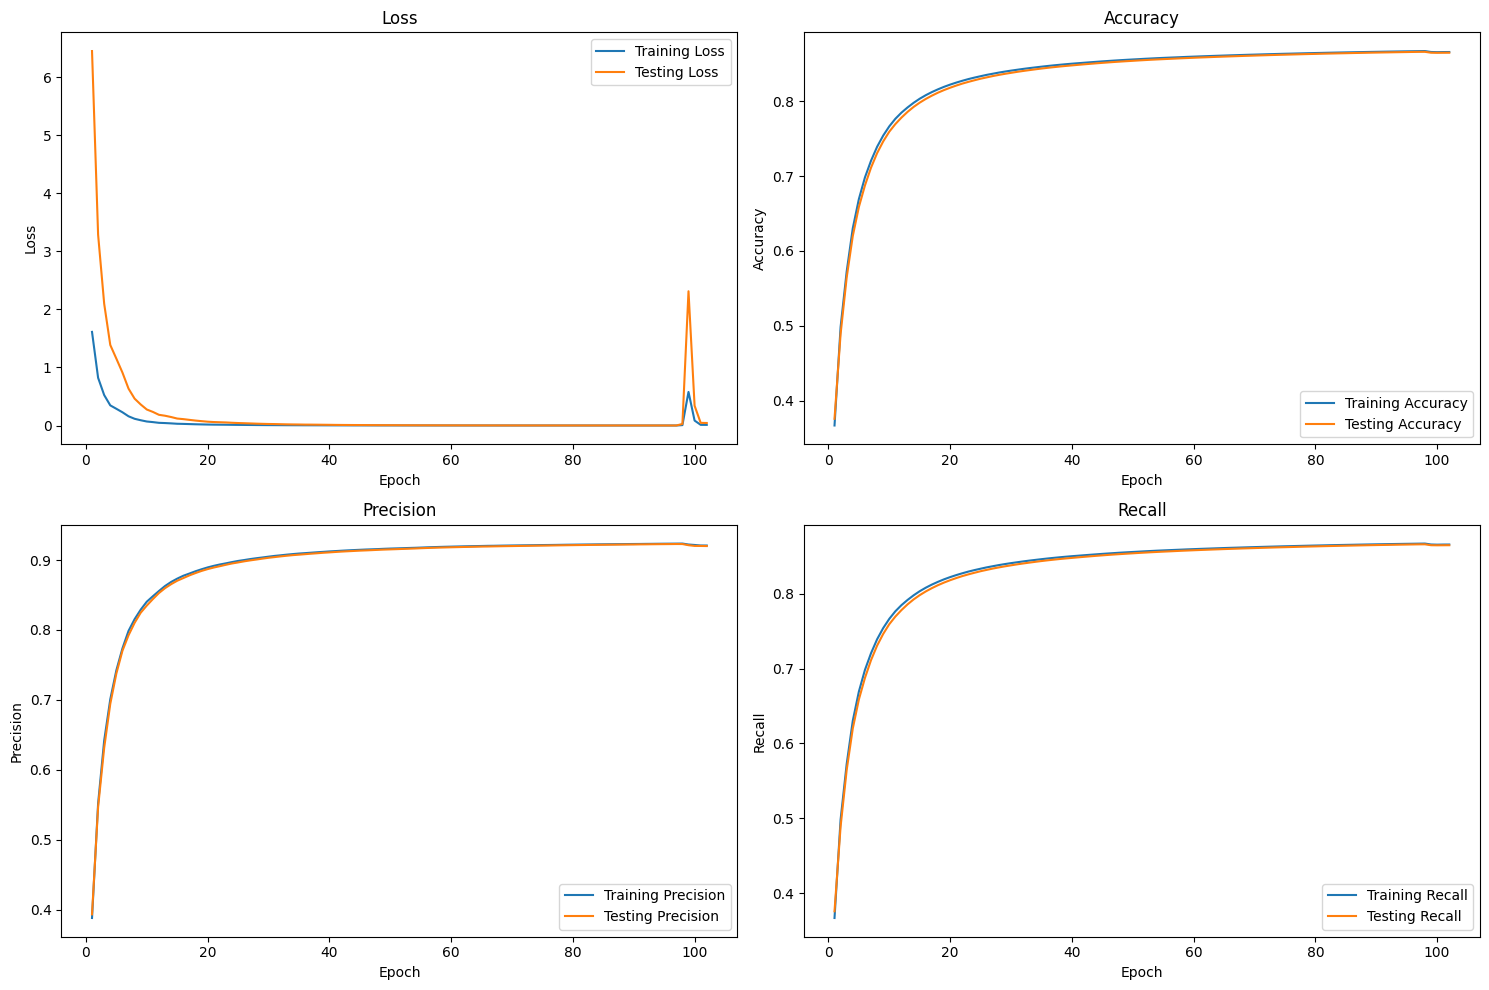

In [35]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [36]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Otras enfermedades o anormalidades, Predicted: Diabetes
Expected: Otras enfermedades o anormalidades, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Hipertensión, Predicted: Otras enfermedades o anormalidades
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Otras enfermedades o anormalidades
